## Introduction

We have two datasets reflecting behaviour of customers on the website from Sberautopodpiska. 
1) ga_sessions.csv reflects each session of any user attending a website. Briefly this dataset shows an important informtation like  customers' visit date, source of utm, device specs and geo information. 

2) ga_hits.csv reflects information of what was done by the user during each session, e.g. search for special auto or subscribe, request car or request callback, e.t.c.

<b>The goal is to predict whether a user initializes target action or not during the session.</b>

## Imports

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime as dt


from catboost import CatBoostClassifier, cv, Pool
from catboost.utils import get_roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix, auc
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.utils import resample

## EDA

### Missing values, duplicates handling

In [2]:
# load datasets
df_sessions = pd.read_csv('../Downloads/ga_sessions.csv')
df_hits = pd.read_csv('../Downloads/ga_hits.csv')

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3013231956.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sessions = pd.read_csv('../Downloads/ga_sessions.csv')


In [3]:
print('Shape of sessions data: ', df_sessions.shape)
df_sessions.head()

Shape of sessions data:  (1860042, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [4]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1.860042e+06,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042
unique,1860042,1.391717e+06,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1.750498e+09,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,4.620000e+02,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# we would like to see visit_number more clear.
df_sessions.visit_number.describe().apply(lambda x: f'{x: 0.2f}')

count     1860042.00
mean            2.71
std            11.83
min             1.00
25%             1.00
50%             1.00
75%             2.00
max           564.00
Name: visit_number, dtype: object

In [6]:
# AVG for visit_number is 2.71. It means that clients tend to come back on website. Probably, webservice might show good CRR.
# We see that utm_medium column most frequent value is banner. It means that main ad channel is banner, especially considering huge frequency level. We can suppose that banner ad company should be 
# developed even more to increase customers flow.
# Interesting fact: top device is Apple, but top OS is Android :) That's because we see lack of non-null values in device_os col. 

In [7]:
# have a glance at data types
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [8]:
# continue with hits table
print('Shape of hits data: ', df_hits.shape)
df_hits.head()

Shape of hits data:  (15726470, 11)


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [9]:
df_hits.describe(include='all')

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
count,15726470,15726470,6.566148e+06,1.572647e+07,15726470,9451666,15726470,15726470,15726470,11966286,0.0
unique,1734610,226,NaN,NaN,1,37873,342715,52,230,39825,NaN
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,NaN
freq,768,513035,NaN,NaN,15726470,8879187,2793639,7456998,3558985,6505447,NaN
mean,NaN,NaN,2.091050e+05,2.356715e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.032110e+05,2.887713e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.412000e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.994100e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.195352e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# let us have a better look at hit_time...
df_hits.hit_time.describe().apply(lambda x: f'{x: 0.2f}')

count      6566148.00
mean        209104.99
std         403210.97
min              0.00
25%          24120.00
50%          89941.00
75%         219535.25
max       13156885.00
Name: hit_time, dtype: object

In [11]:
# ...and hit_number columns
df_hits.hit_number.describe().apply(lambda x: f'{x: 0.2f}')

count     15726470.00
mean            23.57
std             28.88
min              1.00
25%              7.00
50%             15.00
75%             29.00
max            500.00
Name: hit_number, dtype: object

In [12]:
# session_id col in hits table has duplicated values as we expected, unlike sessions table which session_id freq equals 1.
# according to hit_number col users usually spend a lot of time on website, mean is 23 clicks and median is 15.
# event_value col is useless, because we have only NaNs in it
# since event_action is a target we can convert it to 0 for TN and 1 for TP values at next steps

In [13]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [14]:
# add target rows to the list for understanding what we are predicting. These clicks are located in event_action col
target_rows = ['sub_car_claim_click', 'sub_car_claim_submit_click','sub_open_dialog_click', 
               'sub_custom_question_submit_click','sub_call_number_click', 'sub_callback_submit_click',
               'sub_submit_success', 'sub_car_request_submit_click']

In [15]:
# let's look at these values
df_hits.loc[df_hits['event_action'].isin(target_rows)]

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
4016,2744563715298057088.1640258436.1640258436,2021-12-23,843092.0,81,event,NaN,sberauto.com/cars/all/kia/rio/fee33fe6?utm_sou...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
4045,3087297479839089634.1640268774.1640268774,2021-12-23,194144.0,22,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?utm...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
4046,3156966333326004302.1640206419.1640206800,2021-12-23,327223.0,63,event,NaN,sberauto.com/cars/all/skoda/rapid/bf24b977?utm...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
4047,3750243879753098158.1640272208.1640272208,2021-12-23,156992.0,20,event,NaN,sberauto.com/cars/all/nissan/x-trail/0744675f?...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
4048,7518333712042258254.1640258901.1640258901,2021-12-23,170616.0,16,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,sub_submit,sub_submit_success,KuMiABMMbspIDDhiCNVS,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15725025,1277864870843199549.1636773954.1636773954,2021-11-13,354017.0,30,event,NaN,sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...,sub_button_click,sub_car_claim_submit_click,NaN,NaN
15725133,965861352491898977.1636751459.1636751459,2021-11-13,172590.0,18,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,sub_submit,sub_submit_success,nsPPIRqjxBefONGPpnsF,NaN
15725134,4727705172767122620.1636818847.1636818847,2021-11-13,356120.0,43,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,sub_submit,sub_submit_success,uimgZZmhfLQwbKAZZfCk,NaN
15725135,4727705172767122620.1636818847.1636818847,2021-11-13,312303.0,41,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,sub_button_click,sub_open_dialog_click,ZaZuwAXOKlbzyhUqtnmk,NaN


In [16]:
# we have only 104908 rows for target var as a TP values and about 15 mln. of true negative. 
# in this case we can suppose that we have an imbalanced dataset in target variable. Let us visualize it
df_show = [1 if x in target_rows else 0 for x in df_hits.event_action]

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/45108184.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(df_show, fill=True, palette='crest')#, bins=2)


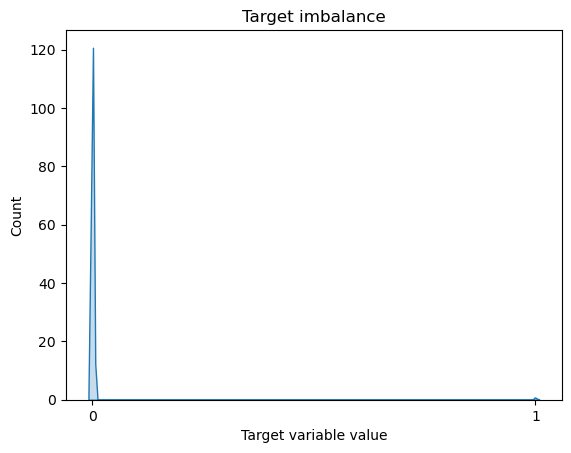

In [17]:
sns.kdeplot(df_show, fill=True, palette='crest')#, bins=2)
plt.xticks([0, 1])
plt.xlabel('Target variable value')
plt.ylabel('Count')
plt.title('Target imbalance')
plt.show();

In [18]:
# it may affect ROC-AUC results in future modelling. Anyway, we are continuing to dive into data and see what results
# would be after modelling. Also we have to admit, that ga_hits table shows us many clicks in one session. This imbalance won't be so catastrophic after merging ga_sessions with target var.
# Let us indicate separate column for target var where 1 will be stated according to target_rows list as TP action.
df_hits['event_action_target'] = df_hits.event_action.apply(lambda x: 1 if x in target_rows else np.nan)

In [19]:
df_hits[df_hits['event_action_target'] == 1][['session_id', 'event_action_target']]

,session_id,event_action_target
4016,2744563715298057088.1640258436.1640258436,1.0
4045,3087297479839089634.1640268774.1640268774,1.0
4046,3156966333326004302.1640206419.1640206800,1.0
4047,3750243879753098158.1640272208.1640272208,1.0
4048,7518333712042258254.1640258901.1640258901,1.0
...,...,...
15725025,1277864870843199549.1636773954.1636773954,1.0
15725133,965861352491898977.1636751459.1636751459,1.0
15725134,4727705172767122620.1636818847.1636818847,1.0
15725135,4727705172767122620.1636818847.1636818847,1.0


In [20]:
# great 104908 values. Now it's time to check duplicates and combine df_sessions with target row.
df_hits_target = df_hits[df_hits['event_action_target'] == 1][['session_id', 'event_action_target']]
df_hits_target.duplicated().sum()

54148

In [21]:
# wow so many duplicated rows. Ok, we will delete them and merge target with ga_sessions
df_hits_target = df_hits_target.drop_duplicates()
df_hits_target.shape

(50760, 2)

In [22]:
df = pd.merge(df_sessions, df_hits_target, on='session_id', how='left')

In [23]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,NaN
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,NaN
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,NaN
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,NaN
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,NaN


In [24]:
# check if we still have the same number of rows for target var
df[df['event_action_target'] == 1]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
71,9055768928391199041.1623652678.1623652678,2108460508.162365,2021-06-14,09:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Moscow,1.0
75,9055789093275396095.1636395007.1636395007,2108465203.16364,2021-11-08,21:10:07,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x736,Safari,Russia,Samara,1.0
78,9055794766915104430.1624305327.1624305327,2108466524.16243,2021-06-21,22:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,834x1112,Safari,Russia,Domodedovo,1.0
132,9056028189803556573.1630154471.1630154471,2108520872.163016,2021-08-28,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,YaBrowser,Russia,Krasnodar,1.0
142,9056093322981390023.1628944098.1628944098,2108536037.162894,2021-08-14,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x740,Chrome,Russia,Moscow,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859923,9054912872702758664.1636781836.1636781836,2108261192.163678,2021-11-13,08:37:16,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,HKFjmDlYppkKqsWPogJt,mobile,Android,Xiaomi,NaN,360x800,Chrome,Russia,Moscow,1.0
1860000,9055248417020050011.1634073188.1634073188,2108339317.163408,2021-10-13,00:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Nizhny Novgorod,1.0
1860002,9055248417020050011.1634075541.1634075541,2108339317.163408,2021-10-13,00:00:00,3,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Nizhny Novgorod,1.0
1860029,9055376699099939975.1630766214.1630766214,2108369185.163077,2021-09-04,17:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,NaN,NaN,NaN,1920x1080,Chrome,Russia,Khimki,1.0


In [25]:
# less, it can be explained by the difference between session_id unique values in default tables. Let's check one exact random value to be sure.
df[df['session_id'] == '965861352491898977.1636751459.1636751459']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
47778,965861352491898977.1636751459.1636751459,224882120.163675,2021-11-13,00:10:59,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Vivo,FJApgTrMAGHoxCxQVKws,360x772,Chrome,Russia,Moscow,1.0


In [26]:
# that's correct. Also we need to fillna values in target with 0. 
df['event_action_target'] = df['event_action_target'].fillna(0)

In [27]:
df[df['event_action_target'] == 1].shape

(50314, 19)

In [28]:
# great now we can describe df
df.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
count,1860042,1.860042e+06,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042,1.860042e+06
unique,1860042,1.391717e+06,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548,NaN
top,9055434745589932991.1637753792.1637753792,1.750498e+09,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow,NaN
freq,1,4.620000e+02,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329,NaN
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.704993e-02
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.622290e-01
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [29]:
# don't like target var display
df.event_action_target.describe().apply(lambda x: f'{x:0.2f}')

count    1860042.00
mean           0.03
std            0.16
min            0.00
25%            0.00
50%            0.00
75%            0.00
max            1.00
Name: event_action_target, dtype: object

In [30]:
# now it's correct, we see only 0 and 1, also we understand that there is huge imbalance of the data in target variable considering mean and std

In [31]:
# check datatypes one more time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  event_action_target       float64
dtypes: float64(1), int64(1), object(17)
memory usage: 269.6+ MB


In [32]:
# Seems everything to be correct. Let us check duplicates 
df.duplicated().sum()

0

<Axes: >

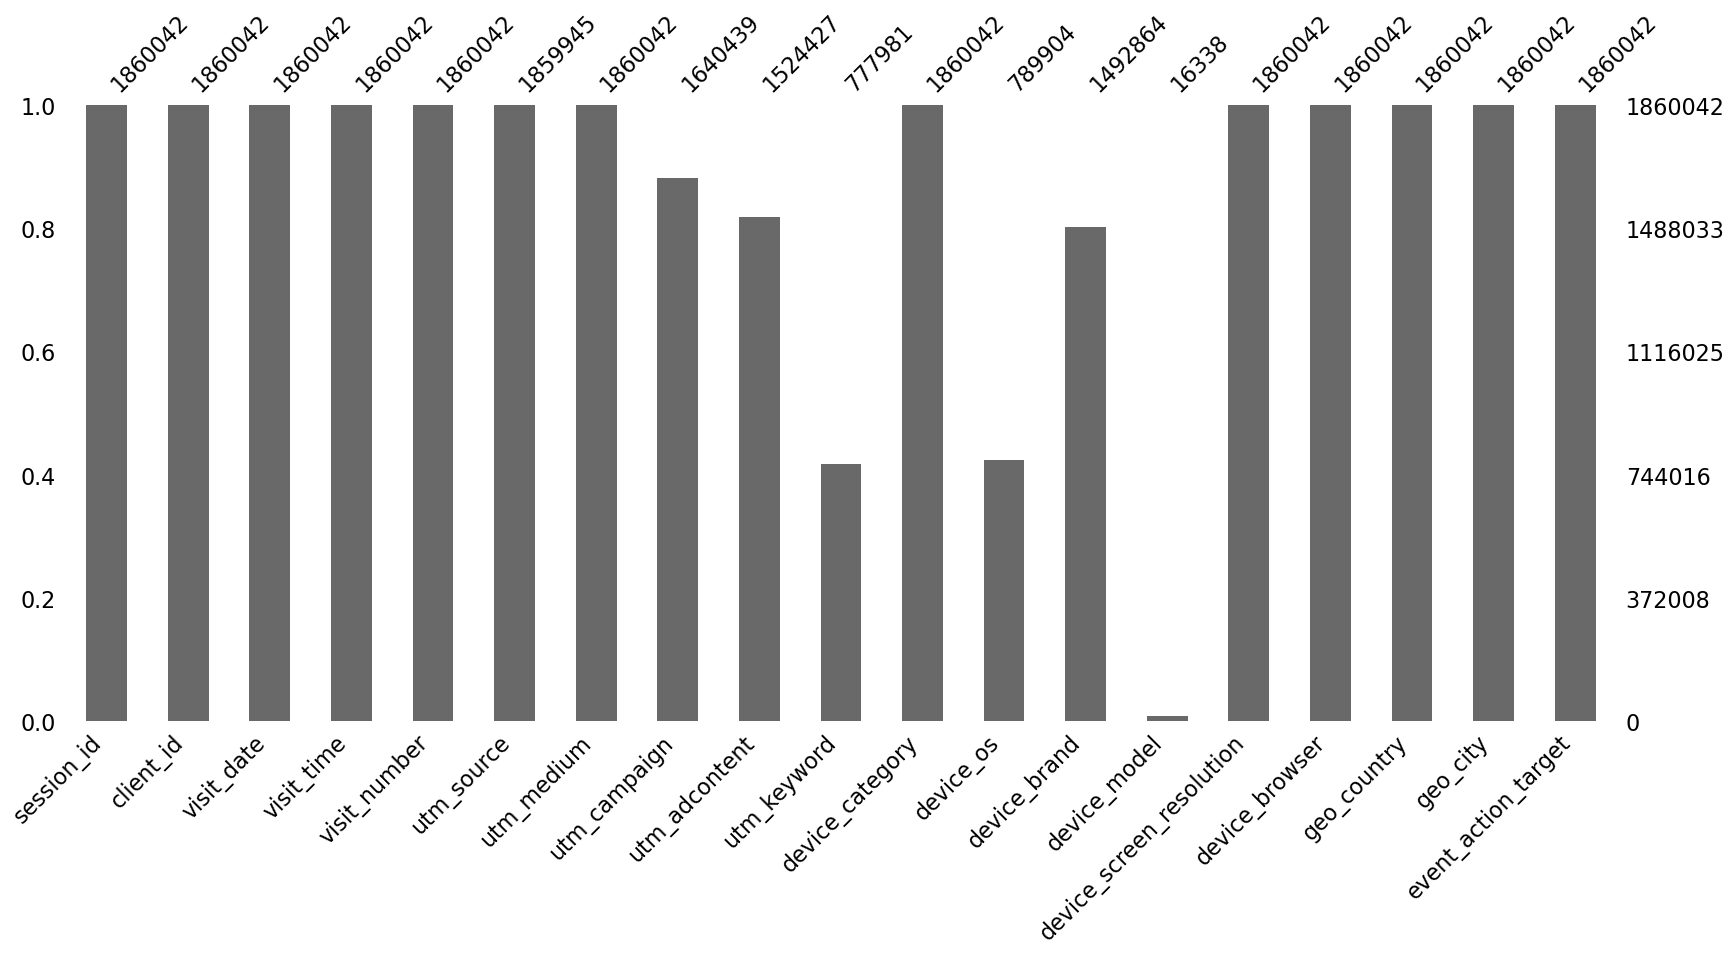

In [33]:
# great, we don't have duplicated rows. Now we can check missings
msno.bar(df, figsize=(20, 8))

In [34]:
# define functions to show share of missings for each column
def show_missings(data):
    return ((data.isna() / len(data)) * 100).sum().sort_values(ascending=False)

In [35]:
# we have columns which can potentially be removed from df because huge part of its content is missing (more than 20%). 
df_missings = show_missings(df)

In [36]:
# Here are they:
df_missings

device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_action_target          0.000000
dtype: float64

In [37]:
# let us look at those columns with a lot of missing values. E.g. device_model can be removed because we can't restore it from the other data. But device_os potentially can be restored from
# device_brand and device_category columns. But we have to check other non-obvious columns like utm_keyword e.t.c
df[df['utm_keyword'].notna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
6,9055455318486370642.1640843788.1640843788,2108387490.164084,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg,0.0
8,9055462349345527315.1638536723.1638536723,2108389127.163854,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860036,9055401700113249881.1639446112.1639446112,2108375006.163945,2021-12-14,04:41:52,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,ZTE,NaN,360x640,Chrome,Russia,Blagoveshchensk,0.0
1860037,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0.0
1860039,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0.0
1860040,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0.0


In [38]:
# let's check if utm_keyword can be restored from utm_adcontent. We are going to compare if utm_adcontent most frequent value (from above) and utm_keyword col unique values correlate a bit.
df[df['utm_adcontent'] == 'JNHcPlZPxEMWDnRiyoBf']['utm_keyword'].nunique()

248

In [39]:
# as we can see we have 248 unique values in utm_keyword col in case utm_adcontent is filtered by top value. It says that keyword may vastly vary if we consider ad content, we can't just impute with top value
# also we can check device_os col because it potentially can be restored. First of all let's see uniques
df['device_os'].unique()

array(['Android', nan, 'iOS', 'Windows', 'Linux', 'Macintosh',
       '(not set)', 'Chrome OS', 'BlackBerry', 'Tizen', 'Firefox OS',
       'Samsung', 'Windows Phone', 'Nokia'], dtype=object)

In [40]:
# it's not usual division by android and ios e.t.c. In this case we won't restore this column. Too many rows are missing and data is very specific. 
# usually we might have 20% boundary of missing values. If more than 20% of data is missing, column can be deleted. Let's simply take 20% in this dataset as well.
# also we drop client_id because it's irrelevant
cols_to_drop = df_missings[df_missings > 20].index.to_list()
cols_to_drop.append('client_id')

In [41]:
cols_to_drop

['device_model', 'utm_keyword', 'device_os', 'client_id']

In [42]:
df_clean = df.drop(columns=cols_to_drop)

In [43]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0


In [44]:
df_clean.shape

(1860042, 15)

In [45]:
# now we are going to see how many useful rows we have. 

In [46]:
def useful_rows(df):
    print(f'Rows fulfilled: {len(df.dropna())}')
    print(f'Share of rows fulfilled: {round(len(df.dropna()) / len(df) * 100, 2)}')

In [47]:
useful_rows(df_clean)

Rows fulfilled: 1230859
Share of rows fulfilled: 66.17


In [48]:
# we have low share of rows fulfilled. Let us see again how many rows are missing for each column
show_missings(df_clean)

device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
session_id                   0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
event_action_target          0.000000
dtype: float64

In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   visit_date                object 
 2   visit_time                object 
 3   visit_number              int64  
 4   utm_source                object 
 5   utm_medium                object 
 6   utm_campaign              object 
 7   utm_adcontent             object 
 8   device_category           object 
 9   device_brand              object 
 10  device_screen_resolution  object 
 11  device_browser            object 
 12  geo_country               object 
 13  geo_city                  object 
 14  event_action_target       float64
dtypes: float64(1), int64(1), object(13)
memory usage: 212.9+ MB


In [50]:
# let's impute all the columns with most frequent values accordingly. We have only object type missing values columns
cat_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['object', 'categorical']]

In [51]:
print(cat_cols)

['session_id', 'visit_date', 'visit_time', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']


In [52]:
df_clean[cat_cols] = df_clean[cat_cols].fillna(df_clean[cat_cols].mode().iloc[0])

In [53]:
df_clean.isna().sum()

session_id                  0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
event_action_target         0
dtype: int64

In [54]:
df_clean

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Apple,1920x1080,Chrome,Russia,Moscow,0.0
1860038,9055421130527858185.1622007305.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari,Russia,Stavropol,0.0
1860039,9055422955903931195.1636979515.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,0.0
1860040,905543020766873816.1638189404.1638189404,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0.0


### Outliers handling

In [55]:
df_clean.describe(include='all')

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
count,1860042,1860042,1860042,1.860042e+06,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1.860042e+06
unique,1860042,226,85318,NaN,293,56,412,286,3,205,5039,57,166,2548,NaN
top,9055434745589932991.1637753792.1637753792,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x896,Chrome,Russia,Moscow,NaN
freq,1,39453,61067,NaN,578387,552272,683084,1342214,1474871,918266,169090,1013436,1800565,805329,NaN
mean,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.704993e-02
std,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.622290e-01
min,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


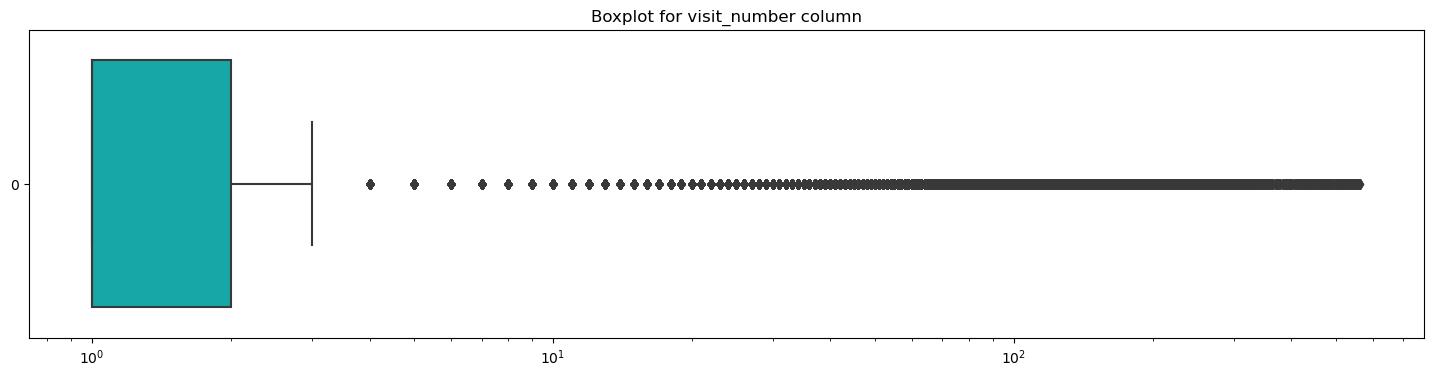

In [56]:
# We want to know if we have outliers in our numerical columns. We can start with visualization
plt.figure(figsize=(18,4))
plt.title('Boxplot for visit_number column')
sns.boxplot(df_clean.visit_number, color='c', orient='h').set_xscale('log')

In [57]:
# as we see there are outliers in visit_number column.

In [58]:
# let's remove outliers in our numerical column
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame: #define function so it can take DF and return DF
    def calc_outliers(data):
        q25 = data.quantile(0.25) # take quantiles of data
        q75 = data.quantile(0.75)
        iqr = q75 - q25 # save median
        bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr) # return boundaries tuple
        return bounds
    
    df = df.copy() #make copy so everything can be safe
    boundaries = calc_outliers(df['visit_number'])
    df.loc[df['visit_number'] < boundaries[0], 'visit_number'] = round(boundaries[0]) # limit outliers within boundaries
    df.loc[df['visit_number'] > boundaries[1], 'visit_number'] = round(boundaries[1])
    
    return df
    

In [59]:
df_clean = remove_outliers(df_clean)

In [60]:
# Let's check if we've done everything right
print(f"Max value for visit_number column after removing outliers: {df_clean['visit_number'].max()}. Min value for visit_number column after removing outliers: {df_clean['visit_number'].min()}.")

Max value for visit_number column after removing outliers: 4. Min value for visit_number column after removing outliers: 1.


### Types handling

In [61]:
# Now we can define correct dtypes. We can start with date
df_clean['visit_date'] = pd.to_datetime(df_clean['visit_date'])

In [62]:
df_clean['visit_date'].dt.year

0          2021
1          2021
2          2021
3          2021
4          2021
           ... 
1860037    2021
1860038    2021
1860039    2021
1860040    2021
1860041    2021
Name: visit_date, Length: 1860042, dtype: int32

In [63]:
# continue with time, we want to leave only hours.
df_clean['visit_time'] = pd.to_datetime(df_clean['visit_time']).dt.hour

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/1823351687.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['visit_time'] = pd.to_datetime(df_clean['visit_time']).dt.hour


In [64]:
df_clean['visit_time']

0          14
1           8
2           2
3           5
4           5
           ..
1860037    10
1860038     8
1860039    15
1860040    15
1860041    19
Name: visit_time, Length: 1860042, dtype: int32

In [65]:
# great, we can create new features from these updated columns dtypes. We have device_category column which includes only 3 categories. We can update dtype into categorical
df_clean['device_category'] = df_clean['device_category'].astype('category')

In [66]:
# also target var has to be changed from float to int
df_clean['event_action_target'] = df_clean['event_action_target'].astype('int32')

In [67]:
print(df_clean.shape)
df_clean.head()

(1860042, 15)


,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [68]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   visit_date                datetime64[ns]
 2   visit_time                int32         
 3   visit_number              int64         
 4   utm_source                object        
 5   utm_medium                object        
 6   utm_campaign              object        
 7   utm_adcontent             object        
 8   device_category           category      
 9   device_brand              object        
 10  device_screen_resolution  object        
 11  device_browser            object        
 12  geo_country               object        
 13  geo_city                  object        
 14  event_action_target       int32         
dtypes: category(1), datetime64[ns](1), int32(2), int64(1), object(10)
memory usage: 186.3+ MB


In [69]:
# great! Now we can move on to creating new features

## Feature engineering

### Creating new features

In [70]:
# have a look at all columns one more time
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [71]:
# start with visit_date column.
print(f"Year for visit_date column: {df_clean['visit_date'].dt.year.unique()}")

Year for visit_date column: [2021]


In [72]:
# ok, it means that we can throw year feature. We can't use it because it has only one unique value.
print(f"Month uniques for visit_date column: {df_clean['visit_date'].dt.month.unique()}")

Month uniques for visit_date column: [11 12  5  7  6  8 10  9]


In [73]:
# we have only half + 1 month a year. Alright, it means we are working with only three seasons which will lead to model not proper working during spring season. 
print(f"Days uniques for visit_date column: {df_clean['visit_date'].dt.weekday.unique()}")

Days uniques for visit_date column: [2 6 1 5 0 3 4]


In [74]:
# we are working with dates. I want to create new features from visit_date column then
df_clean['month_visit'] = df_clean['visit_date'].dt.month
df_clean['weekday_visit'] = df_clean['visit_date'].dt.weekday
df_clean['day_visit'] = df_clean['visit_date'].dt.day

In [75]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,11,2,24
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,11,6,14
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,12,1,28
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,5,5,29
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,5,5,29


In [76]:
df_clean.visit_time.unique()

array([14,  8,  2,  5, 12, 19, 16,  9, 22, 20, 21, 18,  6, 13, 15, 17,  7,
       23,  0, 11,  4,  1, 10,  3], dtype=int32)

In [77]:
# we can create new column from visit_time like this: from 5 AM to 12 it will be morning, from 12 till 18 - daytime, 18-23: evening, 0-5: night. 

bins = [0, 5, 12, 18, 23]
labels = ['night', 'morning', 'day', 'evening']

df_clean['daytime'] = pd.cut(df_clean['visit_time'], bins=bins, labels=labels, right=False)

In [78]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,11,2,24,day
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,11,6,14,morning
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,12,1,28,night
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,5,5,29,morning
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,5,5,29,morning


In [79]:
# looks like we did everything right. Check what we can do with utm_medium column. Other utm columns seems ok for us
df_clean.utm_medium.unique()

array(['banner', 'cpm', 'cpc', 'organic', '(none)', 'referral', 'smm',
       'stories', 'blogger_channel', 'blogger_stories', 'email', 'app',
       'vk_smm', 'cpv', 'push', 'partner', 'tg', 'cpa', 'post',
       'smartbanner', 'info_text', 'outlook', 'clicks', 'landing',
       'blogger_header', 'qr', '(not set)', 'fb_smm', 'nkp', 'google_cpc',
       'sms', 'article', 'users_msk', 'static', 'ok_smm', 'cbaafe',
       'Sbol_catalog', 'landing_interests', 'yandex_cpc', 'web_polka',
       'linktest', 'sber_app', 'CPM', 'medium', 'tablet', 'promo_sbol',
       'reach', 'desktop', 'dom_click', 'social', 'catalogue',
       'main_polka', 'last', 'link', 'qrcodevideo', 'promo_sber'],
      dtype=object)

In [80]:
# we need to delete unnecessary paranthesis and make text lower
df_clean['utm_medium'] = df_clean['utm_medium'].str.replace(r'\(|\)', '', regex=True).str.lower().str.replace(' ', '_')

In [81]:
df_clean.utm_medium.unique()

array(['banner', 'cpm', 'cpc', 'organic', 'none', 'referral', 'smm',
       'stories', 'blogger_channel', 'blogger_stories', 'email', 'app',
       'vk_smm', 'cpv', 'push', 'partner', 'tg', 'cpa', 'post',
       'smartbanner', 'info_text', 'outlook', 'clicks', 'landing',
       'blogger_header', 'qr', 'not_set', 'fb_smm', 'nkp', 'google_cpc',
       'sms', 'article', 'users_msk', 'static', 'ok_smm', 'cbaafe',
       'sbol_catalog', 'landing_interests', 'yandex_cpc', 'web_polka',
       'linktest', 'sber_app', 'medium', 'tablet', 'promo_sbol', 'reach',
       'desktop', 'dom_click', 'social', 'catalogue', 'main_polka',
       'last', 'link', 'qrcodevideo', 'promo_sber'], dtype=object)

In [82]:
# now it's done. We are going further
df_clean['device_brand'].unique()

array(['Huawei', 'Samsung', 'Xiaomi', 'Apple', 'Lenovo', 'Vivo', 'Meizu',
       'OnePlus', '(not set)', 'BQ', 'Realme', 'OPPO', 'itel', 'Philips',
       'Nokia', 'Alcatel', 'LG', 'Tecno', 'Asus', 'Infinix', 'Sony',
       'ZTE', 'Wiko', 'Google', 'Micromax', 'Blackview', 'Oukitel',
       'Wileyfox', 'Motorola', 'HOMTOM', 'Cubot', 'DOOGEE', 'China Phone',
       'DEXP', 'Neffos', 'TP-Link', 'Hisense', 'Acer', 'Vsmart',
       'BlackBerry', 'Umidigi', 'Leagoo', 'Highscreen', 'Ulefone', 'HTC',
       'Symphony', 'LeEco', 'Prestigio', 'POCO', 'Vestel', 'Guophone',
       'Vertex', 'CAT', 'InFocus', 'TCL', 'SonyEricsson', 'Inoi', 'Nomu',
       'Sharp', 'Jiake', 'ZOJI', 'Yuntab', 'Mozilla', 'Vernee', 'Tele2',
       'H96', 'Kyocera', 'Karbonn', 'BLU', 'Haier', 'Kingplay', 'Coolpad',
       'MTC', 'LeTV', 'iNew', 'A1', 'Gionee', 'General Mobile', 'Digma',
       'Yota Devices', 'Gome', 'Egreat', 'Kata', 'Mito', 'Poptel',
       'Flylion', 'AGM', 'SenseIT', 'Archos', 'Teclast', 'Fly', 'MLS

In [83]:
# let's do the same
df_clean['device_brand'] = df_clean['device_brand'].str.replace(r'\(|\)', '', regex=True).str.lower().str.replace(' ', '_')

In [84]:
# go to next one
df_clean['device_screen_resolution'].nunique()

5039

In [85]:
# too many screen resolution unique values. We can divide them by two columns like width and height for better further scaling
df_clean['width_res'] = df_clean['device_screen_resolution'].str.split('x').str[0]
df_clean['height_res'] = df_clean['device_screen_resolution'].str.split('x').str[1]

In [86]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,...,device_browser,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,...,Chrome,Russia,Zlatoust,0,11,2,24,day,360,720
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,samsung,...,Samsung Internet,Russia,Moscow,0,11,6,14,morning,385,854
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,...,Chrome,Russia,Krasnoyarsk,0,12,1,28,night,360,720
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,xiaomi,...,Chrome,Russia,Moscow,0,5,5,29,morning,393,786
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,...,Chrome,Russia,Moscow,0,5,5,29,morning,393,786


In [87]:
# we have some bad values which are interrupting our astype method. Let us fill them with more relevant
df_clean.loc[df_clean['width_res'] == '(not set)', 'width_res'] = df_clean['width_res'].mode().iloc[0]

In [88]:
df_clean['height_res'].isna().sum()

8

In [89]:
df_clean['height_res'] = df_clean['height_res'].fillna(df_clean['height_res'].mode().iloc[0])

In [90]:
# great, now our OHE won't spread unnecessary 4947 columns. Now these new columns can be scaled.
df_clean = df_clean.drop(columns=['device_screen_resolution'])
df_clean['width_res'] = df_clean['width_res'].astype('int32')
df_clean['height_res'] = df_clean['height_res'].astype('int32')

In [91]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_browser,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,Chrome,Russia,Zlatoust,0,11,2,24,day,360,720
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,samsung,Samsung Internet,Russia,Moscow,0,11,6,14,morning,385,854
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,Chrome,Russia,Krasnoyarsk,0,12,1,28,night,360,720
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,xiaomi,Chrome,Russia,Moscow,0,5,5,29,morning,393,786
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,Chrome,Russia,Moscow,0,5,5,29,morning,393,786


In [92]:
df_clean['device_browser'].unique()

array(['Chrome', 'Samsung Internet', 'Safari', 'YaBrowser',
       'Android Webview', 'Safari (in-app)', 'Opera', 'Firefox', 'Edge',
       'helloworld', 'Instagram 208.0.0.32.135 Android',
       'Instagram 209.0.0.21.119 Android', 'Android Runtime',
       'UC Browser', 'Mozilla Compatible Agent', '(not set)', 'Mozilla',
       'Opera Mini', 'Coc Coc', 'Instagram 213.0.0.29.120 Android',
       'Android', 'Instagram 216.1.0.21.137 Android', '[FBAN',
       'Internet Explorer', 'Puffin', 'MRCHROME', 'com.vk.vkclient',
       'Instagram 202.0.0.23.119', 'Android Browser', 'Maxthon',
       'Instagram 207.0.0.28.118', 'Instagram 216.0.0.12.135',
       'Instagram 199.1.0.34.119 Android', 'Instagram 192.0.0.37.119',
       'Amazon Silk', 'SeaMonkey', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 An

In [93]:
# too many almost equal values, we can make it shorter.
df_clean['short_browser'] = df_clean['device_browser'].str.replace(r'\(|\)', '', regex=True).str.lower().str.split(' ').str[0]

In [94]:
df_clean.short_browser.unique()

array(['chrome', 'samsung', 'safari', 'yabrowser', 'android', 'opera',
       'firefox', 'edge', 'helloworld', 'instagram', 'uc', 'mozilla',
       'not', 'coc', '[fban', 'internet', 'puffin', 'mrchrome',
       'com.vk.vkclient', 'maxthon', 'amazon', 'seamonkey', 'myapp',
       'netfront', 'mt6735_td', 'nokiax2-02', 'nokia501', 'phantom',
       'com.zhiliaoapp.musically', 'konqueror', 'iron', 'threads'],
      dtype=object)

In [95]:
# we made it shorter, drop root column. 
df_clean = df_clean.drop('device_browser', axis=1)

In [96]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res,short_browser
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,Russia,Zlatoust,0,11,2,24,day,360,720,chrome
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,samsung,Russia,Moscow,0,11,6,14,morning,385,854,samsung
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,Russia,Krasnoyarsk,0,12,1,28,night,360,720,chrome
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,xiaomi,Russia,Moscow,0,5,5,29,morning,393,786,chrome
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,Russia,Moscow,0,5,5,29,morning,393,786,chrome


In [97]:
df_clean['geo_country'].unique()

array(['Russia', 'United States', 'Ukraine', 'Italy', 'Belarus',
       '(not set)', 'Sweden', 'Australia', 'Kazakhstan', 'Estonia',
       'Azerbaijan', 'Brazil', 'Montenegro', 'Bulgaria', 'Georgia',
       'Uzbekistan', 'Tajikistan', 'Ireland', 'Cyprus',
       'United Arab Emirates', 'Germany', 'United Kingdom', 'Netherlands',
       'Armenia', 'Spain', 'Finland', 'Turkey', 'Poland', 'Kyrgyzstan',
       'Serbia', 'India', 'Bangladesh', 'Latvia', 'Seychelles', 'Norway',
       'Moldova', 'Argentina', 'Guatemala', 'Lithuania', 'Iraq', 'Canada',
       'Greece', 'Antigua & Barbuda', 'France', 'Slovakia', 'Palestine',
       'Saudi Arabia', 'Iran', 'Czechia', 'Austria', 'Singapore',
       'Indonesia', 'Dominican Republic', 'Denmark', 'Albania',
       'Switzerland', 'China', 'Portugal', 'Israel', 'Hungary',
       'Slovenia', 'Iceland', 'Maldives', 'Mexico', 'Wallis & Futuna',
       'Egypt', 'Guadeloupe', 'South Korea', 'Uganda',
       'Bosnia & Herzegovina', 'Thailand', 'Romania', 

In [98]:
# we could make it shorter, but it will lead to mixing between such names like United States, United Kingdom and United Arab Emirates. So we can just make it lower and align with '_'
df_clean['geo_country'] = df_clean['geo_country'].str.replace(r'\(|\)', '', regex=True).str.lower().str.replace(' ', '_')

In [99]:
df_clean.head()

,session_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res,short_browser
0,9055434745589932991.1637753792.1637753792,2021-11-24,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,Zlatoust,0,11,2,24,day,360,720,chrome
1,905544597018549464.1636867290.1636867290,2021-11-14,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,samsung,russia,Moscow,0,11,6,14,morning,385,854,samsung
2,9055446045651783499.1640648526.1640648526,2021-12-28,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,Krasnoyarsk,0,12,1,28,night,360,720,chrome
3,9055447046360770272.1622255328.1622255328,2021-05-29,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,xiaomi,russia,Moscow,0,5,5,29,morning,393,786,chrome
4,9055447046360770272.1622255345.1622255345,2021-05-29,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,russia,Moscow,0,5,5,29,morning,393,786,chrome


In [100]:
df_clean['geo_city'] = df_clean['geo_city'].str.replace(r'\(|\)', '', regex=True).str.lower().str.replace(' ', '_')

In [101]:
# we need to delete date column
df_clean = df_clean.drop(columns='visit_date')

In [102]:
df_clean.head()

,session_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res,short_browser
0,9055434745589932991.1637753792.1637753792,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,zlatoust,0,11,2,24,day,360,720,chrome
1,905544597018549464.1636867290.1636867290,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,samsung,russia,moscow,0,11,6,14,morning,385,854,samsung
2,9055446045651783499.1640648526.1640648526,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,krasnoyarsk,0,12,1,28,night,360,720,chrome
3,9055447046360770272.1622255328.1622255328,5,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,xiaomi,russia,moscow,0,5,5,29,morning,393,786,chrome
4,9055447046360770272.1622255345.1622255345,5,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,russia,moscow,0,5,5,29,morning,393,786,chrome


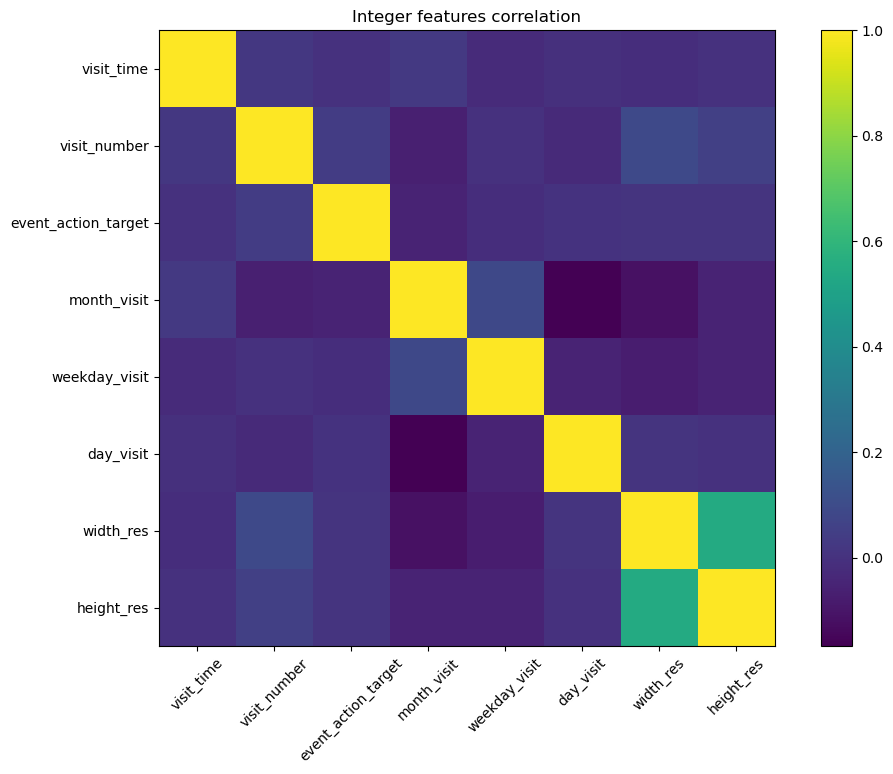

In [103]:
# Now we'll show corr heatmap
# Create numerical_cols var. It will help us with heatmap creating.
numerical_cols = [col for col in df_clean.columns if df_clean[col].dtypes 
                  in ['int32', 'int64', 'float64', 'float32']]

plt.figure(figsize=(12,8))

columns = df_clean[numerical_cols].corr().columns.tolist()
plt.imshow(df_clean[numerical_cols].corr())

plt.title('Integer features correlation')
plt.xticks(range(0, len(columns)), columns, rotation=45)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show();

In [104]:
# we see good correlation between width_res and height_res of course, it's obvious. Unusual is corr between visit_number and width_res for example. But still it's small. Other correlations are not significant

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


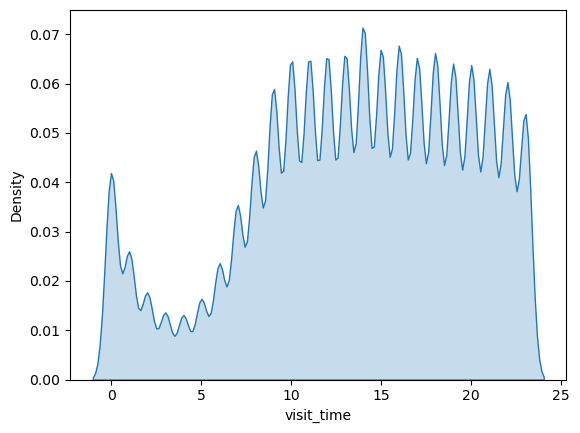

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


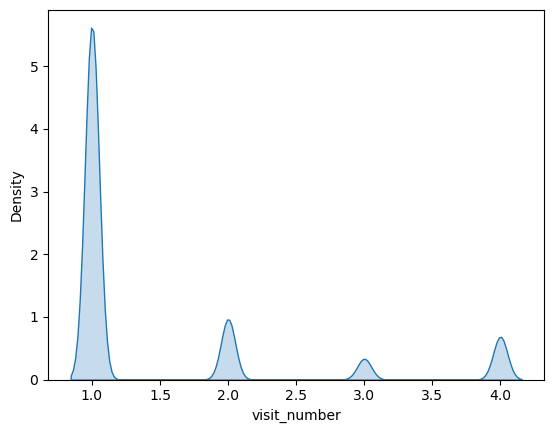

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


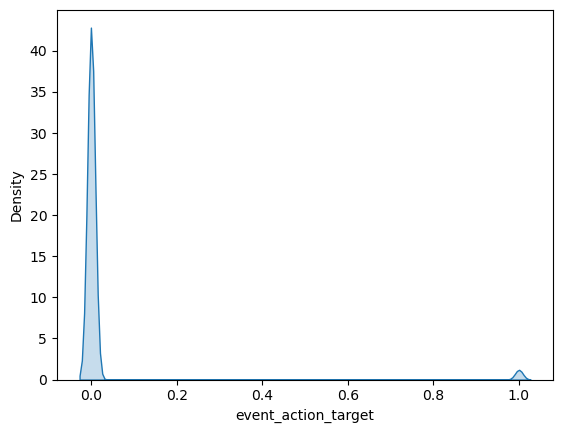

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


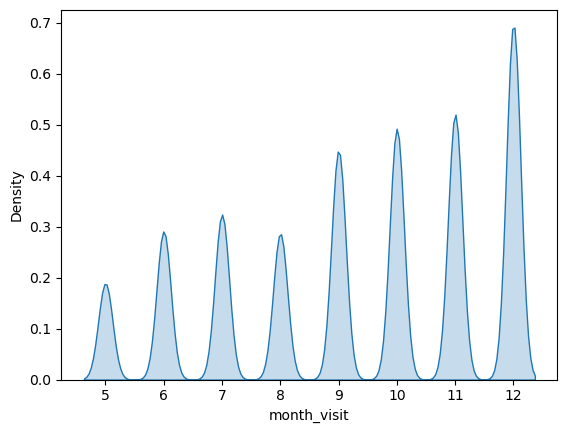

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


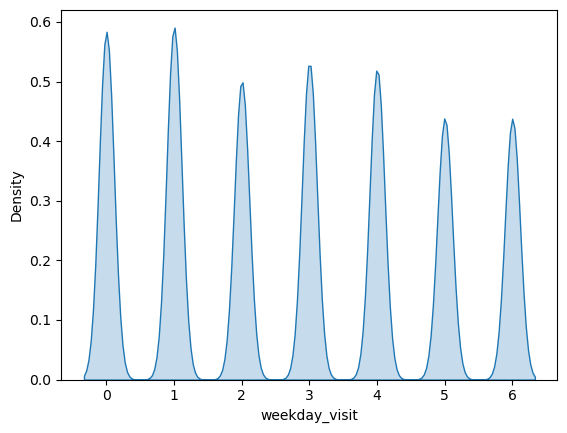

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


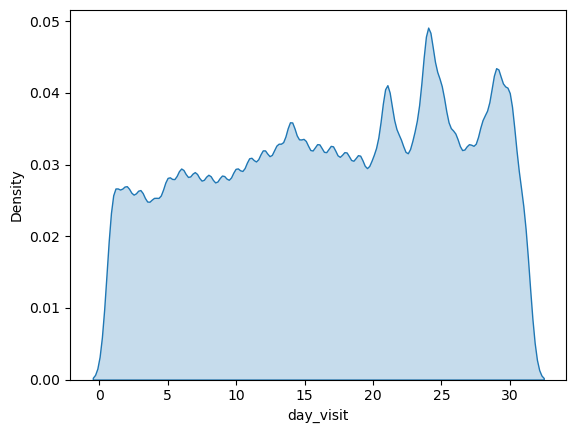

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


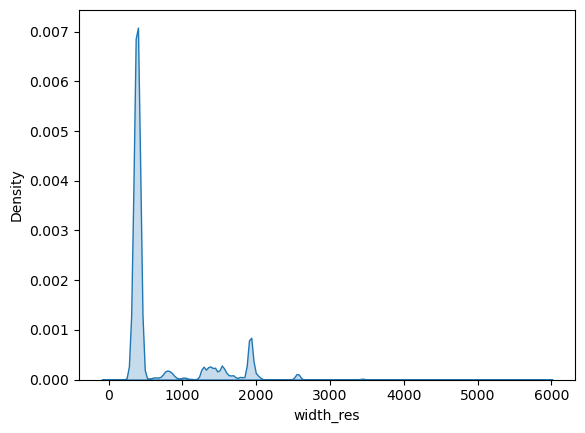

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_57200/3833553986.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_clean[col], fill=True, palette='crest')


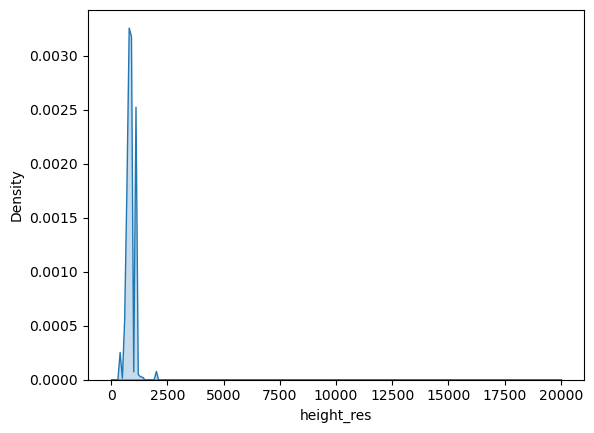

In [105]:
# after EDA and creating new features we want to see the distribution of main parameters.
for col in df_clean[numerical_cols].columns:
        sns.kdeplot(data=df_clean[col], fill=True, palette='crest')
        plt.show()

### OneHotEncoding

We decided to use OneHotEncoder because two other popular solutions such as 1) dropping categorical variables and 2) ordinal encoding are not applicable in our case. 1st approach could lead to missing a lot of important data and 2nd approach could be well used with those columns with dtype 'category', because their unique values don't vary a lot. 
For other 'object' dtype columns this approach could create a lot of unique values inside of one column which doesn't seem to be convenient. 

In [106]:
# First of all we should check types for numerical and categorical columns division.
df_clean.dtypes

session_id               object
visit_time                int32
visit_number              int64
utm_source               object
utm_medium               object
utm_campaign             object
utm_adcontent            object
device_category        category
device_brand             object
geo_country              object
geo_city                 object
event_action_target       int32
month_visit               int32
weekday_visit             int32
day_visit                 int32
daytime                category
width_res                 int32
height_res                int32
short_browser            object
dtype: object

In [107]:
# before appling OHE we need to make a dataframe smaller. Now it's very big and our attempts to work with huge df 
# will only lead to kernel fall. We will use tecnhique called downsampling. Also it will affect ROC-AUC results in 
# better way, because imbalanced dataset at target var will be closer to the target.
target_samples = df_clean[df_clean['event_action_target'] == 1]
other_samples = df_clean[df_clean['event_action_target'] == 0]

target_count = len(target_samples)

downsampled = resample(other_samples, replace=False, n_samples=target_count, random_state=42)

df_clean_reduced = pd.concat([downsampled, target_samples])

In [108]:
# divide columns by categorical and numerical, exclude target: event_action 
numerical_cols = [col for col in df_clean_reduced.columns if df_clean_reduced[col].dtypes 
                  in ['int32', 'int64', 'float64', 'float32'] and col != 'event_action_target']
categorical_cols = [col for col in df_clean_reduced.columns if df_clean_reduced[col].dtypes
                    in ['object', 'category'] and col != 'session_id']

In [109]:
# initialize variable with categorical types columns df for ohe purposes
ohe_df = df_clean_reduced[categorical_cols]

In [110]:
ohe_df.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_country,geo_city,daytime,short_browser
1016929,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,xiaomi,russia,krasnodar,evening,chrome
70282,fDLlAcSmythWSCVMvqvL,none,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,apple,russia,lipetsk,day,yabrowser
1456683,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,xiaomi,russia,nalchik,day,chrome
140234,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,nizhny_novgorod,evening,chrome
591414,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,samsung,russia,samara,evening,chrome


In [111]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [112]:
# fit ohe to df
ohe.fit(ohe_df)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [113]:
# save transformed df into variable
encoded_data = ohe.transform(ohe_df)
# print matrix and its shape
print(encoded_data, 'Shape:', encoded_data.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Shape: (100628, 1685)


In [114]:
# save feature names for further columns naming
new_feature_names = ohe.get_feature_names_out()

In [115]:
new_feature_names

array(['utm_source_ANoZJgYuPrWNkAAchryx',
       'utm_source_ArbfvYgWhqxkzywKqpQf',
       'utm_source_BHcvLfOaCWvWTykYqHVe', ..., 'short_browser_seamonkey',
       'short_browser_uc', 'short_browser_yabrowser'], dtype=object)

In [116]:
# we have to reset indices in df_clean because ohe indices are numbered sequentially, but in df_clean indices are individual because of missing values deletion 
df_clean_ind_reset = df_clean_reduced.reset_index(drop=True)

In [117]:
df_clean_ind_reset

,session_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_country,geo_city,event_action_target,month_visit,weekday_visit,day_visit,daytime,width_res,height_res,short_browser
0,5295203187317877860.1637428326.1637428326,20,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,xiaomi,russia,krasnodar,0,11,5,20,evening,393,851,chrome
1,1066603778969840215.1637317857.1637317857,13,4,fDLlAcSmythWSCVMvqvL,none,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,apple,russia,lipetsk,0,11,4,19,day,1440,900,yabrowser
2,7259421684605595238.1638870630.1638870630,12,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,xiaomi,russia,nalchik,0,12,1,7,day,393,851,chrome
3,1382436668688804700.1638640469.1638640469,20,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,huawei,russia,nizhny_novgorod,0,12,5,4,evening,320,712,chrome
4,3397931358881976478.1632764535.1632764535,20,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,samsung,russia,samara,0,9,0,27,evening,384,854,chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100623,9054912872702758664.1636781836.1636781836,8,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,mobile,xiaomi,russia,moscow,1,11,5,13,morning,360,800,chrome
100624,9055248417020050011.1634073188.1634073188,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,mobile,huawei,russia,nizhny_novgorod,1,10,2,13,night,360,780,chrome
100625,9055248417020050011.1634075541.1634075541,0,3,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,mobile,huawei,russia,nizhny_novgorod,1,10,2,13,night,360,780,chrome
100626,9055376699099939975.1630766214.1630766214,17,1,fDLlAcSmythWSCVMvqvL,none,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,apple,russia,khimki,1,9,5,4,day,1920,1080,chrome


In [118]:
df_encoded_cat = pd.DataFrame(encoded_data, columns=new_feature_names)

In [119]:
df_encoded_cat.head()

,utm_source_ANoZJgYuPrWNkAAchryx,utm_source_ArbfvYgWhqxkzywKqpQf,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_CFeqZLBNQdYHxJrTOHjY,utm_source_CgsxHpdTmXHvrHqEKRxp,utm_source_CqeIpFwJscTsZoYXdHsP,utm_source_DlnuGwaJBHGNEKdWfOpe,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_DnxUhHWInKVDAWzwROOC,...,short_browser_mozilla,short_browser_mrchrome,short_browser_not,short_browser_opera,short_browser_puffin,short_browser_safari,short_browser_samsung,short_browser_seamonkey,short_browser_uc,short_browser_yabrowser
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
df_new = pd.concat([df_clean_ind_reset, df_encoded_cat], axis=1)

### Numeric data scaling

In [121]:
# initialize StandardScaler and save df with numeric columns in std_data
std_scaler = StandardScaler()
std_data = df_new[numerical_cols]

In [122]:
# fit std_scaler to data
std_scaler.fit(std_data)

StandardScaler()

In [123]:
# transform data and print its matrix and shape
scaled_data = std_scaler.transform(std_data)
print(scaled_data, 'Shape:', scaled_data.shape)

[[ 1.05960283 -0.58093505  0.87383156 ...  0.33806718 -0.49344244
   0.03661553]
 [-0.10094915  2.34813262  0.87383156 ...  0.22501261  1.37976352
   0.33935181]
 [-0.2667423  -0.58093505  1.30827566 ... -1.13164222 -0.49344244
   0.03661553]
 ...
 [-2.25625999  1.37177673  0.43938745 ... -0.45331481 -0.55248332
  -0.40204316]
 [ 0.56222341 -0.58093505  0.00494334 ... -1.47080593  2.23853989
   1.45144426]
 [ 1.05960283 -0.58093505 -0.42950077 ...  0.90334003 -0.55248332
  -0.27847733]] Shape: (100628, 7)


In [124]:
# create cols names for naming scaled data
scaled_cols = [col + '_std' for col in numerical_cols]
scaled_cols

['visit_time_std',
 'visit_number_std',
 'month_visit_std',
 'weekday_visit_std',
 'day_visit_std',
 'width_res_std',
 'height_res_std']

In [125]:
# add scaled data to df_new
df_new[scaled_cols] = scaled_data

In [126]:
# drop unnecessary columns which were used to OHE and scaling
df_new = df_new.drop(columns=numerical_cols + categorical_cols)

In [127]:
# check that we've done everything right
df_new.tail()

,session_id,event_action_target,utm_source_ANoZJgYuPrWNkAAchryx,utm_source_ArbfvYgWhqxkzywKqpQf,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_CFeqZLBNQdYHxJrTOHjY,utm_source_CgsxHpdTmXHvrHqEKRxp,utm_source_CqeIpFwJscTsZoYXdHsP,utm_source_DlnuGwaJBHGNEKdWfOpe,...,short_browser_seamonkey,short_browser_uc,short_browser_yabrowser,visit_time_std,visit_number_std,month_visit_std,weekday_visit_std,day_visit_std,width_res_std,height_res_std
100623,9054912872702758664.1636781836.1636781836,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.929915,-0.580935,0.873832,1.149185,-0.453315,-0.552483,-0.278477
100624,9055248417020050011.1634073188.1634073188,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.256260,-0.580935,0.439387,-0.359179,-0.453315,-0.552483,-0.402043
100625,9055248417020050011.1634075541.1634075541,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.256260,1.371777,0.439387,-0.359179,-0.453315,-0.552483,-0.402043
100626,9055376699099939975.1630766214.1630766214,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.562223,-0.580935,0.004943,1.149185,-1.470806,2.238540,1.451444
100627,9055394269810294140.1629912447.1629912447,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.059603,-0.580935,-0.429501,-0.359179,0.903340,-0.552483,-0.278477


In [128]:
# save file for further modelling
df_new.to_csv('df_final.csv')

## Modelling

Sklearn advices to use LinearSVC, Ensemble models, classic SVC and KNeighbors classifiers when your data shape[0] is lower than 100k samples. We have just about 100k samples - slightly more, so we will also apply their recommendation to use SGD classifier for cases with more than 100k samples. 
We are going to use four most promising (IMAO) models: 
1. Catboost. It has a great visualization opportunities and convenient customizable params and methods. Also boosting is known as one of the most accurate model, but it can overfit sometimes. Only neural nets could be better but slower, in my opinion.
2. Random Forest. This model is almost as accurate as catboost but it is impossible to overfit it.
3. Logistic Regression. Sometimes logreg can show good results even without tuning.
4. LinearSVC. In my experience SVC shows better result than random forest but it fits slowly. LinearSVC should be much faster but closer to classic SVC results.

In [129]:
# train test split
X = df_new.drop(['event_action_target', 'session_id'], axis=1)
y = df_new.event_action_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### CatBoost

In [130]:
# define catboost with eval_metric as 'AUC' so it can fit to our demands
catboost_v1 = CatBoostClassifier(random_state=42, eval_metric='AUC')

In [131]:
# fit the model with plot=True, because we want to see loss curve as well. Also we give the model eval_set
catboost_v1.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True, verbose=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.093679
0:	test: 0.6601738	best: 0.6601738 (0)	total: 132ms	remaining: 2m 11s
20:	test: 0.6875178	best: 0.6875178 (20)	total: 372ms	remaining: 17.4s
40:	test: 0.6955978	best: 0.6955978 (40)	total: 611ms	remaining: 14.3s
60:	test: 0.7006469	best: 0.7006469 (60)	total: 845ms	remaining: 13s
80:	test: 0.7035740	best: 0.7035740 (80)	total: 1.13s	remaining: 12.8s
100:	test: 0.7058341	best: 0.7058341 (100)	total: 1.39s	remaining: 12.4s
120:	test: 0.7079626	best: 0.7079626 (120)	total: 1.67s	remaining: 12.1s
140:	test: 0.7095082	best: 0.7095423 (139)	total: 1.91s	remaining: 11.6s
160:	test: 0.7105868	best: 0.7105868 (160)	total: 2.16s	remaining: 11.2s
180:	test: 0.7116496	best: 0.7117007 (178)	total: 2.41s	remaining: 10.9s
200:	test: 0.7121706	best: 0.7121823 (198)	total: 2.69s	remaining: 10.7s
220:	test: 0.7130916	best: 0.7130916 (220)	total: 2.96s	remaining: 10.4s
240:	test: 0.7137242	best: 0.7137242 (240)	total: 3.22s	remaining: 10.2s
260:	test: 0.7144568	best: 0.71445

In [132]:
# cross-entropy loss curve seems very smooth and organic, but we see that after 140 iteration train loss curve goes
# all the way down, but test curve stays the same. It's great that test curve doesn't go up in the air which can
# be the best proof of overfitting.
# AUC curve can't cross 0.72, and remains between 0.70 and 0.72
# let's predict on train
catboost_pred_train_v1 = catboost_v1.predict(X_train)
roc_auc_catboost_train_v1 = roc_auc_score(y_train, catboost_pred_train_v1)

In [133]:
roc_auc_catboost_train_v1

0.6831921776943841

In [134]:
# good, better than our goal, let's see test prediction results
catboost_pred_test_v1 = catboost_v1.predict(X_test)
roc_auc_catboost_test_v1 = roc_auc_score(y_test, catboost_pred_test_v1)

In [135]:
roc_auc_catboost_test_v1

0.6524312128302153

In [136]:
# great result, considering the fact that this model hasn't been tuned. By the way, usually catboost shows excellent
# result without tuning.
print(f"Model is fitted: {str(catboost_v1.is_fitted())}")
print(f"Model params: {catboost_v1.get_params()}")
print(f"Tree count: {str(catboost_v1.tree_count_)}")

Model is fitted: True
Model params: {'eval_metric': 'AUC', 'random_state': 42}
Tree count: 732


In [137]:
catboost_v1_cvs = cross_val_score(catboost_v1, X, y,
                                 cv=5, scoring='roc_auc', verbose=False)

Learning rate set to 0.067099
0:	total: 12.7ms	remaining: 12.7s
1:	total: 22.8ms	remaining: 11.4s
2:	total: 34.6ms	remaining: 11.5s
3:	total: 46.1ms	remaining: 11.5s
4:	total: 56.1ms	remaining: 11.2s
5:	total: 68.4ms	remaining: 11.3s
6:	total: 79.4ms	remaining: 11.3s
7:	total: 89.6ms	remaining: 11.1s
8:	total: 100ms	remaining: 11s
9:	total: 118ms	remaining: 11.7s
10:	total: 131ms	remaining: 11.8s
11:	total: 144ms	remaining: 11.9s
12:	total: 154ms	remaining: 11.7s
13:	total: 167ms	remaining: 11.8s
14:	total: 180ms	remaining: 11.8s
15:	total: 192ms	remaining: 11.8s
16:	total: 205ms	remaining: 11.8s
17:	total: 217ms	remaining: 11.8s
18:	total: 229ms	remaining: 11.8s
19:	total: 240ms	remaining: 11.8s
20:	total: 251ms	remaining: 11.7s
21:	total: 261ms	remaining: 11.6s
22:	total: 272ms	remaining: 11.5s
23:	total: 282ms	remaining: 11.5s
24:	total: 292ms	remaining: 11.4s
25:	total: 303ms	remaining: 11.3s
26:	total: 313ms	remaining: 11.3s
27:	total: 324ms	remaining: 11.3s
28:	total: 337ms	remai

246:	total: 3.01s	remaining: 9.17s
247:	total: 3.02s	remaining: 9.16s
248:	total: 3.03s	remaining: 9.14s
249:	total: 3.04s	remaining: 9.13s
250:	total: 3.05s	remaining: 9.11s
251:	total: 3.06s	remaining: 9.09s
252:	total: 3.07s	remaining: 9.07s
253:	total: 3.08s	remaining: 9.06s
254:	total: 3.09s	remaining: 9.04s
255:	total: 3.1s	remaining: 9.02s
256:	total: 3.11s	remaining: 9s
257:	total: 3.12s	remaining: 8.99s
258:	total: 3.13s	remaining: 8.97s
259:	total: 3.15s	remaining: 8.95s
260:	total: 3.15s	remaining: 8.93s
261:	total: 3.17s	remaining: 8.93s
262:	total: 3.18s	remaining: 8.92s
263:	total: 3.2s	remaining: 8.91s
264:	total: 3.21s	remaining: 8.9s
265:	total: 3.22s	remaining: 8.89s
266:	total: 3.23s	remaining: 8.88s
267:	total: 3.24s	remaining: 8.86s
268:	total: 3.25s	remaining: 8.85s
269:	total: 3.27s	remaining: 8.83s
270:	total: 3.27s	remaining: 8.81s
271:	total: 3.28s	remaining: 8.79s
272:	total: 3.29s	remaining: 8.78s
273:	total: 3.31s	remaining: 8.76s
274:	total: 3.32s	remainin

499:	total: 5.66s	remaining: 5.66s
500:	total: 5.67s	remaining: 5.65s
501:	total: 5.68s	remaining: 5.64s
502:	total: 5.69s	remaining: 5.63s
503:	total: 5.7s	remaining: 5.61s
504:	total: 5.71s	remaining: 5.6s
505:	total: 5.72s	remaining: 5.59s
506:	total: 5.74s	remaining: 5.58s
507:	total: 5.75s	remaining: 5.57s
508:	total: 5.76s	remaining: 5.55s
509:	total: 5.77s	remaining: 5.54s
510:	total: 5.78s	remaining: 5.53s
511:	total: 5.79s	remaining: 5.52s
512:	total: 5.8s	remaining: 5.5s
513:	total: 5.81s	remaining: 5.49s
514:	total: 5.82s	remaining: 5.48s
515:	total: 5.83s	remaining: 5.46s
516:	total: 5.84s	remaining: 5.45s
517:	total: 5.85s	remaining: 5.44s
518:	total: 5.86s	remaining: 5.43s
519:	total: 5.87s	remaining: 5.42s
520:	total: 5.88s	remaining: 5.41s
521:	total: 5.89s	remaining: 5.39s
522:	total: 5.9s	remaining: 5.38s
523:	total: 5.91s	remaining: 5.37s
524:	total: 5.92s	remaining: 5.36s
525:	total: 5.93s	remaining: 5.34s
526:	total: 5.94s	remaining: 5.33s
527:	total: 5.95s	remaini

737:	total: 8.12s	remaining: 2.88s
738:	total: 8.13s	remaining: 2.87s
739:	total: 8.14s	remaining: 2.86s
740:	total: 8.15s	remaining: 2.85s
741:	total: 8.16s	remaining: 2.84s
742:	total: 8.17s	remaining: 2.83s
743:	total: 8.18s	remaining: 2.81s
744:	total: 8.19s	remaining: 2.8s
745:	total: 8.2s	remaining: 2.79s
746:	total: 8.21s	remaining: 2.78s
747:	total: 8.22s	remaining: 2.77s
748:	total: 8.23s	remaining: 2.76s
749:	total: 8.24s	remaining: 2.75s
750:	total: 8.25s	remaining: 2.74s
751:	total: 8.26s	remaining: 2.72s
752:	total: 8.27s	remaining: 2.71s
753:	total: 8.28s	remaining: 2.7s
754:	total: 8.29s	remaining: 2.69s
755:	total: 8.3s	remaining: 2.68s
756:	total: 8.31s	remaining: 2.67s
757:	total: 8.32s	remaining: 2.66s
758:	total: 8.34s	remaining: 2.65s
759:	total: 8.35s	remaining: 2.64s
760:	total: 8.36s	remaining: 2.63s
761:	total: 8.37s	remaining: 2.61s
762:	total: 8.38s	remaining: 2.6s
763:	total: 8.39s	remaining: 2.59s
764:	total: 8.4s	remaining: 2.58s
765:	total: 8.41s	remainin

973:	total: 10.6s	remaining: 282ms
974:	total: 10.6s	remaining: 272ms
975:	total: 10.6s	remaining: 261ms
976:	total: 10.6s	remaining: 250ms
977:	total: 10.6s	remaining: 239ms
978:	total: 10.6s	remaining: 228ms
979:	total: 10.6s	remaining: 217ms
980:	total: 10.7s	remaining: 206ms
981:	total: 10.7s	remaining: 195ms
982:	total: 10.7s	remaining: 185ms
983:	total: 10.7s	remaining: 174ms
984:	total: 10.7s	remaining: 163ms
985:	total: 10.7s	remaining: 152ms
986:	total: 10.7s	remaining: 141ms
987:	total: 10.7s	remaining: 130ms
988:	total: 10.7s	remaining: 119ms
989:	total: 10.7s	remaining: 108ms
990:	total: 10.8s	remaining: 97.6ms
991:	total: 10.8s	remaining: 86.8ms
992:	total: 10.8s	remaining: 75.9ms
993:	total: 10.8s	remaining: 65.1ms
994:	total: 10.8s	remaining: 54.2ms
995:	total: 10.8s	remaining: 43.4ms
996:	total: 10.8s	remaining: 32.6ms
997:	total: 10.8s	remaining: 21.7ms
998:	total: 10.8s	remaining: 10.8ms
999:	total: 10.8s	remaining: 0us
Learning rate set to 0.067099
0:	total: 12.6ms	r

215:	total: 2.35s	remaining: 8.53s
216:	total: 2.36s	remaining: 8.52s
217:	total: 2.37s	remaining: 8.52s
218:	total: 2.38s	remaining: 8.51s
219:	total: 2.39s	remaining: 8.49s
220:	total: 2.4s	remaining: 8.47s
221:	total: 2.41s	remaining: 8.46s
222:	total: 2.42s	remaining: 8.45s
223:	total: 2.43s	remaining: 8.43s
224:	total: 2.44s	remaining: 8.42s
225:	total: 2.45s	remaining: 8.4s
226:	total: 2.46s	remaining: 8.39s
227:	total: 2.48s	remaining: 8.39s
228:	total: 2.49s	remaining: 8.37s
229:	total: 2.5s	remaining: 8.37s
230:	total: 2.51s	remaining: 8.36s
231:	total: 2.52s	remaining: 8.35s
232:	total: 2.53s	remaining: 8.34s
233:	total: 2.54s	remaining: 8.32s
234:	total: 2.56s	remaining: 8.32s
235:	total: 2.57s	remaining: 8.31s
236:	total: 2.58s	remaining: 8.3s
237:	total: 2.59s	remaining: 8.29s
238:	total: 2.6s	remaining: 8.28s
239:	total: 2.61s	remaining: 8.27s
240:	total: 2.62s	remaining: 8.26s
241:	total: 2.63s	remaining: 8.24s
242:	total: 2.64s	remaining: 8.23s
243:	total: 2.65s	remaini

463:	total: 5s	remaining: 5.78s
464:	total: 5.01s	remaining: 5.77s
465:	total: 5.02s	remaining: 5.76s
466:	total: 5.04s	remaining: 5.75s
467:	total: 5.05s	remaining: 5.74s
468:	total: 5.06s	remaining: 5.73s
469:	total: 5.07s	remaining: 5.72s
470:	total: 5.08s	remaining: 5.71s
471:	total: 5.09s	remaining: 5.7s
472:	total: 5.1s	remaining: 5.68s
473:	total: 5.11s	remaining: 5.67s
474:	total: 5.13s	remaining: 5.67s
475:	total: 5.14s	remaining: 5.65s
476:	total: 5.15s	remaining: 5.64s
477:	total: 5.16s	remaining: 5.63s
478:	total: 5.17s	remaining: 5.62s
479:	total: 5.18s	remaining: 5.61s
480:	total: 5.19s	remaining: 5.6s
481:	total: 5.2s	remaining: 5.58s
482:	total: 5.21s	remaining: 5.57s
483:	total: 5.22s	remaining: 5.57s
484:	total: 5.23s	remaining: 5.55s
485:	total: 5.24s	remaining: 5.54s
486:	total: 5.25s	remaining: 5.53s
487:	total: 5.26s	remaining: 5.52s
488:	total: 5.27s	remaining: 5.51s
489:	total: 5.28s	remaining: 5.5s
490:	total: 5.29s	remaining: 5.49s
491:	total: 5.3s	remaining: 

700:	total: 7.46s	remaining: 3.18s
701:	total: 7.47s	remaining: 3.17s
702:	total: 7.48s	remaining: 3.16s
703:	total: 7.49s	remaining: 3.15s
704:	total: 7.5s	remaining: 3.14s
705:	total: 7.51s	remaining: 3.13s
706:	total: 7.52s	remaining: 3.12s
707:	total: 7.53s	remaining: 3.1s
708:	total: 7.54s	remaining: 3.09s
709:	total: 7.55s	remaining: 3.08s
710:	total: 7.56s	remaining: 3.07s
711:	total: 7.57s	remaining: 3.06s
712:	total: 7.58s	remaining: 3.05s
713:	total: 7.59s	remaining: 3.04s
714:	total: 7.6s	remaining: 3.03s
715:	total: 7.61s	remaining: 3.02s
716:	total: 7.62s	remaining: 3.01s
717:	total: 7.63s	remaining: 3s
718:	total: 7.64s	remaining: 2.99s
719:	total: 7.65s	remaining: 2.98s
720:	total: 7.66s	remaining: 2.96s
721:	total: 7.67s	remaining: 2.95s
722:	total: 7.68s	remaining: 2.94s
723:	total: 7.7s	remaining: 2.93s
724:	total: 7.7s	remaining: 2.92s
725:	total: 7.71s	remaining: 2.91s
726:	total: 7.72s	remaining: 2.9s
727:	total: 7.73s	remaining: 2.89s
728:	total: 7.74s	remaining: 

938:	total: 10.1s	remaining: 655ms
939:	total: 10.1s	remaining: 645ms
940:	total: 10.1s	remaining: 634ms
941:	total: 10.1s	remaining: 623ms
942:	total: 10.1s	remaining: 612ms
943:	total: 10.1s	remaining: 602ms
944:	total: 10.2s	remaining: 591ms
945:	total: 10.2s	remaining: 580ms
946:	total: 10.2s	remaining: 569ms
947:	total: 10.2s	remaining: 558ms
948:	total: 10.2s	remaining: 548ms
949:	total: 10.2s	remaining: 537ms
950:	total: 10.2s	remaining: 526ms
951:	total: 10.2s	remaining: 516ms
952:	total: 10.2s	remaining: 505ms
953:	total: 10.3s	remaining: 495ms
954:	total: 10.3s	remaining: 484ms
955:	total: 10.3s	remaining: 473ms
956:	total: 10.3s	remaining: 463ms
957:	total: 10.3s	remaining: 452ms
958:	total: 10.3s	remaining: 441ms
959:	total: 10.3s	remaining: 430ms
960:	total: 10.3s	remaining: 420ms
961:	total: 10.3s	remaining: 409ms
962:	total: 10.4s	remaining: 398ms
963:	total: 10.4s	remaining: 387ms
964:	total: 10.4s	remaining: 377ms
965:	total: 10.4s	remaining: 366ms
966:	total: 10.4s	re

189:	total: 1.98s	remaining: 8.45s
190:	total: 1.99s	remaining: 8.45s
191:	total: 2s	remaining: 8.43s
192:	total: 2.01s	remaining: 8.42s
193:	total: 2.03s	remaining: 8.42s
194:	total: 2.04s	remaining: 8.42s
195:	total: 2.05s	remaining: 8.41s
196:	total: 2.06s	remaining: 8.4s
197:	total: 2.07s	remaining: 8.39s
198:	total: 2.08s	remaining: 8.37s
199:	total: 2.09s	remaining: 8.36s
200:	total: 2.1s	remaining: 8.35s
201:	total: 2.11s	remaining: 8.33s
202:	total: 2.12s	remaining: 8.32s
203:	total: 2.13s	remaining: 8.31s
204:	total: 2.14s	remaining: 8.3s
205:	total: 2.15s	remaining: 8.29s
206:	total: 2.16s	remaining: 8.28s
207:	total: 2.17s	remaining: 8.27s
208:	total: 2.18s	remaining: 8.26s
209:	total: 2.19s	remaining: 8.26s
210:	total: 2.21s	remaining: 8.25s
211:	total: 2.22s	remaining: 8.24s
212:	total: 2.23s	remaining: 8.22s
213:	total: 2.24s	remaining: 8.21s
214:	total: 2.25s	remaining: 8.2s
215:	total: 2.26s	remaining: 8.19s
216:	total: 2.27s	remaining: 8.18s
217:	total: 2.28s	remaining

426:	total: 4.43s	remaining: 5.95s
427:	total: 4.45s	remaining: 5.94s
428:	total: 4.46s	remaining: 5.93s
429:	total: 4.47s	remaining: 5.92s
430:	total: 4.48s	remaining: 5.91s
431:	total: 4.49s	remaining: 5.9s
432:	total: 4.5s	remaining: 5.89s
433:	total: 4.51s	remaining: 5.88s
434:	total: 4.52s	remaining: 5.87s
435:	total: 4.53s	remaining: 5.86s
436:	total: 4.54s	remaining: 5.85s
437:	total: 4.55s	remaining: 5.84s
438:	total: 4.56s	remaining: 5.83s
439:	total: 4.57s	remaining: 5.82s
440:	total: 4.58s	remaining: 5.8s
441:	total: 4.59s	remaining: 5.79s
442:	total: 4.6s	remaining: 5.78s
443:	total: 4.61s	remaining: 5.77s
444:	total: 4.62s	remaining: 5.76s
445:	total: 4.63s	remaining: 5.75s
446:	total: 4.64s	remaining: 5.74s
447:	total: 4.65s	remaining: 5.73s
448:	total: 4.66s	remaining: 5.72s
449:	total: 4.67s	remaining: 5.71s
450:	total: 4.68s	remaining: 5.7s
451:	total: 4.7s	remaining: 5.69s
452:	total: 4.71s	remaining: 5.68s
453:	total: 4.72s	remaining: 5.67s
454:	total: 4.73s	remainin

663:	total: 6.9s	remaining: 3.49s
664:	total: 6.91s	remaining: 3.48s
665:	total: 6.92s	remaining: 3.47s
666:	total: 6.93s	remaining: 3.46s
667:	total: 6.95s	remaining: 3.45s
668:	total: 6.95s	remaining: 3.44s
669:	total: 6.97s	remaining: 3.43s
670:	total: 6.98s	remaining: 3.42s
671:	total: 6.99s	remaining: 3.41s
672:	total: 7s	remaining: 3.4s
673:	total: 7.01s	remaining: 3.39s
674:	total: 7.02s	remaining: 3.38s
675:	total: 7.03s	remaining: 3.37s
676:	total: 7.04s	remaining: 3.36s
677:	total: 7.05s	remaining: 3.35s
678:	total: 7.06s	remaining: 3.34s
679:	total: 7.07s	remaining: 3.33s
680:	total: 7.08s	remaining: 3.32s
681:	total: 7.09s	remaining: 3.31s
682:	total: 7.1s	remaining: 3.29s
683:	total: 7.11s	remaining: 3.29s
684:	total: 7.13s	remaining: 3.28s
685:	total: 7.14s	remaining: 3.27s
686:	total: 7.15s	remaining: 3.26s
687:	total: 7.16s	remaining: 3.25s
688:	total: 7.17s	remaining: 3.23s
689:	total: 7.18s	remaining: 3.22s
690:	total: 7.19s	remaining: 3.21s
691:	total: 7.2s	remaining

902:	total: 9.36s	remaining: 1s
903:	total: 9.37s	remaining: 995ms
904:	total: 9.38s	remaining: 985ms
905:	total: 9.39s	remaining: 975ms
906:	total: 9.4s	remaining: 964ms
907:	total: 9.41s	remaining: 954ms
908:	total: 9.42s	remaining: 944ms
909:	total: 9.43s	remaining: 933ms
910:	total: 9.44s	remaining: 923ms
911:	total: 9.45s	remaining: 912ms
912:	total: 9.46s	remaining: 902ms
913:	total: 9.47s	remaining: 891ms
914:	total: 9.48s	remaining: 881ms
915:	total: 9.49s	remaining: 871ms
916:	total: 9.5s	remaining: 860ms
917:	total: 9.51s	remaining: 850ms
918:	total: 9.52s	remaining: 839ms
919:	total: 9.53s	remaining: 829ms
920:	total: 9.54s	remaining: 819ms
921:	total: 9.55s	remaining: 808ms
922:	total: 9.56s	remaining: 798ms
923:	total: 9.57s	remaining: 788ms
924:	total: 9.59s	remaining: 777ms
925:	total: 9.6s	remaining: 767ms
926:	total: 9.61s	remaining: 757ms
927:	total: 9.62s	remaining: 746ms
928:	total: 9.63s	remaining: 736ms
929:	total: 9.63s	remaining: 725ms
930:	total: 9.64s	remainin

155:	total: 1.77s	remaining: 9.59s
156:	total: 1.78s	remaining: 9.58s
157:	total: 1.8s	remaining: 9.57s
158:	total: 1.81s	remaining: 9.56s
159:	total: 1.82s	remaining: 9.54s
160:	total: 1.83s	remaining: 9.52s
161:	total: 1.84s	remaining: 9.5s
162:	total: 1.85s	remaining: 9.48s
163:	total: 1.86s	remaining: 9.46s
164:	total: 1.87s	remaining: 9.45s
165:	total: 1.88s	remaining: 9.43s
166:	total: 1.89s	remaining: 9.42s
167:	total: 1.9s	remaining: 9.4s
168:	total: 1.91s	remaining: 9.39s
169:	total: 1.92s	remaining: 9.37s
170:	total: 1.93s	remaining: 9.36s
171:	total: 1.94s	remaining: 9.34s
172:	total: 1.95s	remaining: 9.32s
173:	total: 1.96s	remaining: 9.31s
174:	total: 1.97s	remaining: 9.29s
175:	total: 1.98s	remaining: 9.29s
176:	total: 1.99s	remaining: 9.28s
177:	total: 2s	remaining: 9.26s
178:	total: 2.02s	remaining: 9.24s
179:	total: 2.02s	remaining: 9.22s
180:	total: 2.03s	remaining: 9.21s
181:	total: 2.04s	remaining: 9.19s
182:	total: 2.05s	remaining: 9.17s
183:	total: 2.06s	remaining

408:	total: 4.66s	remaining: 6.74s
409:	total: 4.68s	remaining: 6.73s
410:	total: 4.69s	remaining: 6.72s
411:	total: 4.7s	remaining: 6.7s
412:	total: 4.71s	remaining: 6.69s
413:	total: 4.72s	remaining: 6.68s
414:	total: 4.73s	remaining: 6.66s
415:	total: 4.74s	remaining: 6.65s
416:	total: 4.75s	remaining: 6.64s
417:	total: 4.76s	remaining: 6.62s
418:	total: 4.77s	remaining: 6.61s
419:	total: 4.78s	remaining: 6.6s
420:	total: 4.79s	remaining: 6.58s
421:	total: 4.8s	remaining: 6.57s
422:	total: 4.81s	remaining: 6.56s
423:	total: 4.82s	remaining: 6.54s
424:	total: 4.83s	remaining: 6.53s
425:	total: 4.84s	remaining: 6.52s
426:	total: 4.85s	remaining: 6.5s
427:	total: 4.86s	remaining: 6.49s
428:	total: 4.87s	remaining: 6.48s
429:	total: 4.88s	remaining: 6.47s
430:	total: 4.89s	remaining: 6.46s
431:	total: 4.9s	remaining: 6.45s
432:	total: 4.91s	remaining: 6.43s
433:	total: 4.92s	remaining: 6.42s
434:	total: 4.93s	remaining: 6.41s
435:	total: 4.94s	remaining: 6.39s
436:	total: 4.95s	remainin

660:	total: 7.32s	remaining: 3.75s
661:	total: 7.33s	remaining: 3.74s
662:	total: 7.34s	remaining: 3.73s
663:	total: 7.35s	remaining: 3.72s
664:	total: 7.36s	remaining: 3.71s
665:	total: 7.37s	remaining: 3.7s
666:	total: 7.38s	remaining: 3.69s
667:	total: 7.39s	remaining: 3.67s
668:	total: 7.4s	remaining: 3.66s
669:	total: 7.41s	remaining: 3.65s
670:	total: 7.42s	remaining: 3.64s
671:	total: 7.43s	remaining: 3.63s
672:	total: 7.44s	remaining: 3.62s
673:	total: 7.45s	remaining: 3.6s
674:	total: 7.46s	remaining: 3.59s
675:	total: 7.47s	remaining: 3.58s
676:	total: 7.49s	remaining: 3.57s
677:	total: 7.5s	remaining: 3.56s
678:	total: 7.5s	remaining: 3.55s
679:	total: 7.52s	remaining: 3.54s
680:	total: 7.53s	remaining: 3.53s
681:	total: 7.54s	remaining: 3.52s
682:	total: 7.55s	remaining: 3.5s
683:	total: 7.56s	remaining: 3.49s
684:	total: 7.57s	remaining: 3.48s
685:	total: 7.58s	remaining: 3.47s
686:	total: 7.59s	remaining: 3.46s
687:	total: 7.6s	remaining: 3.45s
688:	total: 7.61s	remaining

909:	total: 9.97s	remaining: 986ms
910:	total: 9.98s	remaining: 975ms
911:	total: 10s	remaining: 965ms
912:	total: 10s	remaining: 954ms
913:	total: 10s	remaining: 943ms
914:	total: 10s	remaining: 931ms
915:	total: 10s	remaining: 920ms
916:	total: 10s	remaining: 909ms
917:	total: 10.1s	remaining: 898ms
918:	total: 10.1s	remaining: 887ms
919:	total: 10.1s	remaining: 876ms
920:	total: 10.1s	remaining: 865ms
921:	total: 10.1s	remaining: 855ms
922:	total: 10.1s	remaining: 844ms
923:	total: 10.1s	remaining: 833ms
924:	total: 10.1s	remaining: 822ms
925:	total: 10.1s	remaining: 811ms
926:	total: 10.2s	remaining: 800ms
927:	total: 10.2s	remaining: 789ms
928:	total: 10.2s	remaining: 778ms
929:	total: 10.2s	remaining: 767ms
930:	total: 10.2s	remaining: 756ms
931:	total: 10.2s	remaining: 745ms
932:	total: 10.2s	remaining: 734ms
933:	total: 10.2s	remaining: 723ms
934:	total: 10.2s	remaining: 712ms
935:	total: 10.3s	remaining: 701ms
936:	total: 10.3s	remaining: 690ms
937:	total: 10.3s	remaining: 679

147:	total: 1.53s	remaining: 8.83s
148:	total: 1.55s	remaining: 8.83s
149:	total: 1.56s	remaining: 8.82s
150:	total: 1.57s	remaining: 8.82s
151:	total: 1.58s	remaining: 8.8s
152:	total: 1.59s	remaining: 8.8s
153:	total: 1.6s	remaining: 8.79s
154:	total: 1.61s	remaining: 8.77s
155:	total: 1.62s	remaining: 8.76s
156:	total: 1.63s	remaining: 8.74s
157:	total: 1.64s	remaining: 8.72s
158:	total: 1.65s	remaining: 8.71s
159:	total: 1.66s	remaining: 8.7s
160:	total: 1.67s	remaining: 8.69s
161:	total: 1.68s	remaining: 8.68s
162:	total: 1.69s	remaining: 8.67s
163:	total: 1.7s	remaining: 8.66s
164:	total: 1.71s	remaining: 8.65s
165:	total: 1.72s	remaining: 8.64s
166:	total: 1.73s	remaining: 8.63s
167:	total: 1.74s	remaining: 8.63s
168:	total: 1.76s	remaining: 8.65s
169:	total: 1.78s	remaining: 8.7s
170:	total: 1.79s	remaining: 8.68s
171:	total: 1.8s	remaining: 8.68s
172:	total: 1.81s	remaining: 8.67s
173:	total: 1.82s	remaining: 8.65s
174:	total: 1.83s	remaining: 8.64s
175:	total: 1.84s	remaining

394:	total: 4.21s	remaining: 6.45s
395:	total: 4.22s	remaining: 6.44s
396:	total: 4.24s	remaining: 6.43s
397:	total: 4.25s	remaining: 6.42s
398:	total: 4.26s	remaining: 6.41s
399:	total: 4.27s	remaining: 6.4s
400:	total: 4.28s	remaining: 6.39s
401:	total: 4.29s	remaining: 6.38s
402:	total: 4.3s	remaining: 6.37s
403:	total: 4.31s	remaining: 6.35s
404:	total: 4.32s	remaining: 6.34s
405:	total: 4.33s	remaining: 6.33s
406:	total: 4.33s	remaining: 6.32s
407:	total: 4.34s	remaining: 6.3s
408:	total: 4.36s	remaining: 6.29s
409:	total: 4.37s	remaining: 6.28s
410:	total: 4.37s	remaining: 6.27s
411:	total: 4.38s	remaining: 6.26s
412:	total: 4.39s	remaining: 6.25s
413:	total: 4.41s	remaining: 6.24s
414:	total: 4.42s	remaining: 6.23s
415:	total: 4.43s	remaining: 6.22s
416:	total: 4.44s	remaining: 6.21s
417:	total: 4.45s	remaining: 6.2s
418:	total: 4.46s	remaining: 6.18s
419:	total: 4.47s	remaining: 6.17s
420:	total: 4.48s	remaining: 6.16s
421:	total: 4.49s	remaining: 6.15s
422:	total: 4.5s	remaini

643:	total: 6.87s	remaining: 3.79s
644:	total: 6.88s	remaining: 3.79s
645:	total: 6.89s	remaining: 3.77s
646:	total: 6.9s	remaining: 3.76s
647:	total: 6.91s	remaining: 3.75s
648:	total: 6.92s	remaining: 3.74s
649:	total: 6.93s	remaining: 3.73s
650:	total: 6.94s	remaining: 3.72s
651:	total: 6.95s	remaining: 3.71s
652:	total: 6.96s	remaining: 3.7s
653:	total: 6.97s	remaining: 3.69s
654:	total: 6.98s	remaining: 3.68s
655:	total: 6.99s	remaining: 3.67s
656:	total: 7s	remaining: 3.65s
657:	total: 7.01s	remaining: 3.64s
658:	total: 7.02s	remaining: 3.63s
659:	total: 7.03s	remaining: 3.62s
660:	total: 7.04s	remaining: 3.61s
661:	total: 7.05s	remaining: 3.6s
662:	total: 7.06s	remaining: 3.59s
663:	total: 7.07s	remaining: 3.58s
664:	total: 7.08s	remaining: 3.57s
665:	total: 7.09s	remaining: 3.56s
666:	total: 7.1s	remaining: 3.55s
667:	total: 7.11s	remaining: 3.54s
668:	total: 7.12s	remaining: 3.52s
669:	total: 7.13s	remaining: 3.51s
670:	total: 7.14s	remaining: 3.5s
671:	total: 7.15s	remaining:

881:	total: 9.32s	remaining: 1.25s
882:	total: 9.33s	remaining: 1.24s
883:	total: 9.34s	remaining: 1.23s
884:	total: 9.36s	remaining: 1.22s
885:	total: 9.37s	remaining: 1.21s
886:	total: 9.38s	remaining: 1.19s
887:	total: 9.39s	remaining: 1.18s
888:	total: 9.4s	remaining: 1.17s
889:	total: 9.41s	remaining: 1.16s
890:	total: 9.42s	remaining: 1.15s
891:	total: 9.43s	remaining: 1.14s
892:	total: 9.44s	remaining: 1.13s
893:	total: 9.45s	remaining: 1.12s
894:	total: 9.46s	remaining: 1.11s
895:	total: 9.48s	remaining: 1.1s
896:	total: 9.49s	remaining: 1.09s
897:	total: 9.5s	remaining: 1.08s
898:	total: 9.51s	remaining: 1.07s
899:	total: 9.52s	remaining: 1.06s
900:	total: 9.54s	remaining: 1.05s
901:	total: 9.55s	remaining: 1.04s
902:	total: 9.56s	remaining: 1.03s
903:	total: 9.57s	remaining: 1.02s
904:	total: 9.58s	remaining: 1.01s
905:	total: 9.6s	remaining: 996ms
906:	total: 9.61s	remaining: 985ms
907:	total: 9.62s	remaining: 974ms
908:	total: 9.63s	remaining: 964ms
909:	total: 9.63s	remain

In [138]:
print(f'Cross validation score for model catboost_v1: {catboost_v1_cvs}\nMean: {catboost_v1_cvs.mean()}\nStandard deviation: {catboost_v1_cvs.std()}')

Cross validation score for model catboost_v1: [0.70694295 0.70930702 0.70233307 0.70979389 0.71933175]
Mean: 0.7095417359975175
Standard deviation: 0.0055620428529078066


In [139]:
confusion_matrix(y_test, catboost_pred_test_v1)

array([[6214, 3887],
       [3111, 6914]])

In [140]:
# good results, now it's time to tune some hyperparameters. We will use GridSearch
cat = CatBoostClassifier(random_state=42, eval_metric='AUC', verbose=False, early_stopping_rounds=20)

grid_cat_params = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01, 0.03, 0.07, 0.09],
    'depth': [4, 6, 10],
}

In [141]:
# we process grid with X and y full df because grid_search splits dataset by 80/20 out of the box
cat_grid = cat.grid_search(grid_cat_params, X=X, y=y, verbose=20, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.696712694
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6967127	best: 0.6967127 (0)	total: 9.43s	remaining: 3m 36s

bestTest = 0.7087221012
bestIteration = 998

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7128926996
bestIteration = 863

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7118043181
bestIteration = 634

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.7053922183
bestIteration = 1998

Metric AUC is not calculated on train by default. To cal

In [142]:
cat_grid['params']

{'depth': 10, 'learning_rate': 0.03, 'iterations': 1000}

In [143]:
print(f"Model is fitted: {str(cat.is_fitted())}")
print(f"Model params: {cat.get_params()}")
print(f"Tree count: {str(cat.tree_count_)}")

Model is fitted: True
Model params: {'verbose': False, 'eval_metric': 'AUC', 'random_state': 42, 'early_stopping_rounds': 20, 'depth': 10, 'learning_rate': 0.03, 'iterations': 1000}
Tree count: 1000


In [144]:
# Grid search showed us that the best pack is depth = 10, learning_rate=0.03 and iter = 1000. By default grid search
# has model refit=True, so we won't learn our model again 
# now we can predict train and test results
cat_pred_train = cat.predict(X_train)
roc_auc_cat_train = roc_auc_score(y_train, cat_pred_train)

In [145]:
roc_auc_cat_train

0.7038060674842624

In [146]:
cat_pred_test = cat.predict(X_test)
roc_auc_cat_test = roc_auc_score(y_test, cat_pred_test)

In [147]:
roc_auc_cat_test

0.7088040269586404

In [148]:
# very good results, these train and test indicators are very close, it means that probably model is not overfitted.
# we made our model work better by ~5%

In [149]:
cat_cvs = cross_val_score(cat, X, y, cv=5, 
                          scoring='roc_auc', verbose=False)

In [150]:
print(f'Cross validation score for model cat: {cat_cvs}\nMean: {cat_cvs.mean()}\nStandard deviation: {cat_cvs.std()}')

Cross validation score for model cat: [0.70725406 0.70929024 0.70271819 0.709214   0.71816059]
Mean: 0.7093274176730974
Standard deviation: 0.00502035336444137


In [151]:
# now we can check cross validation score using catboost lib, it has better visualization features. 
# Indicate our best hyperparameteres
params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': 'AUC',
    'random_seed': 42,
    'learning_rate': 0.03,
    'depth': 10
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y), # Pool is a native catboost var
    fold_count=5, # split into 5 folds
    shuffle=True,
    partition_random_seed=0, # default value for data permutation before cv
    plot=True,
    stratified=True, # default setting when loss function is Logloss
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.61267475
bestIteration = 996

Training on fold [1/5]

bestTest = 0.6155417185
bestIteration = 999

Training on fold [2/5]

bestTest = 0.6180487526
bestIteration = 991

Training on fold [3/5]

bestTest = 0.614692209
bestIteration = 921

Training on fold [4/5]

bestTest = 0.6124708407
bestIteration = 986



In [152]:
# seems like our model has very good generalization features and predicts almost equally any of the data folds.
# AUC is always between 0.707 and 0.718, loss on test never goes up. Points indicate early_stopping iterations and
# assure us that 1000 iter maximum is a good choice. All the curves are very smooth.
# let us look at most important features.
cat.get_feature_importance(prettified=True) # prettified to show us convinient df

,Feature Id,Importances
0,month_visit_std,10.253036
1,day_visit_std,6.723943
2,visit_number_std,6.378870
3,height_res_std,6.207111
4,width_res_std,6.030997
...,...,...
1687,short_browser_[fban,0.000000
1688,short_browser_internet,0.000000
1689,short_browser_not,0.000000
1690,short_browser_seamonkey,0.000000


In [153]:
# date features, visit number and screen resolution are the most important features. We already saw it in corr heatmap

In [154]:
confusion_matrix(y_test, cat_pred_test)

array([[6842, 3259],
       [2604, 7421]])

In [155]:
# in my opinion, this model has shown excellent result, it's time to visualize ROC-AUC curve.

In [156]:
eval_pool = Pool(X, y)
curve = get_roc_curve(cat, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc=auc(fpr, tpr)

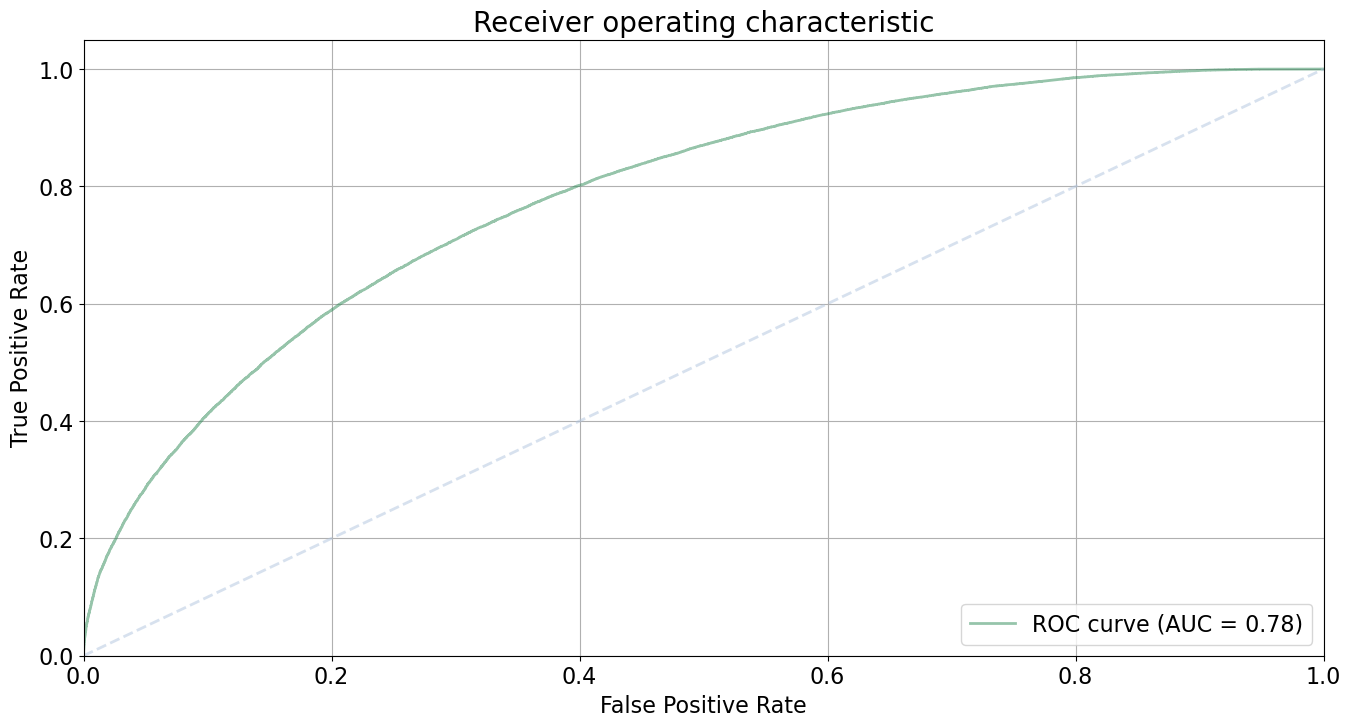

In [157]:
plt.figure(figsize=(16, 8))

plt.plot(fpr, tpr, color='seagreen',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='lightsteelblue', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show();

In [158]:
# as we know, when binary classification model shows AUC results about 0.5 we can say that this model is a random 
# classifier. We don't have perfect classifier which is AUC = 1, but 0.78 is a very good result.

### Random Forest Classifier

In [159]:
# initialize general model with random_state 42
rfc = RandomForestClassifier(random_state=42)

In [160]:
# fit the model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [161]:
# predict on train
rfc_train_pred = rfc.predict(X_train)
roc_auc_rfc_train = roc_auc_score(y_train, rfc_train_pred)

In [162]:
roc_auc_rfc_train

0.9925710905025565

In [163]:
# roc_auc for train is 99,25, it is a common feature of random forest, when metrics on train show almost 100% result
rfc_test_pred = rfc.predict(X_test)
roc_auc_rfc_test = roc_auc_score(y_test, rfc_test_pred)

In [164]:
# check on test
roc_auc_rfc_test

0.6318147310666014

In [165]:
# considering that rfc model hasn't been tuned yet it's a great result. 
# moving further with cvs
rfc_cvs = cross_val_score(rfc, X, y, cv=5, 
                         scoring='roc_auc',
                         verbose=False, n_jobs=-1)

In [166]:
print(f'Cross validation score for model rfc: {rfc_cvs}\nMean: {rfc_cvs.mean()}\nStandard deviation: {rfc_cvs.std()}')

Cross validation score for model rfc: [0.67066187 0.67435901 0.66997795 0.67086524 0.67598681]
Mean: 0.6723701761524727
Standard deviation: 0.002363952178283415


In [167]:
confusion_matrix(y_test, rfc_test_pred)

array([[6129, 3972],
       [3440, 6585]])

In [168]:
# results are promising, standard deviation is low, each fold is close to another one. 
# one of the great features of RandomForest is overfitting low probability even with default settings.
# from this point we can start to tune hyperparameteres
# let us get closer to actual params
print(f"Model params: {pd.DataFrame.from_dict(rfc.get_params(), orient='index')}")

Model params:                               0
bootstrap                  True
ccp_alpha                   0.0
class_weight               None
criterion                  gini
max_depth                  None
max_features               sqrt
max_leaf_nodes             None
max_samples                None
min_impurity_decrease       0.0
min_samples_leaf              1
min_samples_split             2
min_weight_fraction_leaf    0.0
n_estimators                100
n_jobs                     None
oob_score                 False
random_state                 42
verbose                       0
warm_start                False


In [169]:
# we are going to tune hyperparams with random search considering that random forest is learning slowly
rf = RandomForestClassifier(random_state=42, verbose=True)
rand_param_rf = {
    'n_estimators': [300, 500, 700, 1000],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 30, 50],
    'min_samples_split': [2, 5, 20],
    'min_samples_leaf': [2, 10, 15, 20]
}

rf_rand = RandomizedSearchCV(rf, rand_param_rf, scoring='roc_auc', 
                       cv=3, verbose=1, n_jobs=-1)

In [170]:
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   40.0s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   40.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   40.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   58.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   30.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=42,
                                                    verbose=True),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 30, 50],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 10, 15, 20],
                                        'min_samples_split': [2, 5, 20],
                                        'n_estimators': [300, 500, 700, 1000]},
                   scoring='roc_auc', verbose=1)

In [171]:
rf_best_params = rf_rand.best_params_
rf_best_params['random_state'] = 42
rf_best_params['verbose'] = True

In [172]:
rf_best_params

{'n_estimators': 500,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 30,
 'random_state': 42,
 'verbose': True}

In [173]:
# fit our best model
rf = RandomForestClassifier(**rf_best_params)

In [174]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomForestClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=500, random_state=42, verbose=True)

In [175]:
# predict on train
rf_train_pred = rf.predict(X_train)
roc_auc_rf_train = roc_auc_score(y_train, rf_train_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.6s finished


In [176]:
roc_auc_rf_train

0.633125042727362

In [177]:
# predict on test
rf_test_pred = rf.predict(X_test)
roc_auc_rf_test = roc_auc_score(y_test, rf_test_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished


In [178]:
roc_auc_rf_test

0.6310694701717146

In [179]:
# moving further with cvs
rf_cvs = cross_val_score(rf, X, y, cv=5,
                         scoring='roc_auc',
                         verbose=False, n_jobs=-1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_j

In [180]:
print(f'Cross validation score for model rf: {rf_cvs}\nMean: {rf_cvs.mean()}\nStandard deviation: {rf_cvs.std()}')

Cross validation score for model rf: [0.68171897 0.68065456 0.67513285 0.68494405 0.69420178]
Mean: 0.6833304407501835
Standard deviation: 0.006288836924640176


In [181]:
# std became even lower, we don't see overfitting prerequisites

In [182]:
confusion_matrix(y_test, rf_test_pred)

array([[5191, 4910],
       [2524, 7501]])

In [183]:
# let us see feature importances
rf_feat_imp = rf.feature_importances_
rf_imp_dict = {}
for col, imp in zip(X_train.columns, rf_feat_imp):
    rf_imp_dict[col] = imp

rf_imp_dict = dict(sorted(rf_imp_dict.items(), key=lambda x: x[1], reverse=True))
rf_imp_dict

{'month_visit_std': 0.08064647933794347,
 'utm_campaign_LTuZkdKfxRGVceoWkVyg': 0.06924838323230119,
 'utm_adcontent_JNHcPlZPxEMWDnRiyoBf': 0.06922584200151025,
 'utm_campaign_FTjNLDyTrXaWYgZymFkV': 0.05478641314350094,
 'utm_medium_cpm': 0.04372185133872272,
 'utm_medium_referral': 0.040955196835366144,
 'visit_number_std': 0.03724236529380679,
 'utm_source_bByPQxmDaMXgpHeypKSM': 0.03246278321027656,
 'utm_source_MvfHsxITijuriZxsqZqt': 0.023598597103381032,
 'utm_campaign_TmThBvoCcwkCZZUWACYq': 0.022474366216044716,
 'utm_medium_cpc': 0.022447897043788485,
 'height_res_std': 0.021302777411062887,
 'width_res_std': 0.019888705519727448,
 'utm_source_RmEBuqrriAfAVsLQQmhk': 0.01970084294622087,
 'day_visit_std': 0.013709149320416525,
 'utm_campaign_okTXSMadDkjvntEHzIjp': 0.012788822342980333,
 'utm_adcontent_xhoenQgDQsgfEPYNPwKO': 0.012426655678592548,
 'utm_source_ZpYIoDJMcFzVoPFsHGJL': 0.012009291458809288,
 'utm_adcontent_TuyPWsGQruPMpKvRxeBF': 0.011323376969408197,
 'utm_adcontent_LLf

In [184]:
# some of importances are the same as imps from catboost but there are some very unlike features e.g. utm_*
# we now can plot roc_auc curve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.2s finished


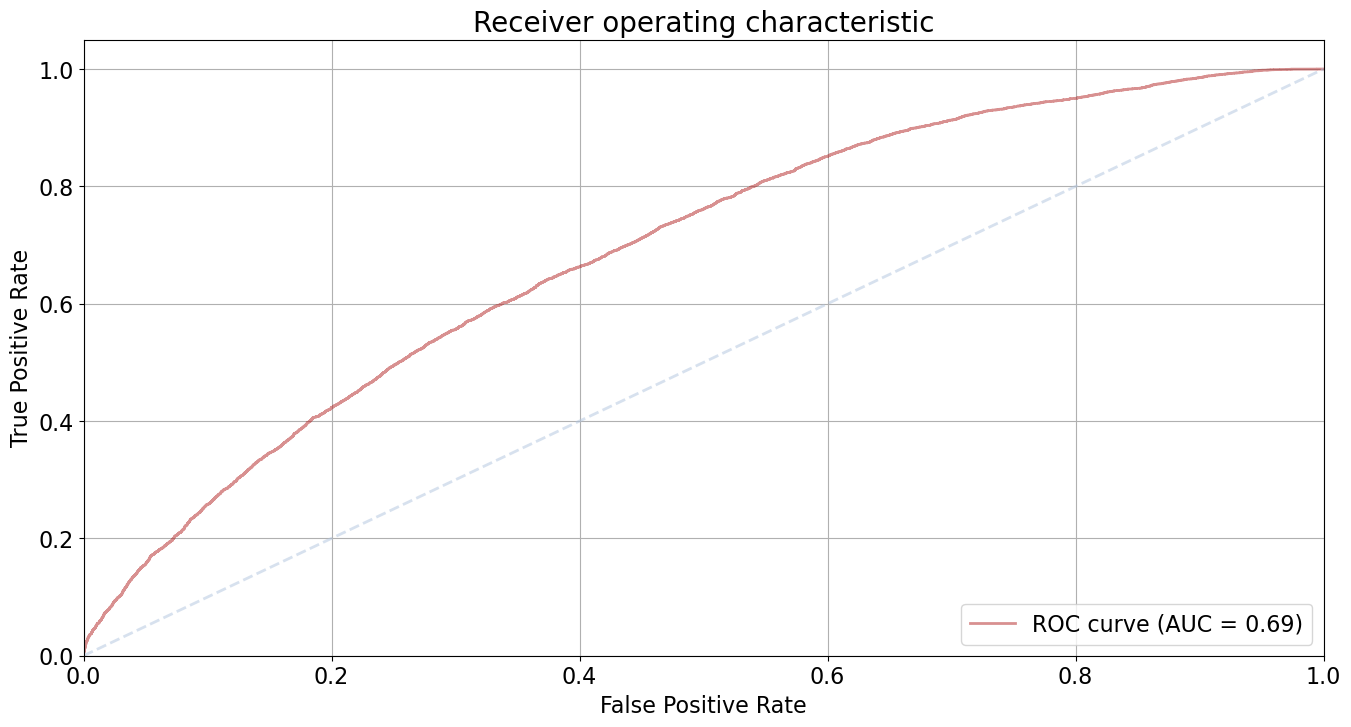

In [185]:
y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 8))

plt.plot(fpr, tpr, color='firebrick',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='lightsteelblue', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show();

In [186]:
# AUC area is 0.70, which is lower than catboost result.

### Logistic Regression

In [187]:
# initialize default logreg model
logreg_v1 = LogisticRegression(random_state=42)
logreg_v1.fit(X_train, y_train)

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [188]:
# predict on train
logreg_v1_pred_train = logreg_v1.predict(X_train)
roc_auc_log_v1_train = roc_auc_score(y_train, logreg_v1_pred_train)

In [189]:
roc_auc_log_v1_train

0.6402538124018998

In [190]:
# results are ok, let's check on test
logreg_v1_pred_test = logreg_v1.predict(X_test)
roc_auc_log_v1_test = roc_auc_score(y_test, logreg_v1_pred_test)

In [191]:
roc_auc_log_v1_test

0.632877908189629

In [192]:
# we have results ~0.63 on test and 0.64 on train, it's ok, this model hasn't been tuned yet. Results are close,
# it means that probably model hasn't been overfitted. Check cvs.
logreg_v1_cvs = cross_val_score(logreg_v1, X, y, 
                                cv=5, scoring='roc_auc', 
                                verbose=False, n_jobs=-1)

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [193]:
print(f'Cross validation score for model logreg_v1: {logreg_v1_cvs}\nMean: {logreg_v1_cvs.mean()}\nStandard deviation: {logreg_v1_cvs.std()}')

Cross validation score for model logreg_v1: [0.68692276 0.68844212 0.6822236  0.68994312 0.69664214]
Mean: 0.6888347477422374
Standard deviation: 0.00468403544907705


In [194]:
confusion_matrix(y_test, logreg_v1_pred_test)

array([[5954, 4147],
       [3245, 6780]])

In [195]:
# as it was mentioned earlier this model doesn't show overfitting features, std is low, all folds are close to each
# other. Also the result is better than random forest not tuned result. 
print(f"Model logreg_v1 params: {pd.DataFrame.from_dict(logreg_v1.get_params(), orient='index')}")

Model logreg_v1 params:                         0
C                     1.0
class_weight         None
dual                False
fit_intercept        True
intercept_scaling       1
l1_ratio             None
max_iter              100
multi_class          auto
n_jobs               None
penalty                l2
random_state           42
solver              lbfgs
tol                0.0001
verbose                 0
warm_start          False


In [196]:
# we are going to tune hyperparams with grid search
logreg = LogisticRegression(random_state=42, verbose=True)
grid_param_logreg = {
    'C': [0.5, 1.0, 1.7],
    'max_iter': [100, 200, 500],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

logreg_grid = GridSearchCV(logreg, grid_param_logreg, scoring='roc_auc', 
                           cv=3, verbose=1, n_jobs=-1)

In [197]:
logreg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 17
iter   6  #CD cycles 1
iter   7  #CD cycles 73
iter   8  #CD cycles 7
iter   9  #CD cycles 1
iter  10  #CD cycles 139
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter   5  #CD cycles 14
iter   6  #CD cycles 1
iter   1  #CD cycles 1
iter  11  #CD cycles 120
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter  12  #CD cycles 6
iter   7  #CD cycles 59
iter  13  #CD cycles 2
iter  14  #CD cycles 1
iter   5  #CD cycles 17
iter   6  #CD cycles 1
iter   8  #CD cycles 28
iter   9  #CD cycles 7
iter  10  #CD cycles 1
iter   7  #CD cycles 55
iter   8  #CD cycles 17
iter   9  #CD cycles 9
iter  10  #CD cycles 3
iter  11  #CD cycles 1
iter  11  #CD cycles 174
iter  12  #CD cycles 151
iter  12  #CD cycles 97
iter  13  #CD cycles 3
iter  14  #CD cycles 1
iter  13  #CD cycles 79
iter  14  #CD cycles 2
iter  15  #CD cycles 2
iter  16  #CD cycles 1
iter  15  #CD cycles 299
iter  17  #CD cycles 354
iter  15  #CD cycles 693
iter  16  #CD cycles 33
iter  17  #CD cycles 17
iter  18  #CD cycles 3
iter  19  #CD cycles 1
iter  16  #CD cycles 180
iter  17  #CD cycles 1
iter  18  #CD cycles 411
iter  19  #CD cycles 1
iter  18  #CD cycles 329
iter  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  1 act 1.393e+03 pre 1.329e+03 delta 2.352e+00 f 1.860e+04 |g| 3.321e+03 CG   9
cg reaches trust region boundary
iter  2 act 1.803e+02 pre 1.740e+02 delta 2.470e+00 f 1.721e+04 |g| 3.618e+02 CG  10
cg reaches trust region boundary
iter  3 act 1.071e+02 pre 1.064e+02 delta 2.594e+00 f 1.703e+04 |g| 2.940e+02 CG  12
cg reaches trust region boundary
iter  4 act 7.207e+01 pre 7.022e+01 delta 2.712e+00 f 1.692e+04 |g| 1.979e+02 CG  17
cg reaches trust region boundary
iter  5 act 4.273e+01 pre 4.276e+01 delta 2.737e+00 f 1.685e+04 |g| 1.199e+02 CG  19
cg reaches trust region boundary
iter  6 act 2.830e+01 pre 2.815e+01 delta 2.817e+00 f 1.680e+04 |g| 1.182e+02 CG  22
cg reaches trust region boundary
iter  7 act 1.465e+01 pre 1.454e+01 delta 2.864e+00 f 1.678e+04 |g| 5.187e+01 CG  29
iter  8 act 2.880e+00 pre 2.896e+00 delta 2.864e+00 f 1.676e+04 |g| 4.148e+01 CG  44
iter  9 act 9.155e-02 pre 9.147e-02 delta 2.864e+00 f 1.676e+04 |g| 3.132e+00 CG  51
iter 10 act 3.473e-03 pre 3.473e-03 d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  1 act 1.378e+03 pre 1.315e+03 delta 2.363e+00 f 1.860e+04 |g| 3.310e+03 CG   9
cg reaches trust region boundary
iter  2 act 1.869e+02 pre 1.800e+02 delta 2.515e+00 f 1.722e+04 |g| 3.650e+02 CG  10
cg reaches trust region boundary
iter  3 act 1.062e+02 pre 1.058e+02 delta 2.527e+00 f 1.704e+04 |g| 2.724e+02 CG  11
cg reaches trust region boundary
iter  4 act 8.013e+01 pre 7.800e+01 delta 2.666e+00 f 1.693e+04 |g| 2.556e+02 CG  17
cg reaches trust region boundary
iter  5 act 4.559e+01 pre 4.553e+01 delta 2.755e+00 f 1.685e+04 |g| 2.214e+02 CG  18
cg reaches trust region boundary
iter  6 act 3.030e+01 pre 3.012e+01 delta 2.886e+00 f 1.680e+04 |g| 8.757e+01 CG  21
cg reaches trust region boundary
iter  7 act 1.607e+01 pre 1.595e+01 delta 2.939e+00 f 1.677e+04 |g| 4.784e+01 CG  28
iter  8 act 3.850e+00 pre 3.865e+00 delta 2.939e+00 f 1.676e+04 |g| 2.144e+01 CG  45
iter  9 act 8.852e-02 pre 8.846e-02 delta 2.939e+00 f 1.675e+04 |g| 2.181e+00 CG  64
iter 10 act 9.465e-04 pre 9.466e-04 d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

Epoch 1, change: 1.00000000
Epoch 2, change: 0.29335064
Epoch 3, change: 0.14935224
Epoch 4, change: 0.09592586
Epoch 5, change: 0.08023809
Epoch 6, change: 0.07189643
Epoch 7, change: 0.06541198
Epoch 8, change: 0.05565570
Epoch 9, change: 0.05167304
Epoch 10, change: 0.04643859
Epoch 11, change: 0.04370320
Epoch 12, change: 0.03876641
Epoch 13, change: 0.03591216
Epoch 14, change: 0.03265701
Epoch 15, change: 0.03045979
Epoch 16, change: 0.02856805
Epoch 17, change: 0.02745240
Epoch 18, change: 0.02594992
Epoch 19, change: 0.02381574
Epoch 20, change: 0.02247688
Epoch 21, change: 0.02122683
Epoch 22, change: 0.02003183
Epoch 23, change: 0.01900855
Epoch 24, change: 0.01824544
Epoch 25, change: 0.01739896
Epoch 26, change: 0.01666127
Epoch 27, change: 0.01615153
Epoch 28, change: 0.01554127
Epoch 29, change: 0.01484870
Epoch 30, change: 0.01450038
Epoch 31, change: 0.01407587
Epoch 32, change: 0.01343947
Epoch 33, change: 0.01313758
Epoch 34, change: 0.01278624
Epoch 35, change: 0.012

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  18  #CD cycles 411
iter  19  #CD cycles 1
iter  20  #CD cycles 236
iter  21  #CD cycles 2
iter  22  #CD cycles 1
optimization finished, #iter = 22
Objective value = 16925.041778
#nonzeros/#features = 367/1693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28394039
Epoch 3, change: 0.15070691
Epoch 4, change: 0.10508623
Epoch 5, change: 0.07314352
Epoch 6, change: 0.05837229
Epoch 7, change: 0.04744106
Epoch 8, change: 0.04206457
Epoch 9, change: 0.03708377
Epoch 10, change: 0.03354526
Epoch 11, change: 0.02966739
Epoch 12, change: 0.02644901
Epoch 13, change: 0.02387062
Epoch 14, change: 0.02160038
Epoch 15, change: 0.01929588
Epoch 16, change: 0.01787581
Epoch 17, change: 0.01682155
Epoch 18, change: 0.01514739
Epoch 19, change: 0.01433024
Epoch 20, change: 0.01326884
Epoch 21, change: 0.01238702
Epoch 22, change: 0.01158767
Epoch 23, change: 0.01088674
Epoch 24, change: 0.01036819
Epoch 25, change: 0.00957038
Epoch 26, change: 0.00913564
Epoch 27, change: 0.00868534
Epoch 28, change: 0.00820661
Epoch 29, change: 0.00781125
Epoch 30, change: 0.00739589
Epoch 31, change: 0.00699978
Epoch 32, change: 0.00658151
Epoch 33, change: 0.00628088
Epoch 34, change: 0.00598381
Epoch 35, change: 0.005

cg reaches trust region boundary
iter  5 act 4.689e+01 pre 4.686e+01 delta 2.819e+00 f 1.687e+04 |g| 1.044e+02 CG  18
cg reaches trust region boundary
iter  6 act 2.932e+01 pre 2.914e+01 delta 2.872e+00 f 1.682e+04 |g| 8.440e+01 CG  21
cg reaches trust region boundary
iter  7 act 1.746e+01 pre 1.732e+01 delta 2.924e+00 f 1.679e+04 |g| 7.362e+01 CG  27
iter  8 act 4.225e+00 pre 4.247e+00 delta 2.924e+00 f 1.678e+04 |g| 5.479e+01 CG  41
iter  9 act 2.792e-01 pre 2.786e-01 delta 2.924e+00 f 1.677e+04 |g| 5.282e+00 CG  62
iter 10 act 2.514e-03 pre 2.514e-03 delta 2.924e+00 f 1.677e+04 |g| 5.144e-01 CG  58


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28776214
Epoch 3, change: 0.15129187
Epoch 4, change: 0.10640143
Epoch 5, change: 0.07504149
Epoch 6, change: 0.05890425
Epoch 7, change: 0.05244386
Epoch 8, change: 0.04690810
Epoch 9, change: 0.04112766
Epoch 10, change: 0.03719688
Epoch 11, change: 0.03346796
Epoch 12, change: 0.03075393
Epoch 13, change: 0.02830624
Epoch 14, change: 0.02599127
Epoch 15, change: 0.02421062
Epoch 16, change: 0.02230754
Epoch 17, change: 0.02051078
Epoch 18, change: 0.01929836
Epoch 19, change: 0.01831237
Epoch 20, change: 0.01716471
Epoch 21, change: 0.01612032
Epoch 22, change: 0.01534848
Epoch 23, change: 0.01441069
Epoch 24, change: 0.01377686
Epoch 25, change: 0.01310024
Epoch 26, change: 0.01254624
Epoch 27, change: 0.01214541
Epoch 28, change: 0.01167989
Epoch 29, change: 0.01125686
Epoch 30, change: 0.01089305
Epoch 31, change: 0.01052853
Epoch 32, change: 0.00994955
Epoch 33, change: 0.00972398
Epoch 34, change: 0.00932573
Epoch 35, change: 0.009

Epoch 178, change: 0.00206212
Epoch 179, change: 0.00203885
Epoch 180, change: 0.00202120
Epoch 181, change: 0.00200077
Epoch 182, change: 0.00199279
Epoch 183, change: 0.00196883
Epoch 184, change: 0.00194892
Epoch 185, change: 0.00193563
Epoch 186, change: 0.00191375
Epoch 187, change: 0.00189298
Epoch 188, change: 0.00188273
Epoch 189, change: 0.00185597
Epoch 190, change: 0.00184543
Epoch 191, change: 0.00183284
Epoch 192, change: 0.00180971
Epoch 193, change: 0.00179724
Epoch 194, change: 0.00177860
Epoch 195, change: 0.00177195
Epoch 196, change: 0.00174618
Epoch 197, change: 0.00173325
Epoch 198, change: 0.00172071
Epoch 199, change: 0.00169952
Epoch 200, change: 0.00169299
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 17
iter   6  #CD cycles 1
iter   7  #CD cycles 73
iter   8  #CD cycles 7
iter   9  #CD cycles 1
iter  10  #CD cycles 139
iter  11  #CD cycles 120
iter  12  #CD cycles 6
iter  13  #CD cycles 2
iter 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 

Epoch 1, change: 1.00000000
Epoch 2, change: 0.28394039
Epoch 3, change: 0.15070691
Epoch 4, change: 0.10508623
Epoch 5, change: 0.07314352
Epoch 6, change: 0.05837229
Epoch 7, change: 0.04744106
Epoch 8, change: 0.04206457
Epoch 9, change: 0.03708377
Epoch 10, change: 0.03354526
Epoch 11, change: 0.02966739
Epoch 12, change: 0.02644901
Epoch 13, change: 0.02387062
Epoch 14, change: 0.02160038
Epoch 15, change: 0.01929588
Epoch 16, change: 0.01787581
Epoch 17, change: 0.01682155
Epoch 18, change: 0.01514739
Epoch 19, change: 0.01433024
Epoch 20, change: 0.01326884
Epoch 21, change: 0.01238702
Epoch 22, change: 0.01158767
Epoch 23, change: 0.01088674
Epoch 24, change: 0.01036819
Epoch 25, change: 0.00957038
Epoch 26, change: 0.00913564
Epoch 27, change: 0.00868534
Epoch 28, change: 0.00820661
Epoch 29, change: 0.00781125
Epoch 30, change: 0.00739589
Epoch 31, change: 0.00699978
Epoch 32, change: 0.00658151
Epoch 33, change: 0.00628088
Epoch 34, change: 0.00598381
Epoch 35, change: 0.005

iter  5 act 4.273e+01 pre 4.276e+01 delta 2.737e+00 f 1.685e+04 |g| 1.199e+02 CG  19
cg reaches trust region boundary
iter  6 act 2.830e+01 pre 2.815e+01 delta 2.817e+00 f 1.680e+04 |g| 1.182e+02 CG  22
cg reaches trust region boundary
iter  7 act 1.465e+01 pre 1.454e+01 delta 2.864e+00 f 1.678e+04 |g| 5.187e+01 CG  29
iter  8 act 2.880e+00 pre 2.896e+00 delta 2.864e+00 f 1.676e+04 |g| 4.148e+01 CG  44
iter  9 act 9.155e-02 pre 9.147e-02 delta 2.864e+00 f 1.676e+04 |g| 3.132e+00 CG  51
iter 10 act 3.473e-03 pre 3.473e-03 delta 2.864e+00 f 1.676e+04 |g| 2.899e-01 CG  70
iter  1 act 1.378e+03 pre 1.315e+03 delta 2.363e+00 f 1.860e+04 |g| 3.310e+03 CG   9
cg reaches trust region boundary
iter  2 act 1.869e+02 pre 1.800e+02 delta 2.515e+00 f 1.722e+04 |g| 3.650e+02 CG  10
cg reaches trust region boundary
iter  3 act 1.062e+02 pre 1.058e+02 delta 2.527e+00 f 1.704e+04 |g| 2.724e+02 CG  11
cg reaches trust region boundary
iter  4 act 8.013e+01 pre 7.800e+01 delta 2.666e+00 f 1.693e+04 |g| 2.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28776214
Epoch 3, change: 0.15129187
Epoch 4, change: 0.10640143
Epoch 5, change: 0.07504149
Epoch 6, change: 0.05890425
Epoch 7, change: 0.05244386
Epoch 8, change: 0.04690810
Epoch 9, change: 0.04112766
Epoch 10, change: 0.03719688
Epoch 11, change: 0.03346796
Epoch 12, change: 0.03075393
Epoch 13, change: 0.02830624
Epoch 14, change: 0.02599127
Epoch 15, change: 0.02421062
Epoch 16, change: 0.02230754
Epoch 17, change: 0.02051078
Epoch 18, change: 0.01929836
Epoch 19, change: 0.01831237
Epoch 20, change: 0.01716471
Epoch 21, change: 0.01612032
Epoch 22, change: 0.01534848
Epoch 23, change: 0.01441069
Epoch 24, change: 0.01377686
Epoch 25, change: 0.01310024
Epoch 26, change: 0.01254624
Epoch 27, change: 0.01214541
Epoch 28, change: 0.01167989
Epoch 29, change: 0.01125686
Epoch 30, change: 0.01089305
Epoch 31, change: 0.01052853
Epoch 32, change: 0.00994955
Epoch 33, change: 0.00972398
Epoch 34, change: 0.00932573
Epoch 35, change: 0.009

Epoch 141, change: 0.00226215
Epoch 142, change: 0.00223346
Epoch 143, change: 0.00221234
Epoch 144, change: 0.00218814
Epoch 145, change: 0.00216711
Epoch 146, change: 0.00213928
Epoch 147, change: 0.00211089
Epoch 148, change: 0.00208394
Epoch 149, change: 0.00206266
Epoch 150, change: 0.00204144
Epoch 151, change: 0.00201813
Epoch 152, change: 0.00199609
Epoch 153, change: 0.00197939
Epoch 154, change: 0.00195188
Epoch 155, change: 0.00193476
Epoch 156, change: 0.00190643
Epoch 157, change: 0.00189053
Epoch 158, change: 0.00186730
Epoch 159, change: 0.00185028
Epoch 160, change: 0.00182554
Epoch 161, change: 0.00180642
Epoch 162, change: 0.00178988
Epoch 163, change: 0.00176935
Epoch 164, change: 0.00175159
Epoch 165, change: 0.00173433
Epoch 166, change: 0.00171236
Epoch 167, change: 0.00169162
Epoch 168, change: 0.00167862
Epoch 169, change: 0.00165635
Epoch 170, change: 0.00164375
Epoch 171, change: 0.00162297
Epoch 172, change: 0.00160673
Epoch 173, change: 0.00158774
Epoch 174,

Epoch 70, change: 0.00584989
Epoch 71, change: 0.00571646
Epoch 72, change: 0.00561799
Epoch 73, change: 0.00552008
Epoch 74, change: 0.00542094
Epoch 75, change: 0.00531747
Epoch 76, change: 0.00524021
Epoch 77, change: 0.00512323
Epoch 78, change: 0.00504938
Epoch 79, change: 0.00495367
Epoch 80, change: 0.00487900
Epoch 81, change: 0.00481206
Epoch 82, change: 0.00473246
Epoch 83, change: 0.00467729
Epoch 84, change: 0.00461218
Epoch 85, change: 0.00454661
Epoch 86, change: 0.00448325
Epoch 87, change: 0.00443317
Epoch 88, change: 0.00436690
Epoch 89, change: 0.00431724
Epoch 90, change: 0.00426493
Epoch 91, change: 0.00420841
Epoch 92, change: 0.00415644
Epoch 93, change: 0.00410260
Epoch 94, change: 0.00405242
Epoch 95, change: 0.00400780
Epoch 96, change: 0.00395868
Epoch 97, change: 0.00390287
Epoch 98, change: 0.00386122
Epoch 99, change: 0.00381695
Epoch 100, change: 0.00377395
Epoch 101, change: 0.00372766
Epoch 102, change: 0.00368526
Epoch 103, change: 0.00364342
Epoch 104,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28394039
Epoch 3, change: 0.15070691
Epoch 4, change: 0.10508623
Epoch 5, change: 0.07314352
Epoch 6, change: 0.05837229
Epoch 7, change: 0.04744106
Epoch 8, change: 0.04206457
Epoch 9, change: 0.03708377
Epoch 10, change: 0.03354526
Epoch 11, change: 0.02966739
Epoch 12, change: 0.02644901
Epoch 13, change: 0.02387062
Epoch 14, change: 0.02160038
Epoch 15, change: 0.01929588
Epoch 16, change: 0.01787581
Epoch 17, change: 0.01682155
Epoch 18, change: 0.01514739
Epoch 19, change: 0.01433024
Epoch 20, change: 0.01326884
Epoch 21, change: 0.01238702
Epoch 22, change: 0.01158767
Epoch 23, change: 0.01088674
Epoch 24, change: 0.01036819
Epoch 25, change: 0.00957038
Epoch 26, change: 0.00913564
Epoch 27, change: 0.00868534
Epoch 28, change: 0.00820661
Epoch 29, change: 0.00781125
Epoch 30, change: 0.00739589
Epoch 31, change: 0.00699978
Epoch 32, change: 0.00658151
Epoch 33, change: 0.00628088
Epoch 34, change: 0.00598381
Epoch 35, change: 0.005

Epoch 365,Epoch 1, change: 1.00000000
Epoch 2, change: 0.28776214
Epoch 3, change: 0.15129187
Epoch 4, change: 0.10640143
Epoch 5, change: 0.07504149
Epoch 6, change: 0.05890425
Epoch 7, change: 0.05244386
Epoch 8, change: 0.04690810
Epoch 9, change: 0.04112766
Epoch 10, change: 0.03719688
Epoch 11, change: 0.03346796
Epoch 12, change: 0.03075393
Epoch 13, change: 0.02830624
Epoch 14, change: 0.02599127
Epoch 15, change: 0.02421062
Epoch 16, change: 0.02230754
Epoch 17, change: 0.02051078
Epoch 18, change: 0.01929836
Epoch 19, change: 0.01831237
Epoch 20, change: 0.01716471
Epoch 21, change: 0.01612032
Epoch 22, change: 0.01534848
Epoch 23, change: 0.01441069
Epoch 24, change: 0.01377686
Epoch 25, change: 0.01310024
Epoch 26, change: 0.01254624
Epoch 27, change: 0.01214541
Epoch 28, change: 0.01167989
Epoch 29, change: 0.01125686
Epoch 30, change: 0.01089305
Epoch 31, change: 0.01052853
Epoch 32, change: 0.00994955
Epoch 33, change: 0.00972398
Epoch 34, change: 0.00932573
Epoch 35, cha

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished


 change: 0.00023712
Epoch 366, change: 0.00023539
Epoch 367, change: 0.00023364
Epoch 368, change: 0.00023193
Epoch 369, change: 0.00023023
Epoch 370, change: 0.00022855
Epoch 371, change: 0.00022643
Epoch 372, change: 0.00022512
Epoch 373, change: 0.00022286
Epoch 374, change: 0.00022137
Epoch 375, change: 0.00021938
Epoch 376, change: 0.00021802
Epoch 377, change: 0.00021654
Epoch 378, change: 0.00021494
Epoch 379, change: 0.00021271
Epoch 380, change: 0.00021157
Epoch 381, change: 0.00020966
Epoch 382, change: 0.00020817
Epoch 383, change: 0.00020681
Epoch 384, change: 0.00020486
Epoch 385, change: 0.00020340
Epoch 386, change: 0.00020144
Epoch 387, change: 0.00020036
Epoch 388, change: 0.00019890
Epoch 389, change: 0.00019721
Epoch 390, change: 0.00019554
Epoch 391, change: 0.00019414
Epoch 392, change: 0.00019287
Epoch 393, change: 0.00019124
Epoch 394, change: 0.00018918
Epoch 395, change: 0.00018826
Epoch 396, change: 0.00018670
Epoch 397, change: 0.00018528
Epoch 398, change: 0

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.4min finished


iter  17  #CD cycles 713
iter  18  #CD cycles 362
iter  19  #CD cycles 1
2
Epoch 158, change: 0.00250786
Epoch 159, change: 0.00249074
Epoch 160, change: 0.00245239
Epoch 161, change: 0.00243216
Epoch 162, change: 0.00241513
Epoch 163, change: 0.00238785
Epoch 164, change: 0.00236806
Epoch 165, change: 0.00234723
Epoch 166, change: 0.00231364
Epoch 167, change: 0.00228703
Epoch 168, change: 0.00227648
Epoch 169, change: 0.00224445
Epoch 170, change: 0.00223125
Epoch 171, change: 0.00220528
Epoch 172, change: 0.00218700
Epoch 173, change: 0.00216031
Epoch 174, change: 0.00214296
Epoch 175, change: 0.00212137
Epoch 176, change: 0.00210269
Epoch 177, change: 0.00208940
Epoch 178, change: 0.00206212
Epoch 179, change: 0.00203885
Epoch 180, change: 0.00202120
Epoch 181, change: 0.00200077
Epoch 182, change: 0.00199279
Epoch 183, change: 0.00196883
Epoch 184, change: 0.00194892
Epoch 185, change: 0.00193563
Epoch 186, change: 0.00191375
Epoch 187, change: 0.00189298
Epoch 188, change: 0.0018

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1, change: 0.00183284
Epoch 192, change: 0.00180971
Epoch 193, change: 0.00179724
Epoch 194, change: 0.00177860
Epoch 195, change: 0.00177195
Epoch 196, change: 0.00174618
Epoch 197, change: 0.00173325
Epoch 198, change: 0.00172071
Epoch 199, change: 0.00169952
Epoch 200, change: 0.00169299
Epoch 201, change: 0.00167647
Epoch 202, change: 0.00165769
Epoch 203, change: 0.00164174
Epoch 204, change: 0.00162994
Epoch 205, change: 0.00161290
Epoch 206, change: 0.00160406
Epoch 207, change: 0.00159392
Epoch 208, change: 0.00157984
Epoch 209, change: 0.00156668
Epoch 210, change: 0.00154365
Epoch 211, change: 0.00153942
Epoch 212, change: 0.00152156
Epoch 213, change: 0.00151171
Epoch 214, change: 0.00150025
Epoch 215, change: 0.00148927
Epoch 216, change: 0.00147046
Epoch 217, change: 0.00146340
Epoch 218, change: 0.00144967
Epoch 219, change: 0.00144406
Epoch 220, change: 0.00142819
Epoch 221, change: 0.00141205
Epoch 222, change: 0.00140251
Epoch 223, change: 0.00139158
Epoch 224, change:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.7min finished


1, change: 0.00098543
Epoch 292, change: 0.00098089
Epoch 293, change: 0.00097625
Epoch 294, change: 0.00097248
Epoch 295, change: 0.00096936
Epoch 296, change: 0.00096428
Epoch 297, change: 0.00095879
Epoch 298, change: 0.00095576
Epoch 299, change: 0.00095179
Epoch 300, change: 0.00094740
Epoch 301, change: 0.00094364
Epoch 302, change: 0.00094089
Epoch 303, change: 0.00093562
Epoch 304, change: 0.00093199
Epoch 305, change: 0.00092913
Epoch 306, change: 0.00092305
Epoch 307, change: 0.00092113
Epoch 308, change: 0.00091692
Epoch 309, change: 0.00091459
Epoch 310, change: 0.00091271
Epoch 311, change: 0.00091027
Epoch 312, change: 0.00090802
Epoch 313, change: 0.00090630
Epoch 314, change: 0.00090405
Epoch 315, change: 0.00090228
Epoch 316, change: 0.00090003
Epoch 317, change: 0.00089808
Epoch 318, change: 0.00089583
Epoch 319, change: 0.00089417
Epoch 320, change: 0.00089250
Epoch 321, change: 0.00089069
Epoch 322, change: 0.00088837
Epoch 323, change: 0.00088671
Epoch 324, change:

iter  15  #CD cycles 846
iter  16  #CD cycles 62
iter  17  #CD cycles 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  18  #CD cycles 1000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  19  #CD cycles 506
iter  20  #CD cycles 8
iter  21  #CD cycles 7
iter  22  #CD cycles 3
iter  23  #CD cycles 3
iter  24  #CD cycles 9
iter  25  #CD cycles 4
iter  26  #CD cycles 5
iter  27  #CD cycles 3
optimization finished, #iter = 27
Objective value = 33634.320698
#nonzeros/#features = 554/1693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29220938
Epoch 3, change: 0.15451657
Epoch 4, change: 0.11009573
Epoch 5, change: 0.07809635
Epoch 6, change: 0.06303611
Epoch 7, change: 0.05419453
Epoch 8, change: 0.04831209
Epoch 9, change: 0.04223001
Epoch 10, change: 0.03810533
Epoch 11, change: 0.03422742
Epoch 12, change: 0.03136770
Epoch 13, change: 0.02882182
Epoch 14, change: 0.02642050
Epoch 15, change: 0.02459384
Epoch 16, change: 0.02292054
Epoch 17, change: 0.02203767
Epoch 18, change: 0.02033400
Epoch 19, change: 0.01960196
Epoch 20, change: 0.01849088
Epoch 21, change: 0.01761138
Epoch 22, change: 0.01684223
Epoch 23, change: 0.01614407
Epoch 24, change: 0.01566638
Epoch 25, change: 0.01483353
Epoch 26, change: 0.01443279
Epoch 27, change: 0.01400020
Epoch 28, change: 0.01353358
Epoch 29, change: 0.01309699
Epoch 30, change: 0.01270879
Epoch 31, change: 0.01230347
Epoch 32, change: 0.01170932
Epoch 33, change: 0.01145445
Epoch 34, change: 0.01102783
Epoch 35, change: 0.010

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


iter  1 act 2.724e+03 pre 2.604e+03 delta 2.349e+00 f 3.720e+04 |g| 6.600e+03 CG   9
cg reaches trust region boundary
iter  2 act 3.748e+02 pre 3.617e+02 delta 2.513e+00 f 3.448e+04 |g| 7.024e+02 CG  10
cg reaches trust region boundary
iter  3 act 2.205e+02 pre 2.200e+02 delta 2.593e+00 f 3.410e+04 |g| 5.396e+02 CG  11
cg reaches trust region boundary
iter  4 act 1.665e+02 pre 1.613e+02 delta 2.726e+00 f 3.388e+04 |g| 4.837e+02 CG  17
cg reaches trust region boundary
iter  5 act 1.057e+02 pre 1.058e+02 delta 2.794e+00 f 3.371e+04 |g| 2.246e+02 CG  18
cg reaches trust region boundary
iter  6 act 8.502e+01 pre 8.447e+01 delta 3.096e+00 f 3.361e+04 |g| 2.475e+02 CG  20
cg reaches trust region boundary
iter  7 act 5.449e+01 pre 5.480e+01 delta 3.238e+00 f 3.352e+04 |g| 1.221e+02 CG  22
cg reaches trust region boundary
iter  8 act 4.014e+01 pre 4.003e+01 delta 3.397e+00 f 3.347e+04 |g| 1.029e+02 CG  27
cg reaches trust region boundary
iter  9 act 2.148e+01 pre 2.135e+01 delta 3.449e+00 f 3.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

Epoch 1, change: 1.00000000
Epoch 2, change: 0.29663690
Epoch 3, change: 0.13580597
Epoch 4, change: 0.09890584
Epoch 5, change: 0.08389455
Epoch 6, change: 0.07573028
Epoch 7, change: 0.06637358
Epoch 8, change: 0.06055977
Epoch 9, change: 0.05388555
Epoch 10, change: 0.04945084
Epoch 11, change: 0.04540983
Epoch 12, change: 0.04140951
Epoch 13, change: 0.03804281
Epoch 14, change: 0.03636471
Epoch 15, change: 0.03429477
Epoch 16, change: 0.03218543
Epoch 17, change: 0.03040817
Epoch 18, change: 0.02876828
Epoch 19, change: 0.02721505
Epoch 20, change: 0.02570719
Epoch 21, change: 0.02431325
Epoch 22, change: 0.02297228
Epoch 23, change: 0.02199894
Epoch 24, change: 0.02068552
Epoch 25, change: 0.01983049
Epoch 26, change: 0.01907509
Epoch 27, change: 0.01826283
Epoch 28, change: 0.01745593
Epoch 29, change: 0.01683058
Epoch 30, change: 0.01624105
Epoch 31, change: 0.01558824
Epoch 32, change: 0.01496973
Epoch 33, change: 0.01451220
Epoch 34, change: 0.01400169
Epoch 35, change: 0.013

iter   4  #CD cycles 1
iter   5  #CD cycles 14
iter   6  #CD cycles 1
iter  11  #CD cycles 121
iter  12  #CD cycles 10
iter  13  #CD cycles 6
iter  14  #CD cycles 7
iter  15  #CD cycles 4
iter  16  #CD cycles 1
iter   7  #CD cycles 57
iter   8  #CD cycles 14
iter   9  #CD cycles 8
iter  10  #CD cycles 9
iter  11  #CD cycles 6
iter  12  #CD cycles 4
iter  13  #CD cycles 5
iter  14  #CD cycles 1
iter  15  #CD cycles 208
iter  16  #CD cycles 120
iter  17  #CD cycles 21
iter  18  #CD cycles 21
iter  19  #CD cycles 15
iter  20  #CD cycles 8
iter  21  #CD cycles 2
iter  22  #CD cycles 1
iter  17  #CD cycles 713
iter  23  #CD cycles 581
iter  18  #CD cycles 362
iter  19  #CD cycles 1
iter  24  #CD cycles 232
iter  25  #CD cycles 21
iter  26  #CD cycles 6
iter  27  #CD cycles 13
iter  28  #CD cycles 15
iter  29  #CD cycles 45
iter  30  #CD cycles 1
iter  20  #CD cycles 1000
iter  31  #CD cycles 1000


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


iter  21  #CD cycles 1000
iter  22  #CD cycles 32
iter  23  #CD cycles 256
iter  24  #CD cycles 48
iter  25  #CD cycles 2
iter  26  #CD cycles 12
iter  27  #CD cycles 8
iter  28  #CD cycles 9
iter  32  #CD cycles 1000
iter  29  #CD cycles 7
iter  30  #CD cycles 7
iter  31  #CD cycles 5
optimization finished, #iter = 31
Objective value = 33594.910955
#nonzeros/#features = 509/1693
iter  33  #CD cycles 87
iter  34  #CD cycles 2
iter  35  #CD cycles 26
iter  36  #CD cycles 25
iter  37  #CD cycles 22
optimization finished, #iter = 37
Objective value = 33589.528728
#nonzeros/#features = 528/1693
 change: 0.00076666
Epoch 355, change: 0.00076364
Epoch 356, change: 0.00076090
Epoch 357, change: 0.00075842
Epoch 358, change: 0.00075492
Epoch 359, change: 0.00075152
Epoch 360, change: 0.00074919
Epoch 361, change: 0.00074642
Epoch 362, change: 0.00074294
Epoch 363, change: 0.00074076
Epoch 364, change: 0.00073775
Epoch 365, change: 0.00073577
Epoch 366, change: 0.00073260
Epoch 367, change: 0.0

iter   7  #CD cycles 89
iter   8  #CD cycles 7
iter   9  #CD cycles 1
iter  10  #CD cycles 272
iter  11  #CD cycles 31
iter  12  #CD cycles 25
iter  13  #CD cycles 11
iter  14  #CD cycles 1
iter  15  #CD cycles 846


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  16  #CD cycles 62
iter  17  #CD cycles 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter  18  #CD cycles 1000
iter  19  #CD cycles 506
iter  20  #CD cycles 8
iter  21  #CD cycles 7
iter  22  #CD cycles 3
iter  23  #CD cycles 3
iter  24  #CD cycles 9
iter  25  #CD cycles 4
iter  26  #CD cycles 5
iter  27  #CD cycles 3
optimization finished, #iter = 27
Objective value = 33634.320698
#nonzeros/#features = 554/1693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min finished


 change: 0.00321691
Epoch 113, change: 0.00317934
Epoch 114, change: 0.00313451
Epoch 115, change: 0.00310070
Epoch 116, change: 0.00306040
Epoch 117, change: 0.00301207
Epoch 118, change: 0.00298787
Epoch 119, change: 0.00293854
Epoch 120, change: 0.00290995
Epoch 121, change: 0.00287581
Epoch 122, change: 0.00283964
Epoch 123, change: 0.00279628
Epoch 124, change: 0.00276436
Epoch 125, change: 0.00273669
Epoch 126, change: 0.00269971
Epoch 127, change: 0.00266976
Epoch 128, change: 0.00263594
Epoch 129, change: 0.00261448
Epoch 130, change: 0.00257602
Epoch 131, change: 0.00253815
Epoch 132, change: 0.00251191
Epoch 133, change: 0.00248504
Epoch 134, change: 0.00245268
Epoch 135, change: 0.00242592
Epoch 136, change: 0.00239979
Epoch 137, change: 0.00236558
Epoch 138, change: 0.00234823
Epoch 139, change: 0.00231580
Epoch 140, change: 0.00228886
Epoch 141, change: 0.00226215
Epoch 142, change: 0.00223346
Epoch 143, change: 0.00221234
Epoch 144, change: 0.00218814
Epoch 145, change: 0

iter  1 act 2.724e+03 pre 2.604e+03 delta 2.349e+00 f 3.720e+04 |g| 6.600e+03 CG   9
cg reaches trust region boundary
iter  2 act 3.748e+02 pre 3.617e+02 delta 2.513e+00 f 3.448e+04 |g| 7.024e+02 CG  10
cg reaches trust region boundary
iter  3 act 2.205e+02 pre 2.200e+02 delta 2.593e+00 f 3.410e+04 |g| 5.396e+02 CG  11
cg reaches trust region boundary
iter  4 act 1.665e+02 pre 1.613e+02 delta 2.726e+00 f 3.388e+04 |g| 4.837e+02 CG  17
cg reaches trust region boundary
iter  5 act 1.057e+02 pre 1.058e+02 delta 2.794e+00 f 3.371e+04 |g| 2.246e+02 CG  18
cg reaches trust region boundary
iter  6 act 8.502e+01 pre 8.447e+01 delta 3.096e+00 f 3.361e+04 |g| 2.475e+02 CG  20
cg reaches trust region boundary
iter  7 act 5.449e+01 pre 5.480e+01 delta 3.238e+00 f 3.352e+04 |g| 1.221e+02 CG  22
cg reaches trust region boundary
iter  8 act 4.014e+01 pre 4.003e+01 delta 3.397e+00 f 3.347e+04 |g| 1.029e+02 CG  27
cg reaches trust region boundary
iter  9 act 2.148e+01 pre 2.135e+01 delta 3.449e+00 f 3.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

Epoch 1, change: 1.00000000
Epoch 2, change: 0.29581364
Epoch 3, change: 0.13540064
Epoch 4, change: 0.09883379
Epoch 5, change: 0.08411850
Epoch 6, change: 0.07509302
Epoch 7, change: 0.06595695
Epoch 8, change: 0.06034933
Epoch 9, change: 0.05382903
Epoch 10, change: 0.04953873
Epoch 11, change: 0.04560352
Epoch 12, change: 0.04142974
Epoch 13, change: 0.03815603
Epoch 14, change: 0.03655901
Epoch 15, change: 0.03456698
Epoch 16, change: 0.03251717
Epoch 17, change: 0.03080137
Epoch 18, change: 0.02904960
Epoch 19, change: 0.02734198
Epoch 20, change: 0.02578210
Epoch 21, change: 0.02440763
Epoch 22, change: 0.02320758
Epoch 23, change: 0.02242924
Epoch 24, change: 0.02118414
Epoch 25, change: 0.02034336
Epoch 26, change: 0.01960472
Epoch 27, change: 0.01880868
Epoch 28, change: 0.01801529
Epoch 29, change: 0.01741215
Epoch 30, change: 0.01683591
Epoch 31, change: 0.01619661
Epoch 32, change: 0.01559683
Epoch 33, change: 0.01515509
Epoch 34, change: 0.01465593
Epoch 35, change: 0.014

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


08119
Epoch 36, change: 0.01370668
Epoch 37, change: 0.01336262
Epoch 38, change: 0.01282605
Epoch 39, change: 0.01258477
Epoch 40, change: 0.01224798
Epoch 41, change: 0.01180348
Epoch 42, change: 0.01149367
Epoch 43, change: 0.01121394
Epoch 44, change: 0.01086816
Epoch 45, change: 0.01061489
Epoch 46, change: 0.01028565
Epoch 47, change: 0.01008450
Epoch 48, change: 0.00981815
Epoch 49, change: 0.00949955
Epoch 50, change: 0.00933933
Epoch 51, change: 0.00910546
Epoch 52, change: 0.00888285
Epoch 53, change: 0.00871469
Epoch 54, change: 0.00852074
Epoch 55, change: 0.00833307
Epoch 56, change: 0.00813409
Epoch 57, change: 0.00796200
Epoch 58, change: 0.00774971
Epoch 59, change: 0.00762557
Epoch 60, change: 0.00745084
Epoch 61, change: 0.00731018
Epoch 62, change: 0.00715873
Epoch 63, change: 0.00701687
Epoch 64, change: 0.00687633
Epoch 65, change: 0.00673936
Epoch 66, change: 0.00661642
Epoch 67, change: 0.00647901
Epoch 68, change: 0.00638274
Epoch 69, change: 0.00624014
Epoch 70

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min finished


9
Epoch 138, change: 0.00284496
Epoch 139, change: 0.00282636
Epoch 140, change: 0.00280618
Epoch 141, change: 0.00278883
Epoch 142, change: 0.00277290
Epoch 143, change: 0.00275432
Epoch 144, change: 0.00274034
Epoch 145, change: 0.00272247
Epoch 146, change: 0.00270831
Epoch 147, change: 0.00268759
Epoch 148, change: 0.00267194
Epoch 149, change: 0.00265864
Epoch 150, change: 0.00263974
Epoch 151, change: 0.00262747
Epoch 152, change: 0.00261082
Epoch 153, change: 0.00259025
Epoch 154, change: 0.00257497
Epoch 155, change: 0.00256391
Epoch 156, change: 0.00254459
Epoch 157, change: 0.00253035
Epoch 158, change: 0.00251795
Epoch 159, change: 0.00250382
Epoch 160, change: 0.00248687
Epoch 161, change: 0.00247660
Epoch 162, change: 0.00245991
Epoch 163, change: 0.00244472
Epoch 164, change: 0.00243131
Epoch 165, change: 0.00241417
Epoch 166, change: 0.00240585
Epoch 167, change: 0.00238964
Epoch 168, change: 0.00237827
Epoch 169, change: 0.00237179
Epoch 170, change: 0.00234870
Epoch 17

iter  10  #CD cycles 272
iter  11  #CD cycles 31
iter  12  #CD cycles 25
iter  13  #CD cycles 11
iter  14  #CD cycles 1
iter  31  #CD cycles 1000
iter  15  #CD cycles 846
iter  16  #CD cycles 62
iter  17  #CD cycles 1
iter  32  #CD cycles 1000
iter  33  #CD cycles 87
iter  34  #CD cycles 2
iter  35  #CD cycles 26
iter  36  #CD cycles 25
iter  37  #CD cycles 22
optimization finished, #iter = 37
Objective value = 33589.528728
#nonzeros/#features = 528/1693
iter  18  #CD cycles 1000
iter  19  #CD cycles 506
iter  20  #CD cycles 8
iter  21  #CD cycles 7
iter  22  #CD cycles 3
iter  23  #CD cycles 3
iter  24  #CD cycles 9
iter  25  #CD cycles 4
iter  26  #CD cycles 5
iter  27  #CD cycles 3
optimization finished, #iter = 27
Objective value = 33634.320698
#nonzeros/#features = 554/1693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29003529
Epoch 3, change: 0.15474039
Epoch 4, change: 0.10912540
Epoch 5, change: 0.07712742
Epoch 6, change: 0.06241602
Epoch 7, change: 0.05144368
Epoch 8, change: 0.04570724
Epoch 9, change: 0.04069518
Epoch 10, change: 0.03717057
Epoch 11, change: 0.03321950
Epoch 12, change: 0.02991920
Epoch 13, change: 0.02729721
Epoch 14, change: 0.02496778
Epoch 15, change: 0.02255233
Epoch 16, change: 0.02120357
Epoch 17, change: 0.02017761
Epoch 18, change: 0.01843652
Epoch 19, change: 0.01763631
Epoch 20, change: 0.01651831
Epoch 21, change: 0.01561854
Epoch 22, change: 0.01479251
Epoch 23, change: 0.01406370
Epoch 24, change: 0.01354842
Epoch 25, change: 0.01269164
Epoch 26, change: 0.01224990
Epoch 27, change: 0.01178456
Epoch 28, change: 0.01129092
Epoch 29, change: 0.01086294
Epoch 30, change: 0.01042761
Epoch 31, change: 0.00999866
Epoch 32, change: 0.00945551
Epoch 33, change: 0.00918415
Epoch 34, change: 0.00876570
Epoch 35, change: 0.008

cg reaches trust region boundary
iter  5 act 1.020e+02 pre 1.018e+02 delta 2.906e+00 f 3.367e+04 |g| 3.188e+02 CG  18
cg reaches trust region boundary
iter  6 act 7.491e+01 pre 7.410e+01 delta 3.089e+00 f 3.357e+04 |g| 2.040e+02 CG  20
cg reaches trust region boundary
iter  7 act 5.161e+01 pre 5.167e+01 delta 3.094e+00 f 3.349e+04 |g| 1.408e+02 CG  22
cg reaches trust region boundary
iter  8 act 3.645e+01 pre 3.630e+01 delta 3.173e+00 f 3.344e+04 |g| 1.938e+02 CG  27
cg reaches trust region boundary
iter  9 act 1.837e+01 pre 1.827e+01 delta 3.200e+00 f 3.340e+04 |g| 5.266e+01 CG  38
iter 10 act 2.370e+00 pre 2.365e+00 delta 3.200e+00 f 3.338e+04 |g| 5.376e+01 CG  27
iter 11 act 1.339e+00 pre 1.339e+00 delta 3.200e+00 f 3.338e+04 |g| 5.022e+00 CG  80
iter 12 act 3.906e-03 pre 3.906e-03 delta 3.200e+00 f 3.338e+04 |g| 4.201e-01 CG  83
iter  1 act 2.759e+03 pre 2.632e+03 delta 2.369e+00 f 3.720e+04 |g| 6.619e+03 CG   9
cg reaches trust region boundary
iter  2 act 3.788e+02 pre 3.650e+02 d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29220938
Epoch 3, change: 0.15451657
Epoch 4, change: 0.11009573
Epoch 5, change: 0.07809635
Epoch 6, change: 0.06303611
Epoch 7, change: 0.05419453
Epoch 8, change: 0.04831209
Epoch 9, change: 0.04223001
Epoch 10, change: 0.03810533
Epoch 11, change: 0.03422742
Epoch 12, change: 0.03136770
Epoch 13, change: 0.02882182
Epoch 14, change: 0.02642050
Epoch 15, change: 0.02459384
Epoch 16, change: 0.02292054
Epoch 17, change: 0.02203767
Epoch 18, change: 0.02033400
Epoch 19, change: 0.01960196
Epoch 20, change: 0.01849088
Epoch 21, change: 0.01761138
Epoch 22, change: 0.01684223
Epoch 23, change: 0.01614407
Epoch 24, change: 0.01566638
Epoch 25, change: 0.01483353
Epoch 26, change: 0.01443279
Epoch 27, change: 0.01400020
Epoch 28, change: 0.01353358
Epoch 29, change: 0.01309699
Epoch 30, change: 0.01270879
Epoch 31, change: 0.01230347
Epoch 32, change: 0.01170932
Epoch 33, change: 0.01145445
Epoch 34, change: 0.01102783
Epoch 35, change: 0.010

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.7min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29003529
Epoch 3, change: 0.15474039
Epoch 4, change: 0.10912540
Epoch 5, change: 0.07712742
Epoch 6, change: 0.06241602
Epoch 7, change: 0.05144368
Epoch 8, change: 0.04570724
Epoch 9, change: 0.04069518
Epoch 10, change: 0.03717057
Epoch 11, change: 0.03321950
Epoch 12, change: 0.02991920
Epoch 13, change: 0.02729721
Epoch 14, change: 0.02496778
Epoch 15, change: 0.02255233
Epoch 16, change: 0.02120357
Epoch 17, change: 0.02017761
Epoch 18, change: 0.01843652
Epoch 19, change: 0.01763631
Epoch 20, change: 0.01651831
Epoch 21, change: 0.01561854
Epoch 22, change: 0.01479251
Epoch 23, change: 0.01406370
Epoch 24, change: 0.01354842
Epoch 25, change: 0.01269164
Epoch 26, change: 0.01224990
Epoch 27, change: 0.01178456
Epoch 28, change: 0.01129092
Epoch 29, change: 0.01086294
Epoch 30, change: 0.01042761
Epoch 31, change: 0.00999866
Epoch 32, change: 0.00945551
Epoch 33, change: 0.00918415
Epoch 34, change: 0.00876570
Epoch 35, change: 0.008

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 0.00018209
Epoch 205, change: 0.00017942
Epoch 206, change: 0.00017459
Epoch 207, change: 0.00017271
Epoch 208, change: 0.00017027
Epoch 209, change: 0.00016636
Epoch 210, change: 0.00016379
Epoch 211, change: 0.00016175
Epoch 212, change: 0.00016097
Epoch 213, change: 0.00015918
Epoch 214, change: 0.00015811
Epoch 215, change: 0.00015737
Epoch 216, change: 0.00015567
Epoch 217, change: 0.00015347
Epoch 218, change: 0.00015334
Epoch 219, change: 0.00015192
Epoch 220, change: 0.00015084
Epoch 221, change: 0.00014873
Epoch 222, change: 0.00014782
Epoch 223, change: 0.00014757
Epoch 224, change: 0.00014534
Epoch 225, change: 0.00014406
Epoch 226, change: 0.00014340
Epoch 227, change: 0.00014164
Epoch 228, change: 0.00014093
Epoch 229, change: 0.00013940
Epoch 230, change: 0.00013782
Epoch 231, change: 0.00013709
Epoch 232, change: 0.00013676
Epoch 233, change: 0.00013468
Epoch 234, change: 0.00013399
Epoch 235, change: 0.00013281
Epoch 236, change: 0.00013134
Epoch 237, change: 0.0001310

Epoch 286,Epoch 1, change: 1.00000000
Epoch 2, change: 0.29220938
Epoch 3, change: 0.15451657
Epoch 4, change: 0.11009573
Epoch 5, change: 0.07809635
Epoch 6, change: 0.06303611
Epoch 7, change: 0.05419453
Epoch 8, change: 0.04831209
Epoch 9, change: 0.04223001
Epoch 10, change: 0.03810533
Epoch 11, change: 0.03422742
Epoch 12, change: 0.03136770
Epoch 13, change: 0.02882182
Epoch 14, change: 0.02642050
Epoch 15, change: 0.02459384
Epoch 16, change: 0.02292054
Epoch 17, change: 0.02203767
Epoch 18, change: 0.02033400
Epoch 19, change: 0.01960196
Epoch 20, change: 0.01849088
Epoch 21, change: 0.01761138
Epoch 22, change: 0.01684223
Epoch 23, change: 0.01614407
Epoch 24, change: 0.01566638
Epoch 25, change: 0.01483353
Epoch 26, change: 0.01443279
Epoch 27, change: 0.01400020
Epoch 28, change: 0.01353358
Epoch 29, change: 0.01309699
Epoch 30, change: 0.01270879
Epoch 31, change: 0.01230347
Epoch 32, change: 0.01170932
Epoch 33, change: 0.01145445
Epoch 34, change: 0.01102783
Epoch 35, cha

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.5min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29581364
Epoch 3, change: 0.13540064
Epoch 4, change: 0.09883379
Epoch 5, change: 0.08411850
Epoch 6, change: 0.07509302
Epoch 7, change: 0.06595695
Epoch 8, change: 0.06034933
Epoch 9, change: 0.05382903
Epoch 10, change: 0.04953873
Epoch 11, change: 0.04560352
Epoch 12, change: 0.04142974
Epoch 13, change: 0.03815603
Epoch 14, change: 0.03655901
Epoch 15, change: 0.03456698
Epoch 16, change: 0.03251717
Epoch 17, change: 0.03080137
Epoch 18, change: 0.02904960
Epoch 19, change: 0.02734198
Epoch 20, change: 0.02578210
Epoch 21, change: 0.02440763
Epoch 22, change: 0.02320758
Epoch 23, change: 0.02242924
Epoch 24, change: 0.02118414
Epoch 25, change: 0.02034336
Epoch 26, change: 0.01960472
Epoch 27, change: 0.01880868
Epoch 28, change: 0.01801529
Epoch 29, change: 0.01741215
Epoch 30, change: 0.01683591
Epoch 31, change: 0.01619661
Epoch 32, change: 0.01559683
Epoch 33, change: 0.01515509
Epoch 34, change: 0.01465593
Epoch 35, change: 0.014

iter   7  #CD cycles 58
iter   8  #CD cycles 1
iter   9  #CD cycles 247
iter  10  #CD cycles 216
iter  11  #CD cycles 29
iter  12  #CD cycles 9
iter  13  #CD cycles 7
iter  14  #CD cycles 1
iter  15  #CD cycles 814
iter  16  #CD cycles 408
iter  17  #CD cycles 33
iter  18  #CD cycles 1
iter  19  #CD cycles 1000
iter  20  #CD cycles 1000
iter  21  #CD cycles 1000
iter  22  #CD cycles 1000
iter  23  #CD cycles 563
optimization finished, #iter = 23
Objective value = 56871.068496
#nonzeros/#features = 716/1693
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 12
iter   6  #CD cycles 1
iter   7  #CD cycles 50
iter   8  #CD cycles 7
iter   9  #CD cycles 1
iter  10  #CD cycles 373
iter  11  #CD cycles 100
iter  12  #CD cycles 5
iter  13  #CD cycles 1
iter  14  #CD cycles 637
iter  15  #CD cycles 282
iter  16  #CD cycles 57
iter  17  #CD cycles 1
iter  18  #CD cycles 1000
iter  19  #CD cycles 1000
iter  20  #CD cycles 476
iter  21 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

Epoch 1, change: 1.00000000
Epoch 2, change: 0.29398809
Epoch 3, change: 0.15567098
Epoch 4, change: 0.11159469
Epoch 5, change: 0.07930698
Epoch 6, change: 0.06467168
Epoch 7, change: 0.05493816
Epoch 8, change: 0.04890997
Epoch 9, change: 0.04268104
Epoch 10, change: 0.03847632
Epoch 11, change: 0.03454682
Epoch 12, change: 0.03163571
Epoch 13, change: 0.02906524
Epoch 14, change: 0.02663154
Epoch 15, change: 0.02489119
Epoch 16, change: 0.02382564
Epoch 17, change: 0.02290566
Epoch 18, change: 0.02117883
Epoch 19, change: 0.02043951
Epoch 20, change: 0.01931186
Epoch 21, change: 0.01842241
Epoch 22, change: 0.01764380
Epoch 23, change: 0.01692411
Epoch 24, change: 0.01645118
Epoch 25, change: 0.01560858
Epoch 26, change: 0.01520153
Epoch 27, change: 0.01475876
Epoch 28, change: 0.01430481
Epoch 29, change: 0.01386485
Epoch 30, change: 0.01346883
Epoch 31, change: 0.01306556
Epoch 32, change: 0.01247506
Epoch 33, change: 0.01222157
Epoch 34, change: 0.01181374
Epoch 35, change: 0.011

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

1
Epoch 158, change: 0.00295934
Epoch 159, change: 0.00294180
Epoch 160, change: 0.00290445
Epoch 161, change: 0.00288431
Epoch 162, change: 0.00286696
Epoch 163, change: 0.00284022
Epoch 164, change: 0.00282040
Epoch 165, change: 0.00280017
Epoch 166, change: 0.00276797
Epoch 167, change: 0.00274280
Epoch 168, change: 0.00273151
Epoch 169, change: 0.00270155
Epoch 170, change: 0.00268823
Epoch 171, change: 0.00266351
Epoch 172, change: 0.00264608
Epoch 173, change: 0.00262094
Epoch 174, change: 0.00260420
Epoch 175, change: 0.00258414
Epoch 176, change: 0.00256623
Epoch 177, change: 0.00255348
Epoch 178, change: 0.00252815
Epoch 179, change: 0.00250689
Epoch 180, change: 0.00248978
Epoch 181, change: 0.00247101
Epoch 182, change: 0.00246294
Epoch 183, change: 0.00244084
Epoch 184, change: 0.00242280
Epoch 185, change: 0.00240961
Epoch 186, change: 0.00238970
Epoch 187, change: 0.00237149
Epoch 188, change: 0.00236121
Epoch 189, change: 0.00233692
Epoch 190, change: 0.00232680
Epoch 19

Epoch 60, change: 0.00867840
Epoch 61, change: 0.00852894
Epoch 62, change: 0.00843107
Epoch 63, change: 0.00826137
Epoch 64, change: 0.00819642
Epoch 65, change: 0.00806051
Epoch 66, change: 0.00794990
Epoch 67, change: 0.00781243
Epoch 68, change: 0.00774048
Epoch 69, change: 0.00761694
Epoch 70, change: 0.00753863
Epoch 71, change: 0.00743257
Epoch 72, change: 0.00734725
Epoch 73, change: 0.00721043
Epoch 74, change: 0.00715819
Epoch 75, change: 0.00705401
Epoch 76, change: 0.00697328
Epoch 77, change: 0.00687958
Epoch 78, change: 0.00679839
Epoch 79, change: 0.00673416
Epoch 80, change: 0.00666472
Epoch 81, change: 0.00657310
Epoch 82, change: 0.00650298
Epoch 83, change: 0.00640991
Epoch 84, change: 0.00636206
Epoch 85, change: 0.00628080
Epoch 86, change: 0.00621698
Epoch 87, change: 0.00615916
Epoch 88, change: 0.00609361
Epoch 89, change: 0.00600597
Epoch 90, change: 0.00594594
Epoch 91, change: 0.00589406
Epoch 92, change: 0.00582040
Epoch 93, change: 0.00577501
Epoch 94, chan

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished


iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 12
iter   6  #CD cycles 1
iter   7  #CD cycles 50
iter   8  #CD cycles 7
iter   9  #CD cycles 1
iter  10  #CD cycles 373
iter  11  #CD cycles 100
iter  12  #CD cycles 5
iter  13  #CD cycles 1
iter  14  #CD cycles 637
iter  15  #CD cycles 282
iter  16  #CD cycles 57
iter  17  #CD cycles 1
917312
Epoch 53, change: 0.00899475
Epoch 54, change: 0.00882334
Epoch 55, change: 0.00866427
Epoch 56, change: 0.00850541
Epoch 57, change: 0.00837232
Epoch 58, change: 0.00824575
Epoch 59, change: 0.00809486
Epoch 60, change: 0.00796761
Epoch 61, change: 0.00781407
Epoch 62, change: 0.00770961
Epoch 63, change: 0.00754055
Epoch 64, change: 0.00746706
Epoch 65, change: 0.00732849
Epoch 66, change: 0.00721384
Epoch 67, change: 0.00707401
Epoch 68, change: 0.00699637
Epoch 69, change: 0.00687075
Epoch 70, change: 0.00678682
Epoch 71, change: 0.00667970
Epoch 72, change: 0.00658942
Epoch 73, c

Epoch 321, change: 0.00074858
Epoch 322, change: 0.00074470
Epoch 323, change: 0.00073990
Epoch 324, change: 0.00073316
Epoch 325, change: 0.00072811
Epoch 326, change: 0.00072404
Epoch 327, change: 0.00071903
Epoch 328, change: 0.00071455
Epoch 329, change: 0.00070999
Epoch 330, change: 0.00070404
Epoch 331, change: 0.00069895
Epoch 332, change: 0.00069457
Epoch 333, change: 0.00069039
Epoch 334, change: 0.00068600
Epoch 335, change: 0.00067967
Epoch 336, change: 0.00067562
Epoch 337, change: 0.00067233
Epoch 338, change: 0.00066727
Epoch 339, change: 0.00066316
Epoch 340, change: 0.00065849
Epoch 341, change: 0.00065444
Epoch 342, change: 0.00064932
Epoch 343, change: 0.00064538
Epoch 344, change: 0.00064161
Epoch 345, change: 0.00063666
Epoch 346, change: 0.00063357
Epoch 347, change: 0.00062873
Epoch 348, change: 0.00062492
Epoch 349, change: 0.00062029
Epoch 350, change: 0.00061463
Epoch 351, change: 0.00061169
Epoch 352, change: 0.00060736
Epoch 353, change: 0.00060346
Epoch 354,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29266365
Epoch 3, change: 0.15575604
Epoch 4, change: 0.11092551
Epoch 5, change: 0.07877466
Epoch 6, change: 0.06420730
Epoch 7, change: 0.05323074
Epoch 8, change: 0.04733374
Epoch 9, change: 0.04231872
Epoch 10, change: 0.03881131
Epoch 11, change: 0.03483942
Epoch 12, change: 0.03151371
Epoch 13, change: 0.02888437
Epoch 14, change: 0.02653998
Epoch 15, change: 0.02408621
Epoch 16, change: 0.02276510
Epoch 17, change: 0.02176231
Epoch 18, change: 0.02000653
Epoch 19, change: 0.01922383
Epoch 20, change: 0.01808980
Epoch 21, change: 0.01719409
Epoch 22, change: 0.01636716
Epoch 23, change: 0.01563623
Epoch 24, change: 0.01513216
Epoch 25, change: 0.01426284
Epoch 26, change: 0.01382793
Epoch 27, change: 0.01336524
Epoch 28, change: 0.01287798
Epoch 29, change: 0.01244286
Epoch 30, change: 0.01201140
Epoch 31, change: 0.01157912
Epoch 32, change: 0.01101797
Epoch 33, change: 0.01074828
Epoch 34, change: 0.01032295
Epoch 35, change: 0.010

cg reaches trust region boundary
iter 11 act 1.948e+01 pre 1.944e+01 delta 3.579e+00 f 5.658e+04 |g| 5.950e+01 CG  47
iter 12 act 1.655e+00 pre 1.657e+00 delta 3.579e+00 f 5.656e+04 |g| 3.513e+01 CG  63
iter 13 act 8.465e-02 pre 8.461e-02 delta 3.579e+00 f 5.656e+04 |g| 3.397e+00 CG  96
iter  1 act 4.633e+03 pre 4.428e+03 delta 2.352e+00 f 6.324e+04 |g| 1.122e+04 CG   9
cg reaches trust region boundary
iter  2 act 6.404e+02 pre 6.182e+02 delta 2.521e+00 f 5.861e+04 |g| 1.196e+03 CG  10
cg reaches trust region boundary
iter  3 act 3.837e+02 pre 3.828e+02 delta 2.637e+00 f 5.797e+04 |g| 9.084e+02 CG  11
cg reaches trust region boundary
iter  4 act 2.854e+02 pre 2.757e+02 delta 2.736e+00 f 5.758e+04 |g| 8.046e+02 CG  16
cg reaches trust region boundary
iter  5 act 1.959e+02 pre 1.964e+02 delta 2.839e+00 f 5.730e+04 |g| 4.245e+02 CG  18
cg reaches trust region boundary
iter  6 act 1.488e+02 pre 1.473e+02 delta 2.965e+00 f 5.710e+04 |g| 4.112e+02 CG  20
cg reaches trust region boundary
iter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 change: 0.00090474
Epoch 287, change: 0.00089752
Epoch 288, change: 0.00089224
Epoch 289, change: 0.00088563
Epoch 290, change: 0.00087994
Epoch 291, change: 0.00087516
Epoch 292, change: 0.00086891
Epoch 293, change: 0.00086468
Epoch 294, change: 0.00085768
Epoch 295, change: 0.00085476
Epoch 296, change: 0.00084789
Epoch 297, change: 0.00084191
Epoch 298, change: 0.00083641
Epoch 299, change: 0.00083197
Epoch 300, change: 0.00082513
Epoch 301, change: 0.00082061
Epoch 302, change: 0.00081522
Epoch 303, change: 0.00081056
Epoch 304, change: 0.00080509
Epoch 305, change: 0.00080164
Epoch 306, change: 0.00079369
Epoch 307, change: 0.00079038
Epoch 308, change: 0.00078490
Epoch 309, change: 0.00078174
Epoch 310, change: 0.00077508
Epoch 311, change: 0.00077055
Epoch 312, change: 0.00076564
Epoch 313, change: 0.00076155
Epoch 314, change: 0.00075569
Epoch 315, change: 0.00075042
Epoch 316, change: 0.00074608
Epoch 317, change: 0.00074241
Epoch 318, change: 0.00073845
Epoch 319, change: 0

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.8min finished


3, change: 0.00367843
Epoch 144, change: 0.00364881
Epoch 145, change: 0.00362558
Epoch 146, change: 0.00358808
Epoch 147, change: 0.00355049
Epoch 148, change: 0.00351158
Epoch 149, change: 0.00348798
Epoch 150, change: 0.00345966
Epoch 151, change: 0.00343339
Epoch 152, change: 0.00340535
Epoch 153, change: 0.00338861
Epoch 154, change: 0.00334833
Epoch 155, change: 0.00333257
Epoch 156, change: 0.00329318
Epoch 157, change: 0.00327665
Epoch 158, change: 0.00324652
Epoch 159, change: 0.00322911
Epoch 160, change: 0.00319391
Epoch 161, change: 0.00317383
Epoch 162, change: 0.00315669
Epoch 163, change: 0.00313074
Epoch 164, change: 0.00311113
Epoch 165, change: 0.00309131
Epoch 166, change: 0.00306071
Epoch 167, change: 0.00303602
Epoch 168, change: 0.00302430
Epoch 169, change: 0.00299523
Epoch 170, change: 0.00298170
Epoch 171, change: 0.00295744
Epoch 172, change: 0.00293989
Epoch 173, change: 0.00291507
Epoch 174, change: 0.00289839
Epoch 175, change: 0.00287837
Epoch 176, change:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

Epoch 1, change: 1.00000000
Epoch 2, change: 0.29627750
Epoch 3, change: 0.13579916
Epoch 4, change: 0.09926523
Epoch 5, change: 0.08443527
Epoch 6, change: 0.07577009
Epoch 7, change: 0.06654871
Epoch 8, change: 0.06086923
Epoch 9, change: 0.05428505
Epoch 10, change: 0.04994004
Epoch 11, change: 0.04596625
Epoch 12, change: 0.04188024
Epoch 13, change: 0.03856860
Epoch 14, change: 0.03694926
Epoch 15, change: 0.03492763
Epoch 16, change: 0.03285556
Epoch 17, change: 0.03111410
Epoch 18, change: 0.02941834
Epoch 19, change: 0.02770124
Epoch 20, change: 0.02613543
Epoch 21, change: 0.02475425
Epoch 22, change: 0.02355487
Epoch 23, change: 0.02267485
Epoch 24, change: 0.02137180
Epoch 25, change: 0.02052520
Epoch 26, change: 0.01978050
Epoch 27, change: 0.01897736
Epoch 28, change: 0.01817711
Epoch 29, change: 0.01756631
Epoch 30, change: 0.01698452
Epoch 31, change: 0.01633849
Epoch 32, change: 0.01572942
Epoch 33, change: 0.01528103
Epoch 34, change: 0.01477680
Epoch 35, change: 0.014

Epoch 108, change: 0.00455532
Epoch 109, change: 0.00451102
Epoch 110, change: 0.00445447
Epoch 111, change: 0.00442278
Epoch 112, change: 0.00437701
Epoch 113, change: 0.00433994
Epoch 114, change: 0.00429371
Epoch 115, change: 0.00426046
Epoch 116, change: 0.00421869
Epoch 117, change: 0.00416516
Epoch 118, change: 0.00414412
Epoch 119, change: 0.00409057
Epoch 120, change: 0.00406298
Epoch 121, change: 0.00402761
Epoch 122, change: 0.00399010
Epoch 123, change: 0.00394319
Epoch 124, change: 0.00391162
Epoch 125, change: 0.00388371
Epoch 126, change: 0.00384434
Epoch 127, change: 0.00381380
Epoch 128, change: 0.00377784
Epoch 129, change: 0.00375851
Epoch 130, change: 0.00371623
Epoch 131, change: 0.00367530
Epoch 132, change: 0.00364912
Epoch 133, change: 0.00362098
Epoch 134, change: 0.00358686
Epoch 135, change: 0.00355873
Epoch 136, change: 0.00353258
Epoch 137, change: 0.00349430
Epoch 138, change: 0.00347849
Epoch 139, change: 0.00344383
Epoch 140, change: 0.00341375
Epoch 141,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29266365
Epoch 3, change: 0.15575604
Epoch 4, change: 0.11092551
Epoch 5, change: 0.07877466
Epoch 6, change: 0.06420730
Epoch 7, change: 0.05323074
Epoch 8, change: 0.04733374
Epoch 9, change: 0.04231872
Epoch 10, change: 0.03881131
Epoch 11, change: 0.03483942
Epoch 12, change: 0.03151371
Epoch 13, change: 0.02888437
Epoch 14, change: 0.02653998
Epoch 15, change: 0.02408621
Epoch 16, change: 0.02276510
Epoch 17, change: 0.02176231
Epoch 18, change: 0.02000653
Epoch 19, change: 0.01922383
Epoch 20, change: 0.01808980
Epoch 21, change: 0.01719409
Epoch 22, change: 0.01636716
Epoch 23, change: 0.01563623
Epoch 24, change: 0.01513216
Epoch 25, change: 0.01426284
Epoch 26, change: 0.01382793
Epoch 27, change: 0.01336524
Epoch 28, change: 0.01287798
Epoch 29, change: 0.01244286
Epoch 30, change: 0.01201140
Epoch 31, change: 0.01157912
Epoch 32, change: 0.01101797
Epoch 33, change: 0.01074828
Epoch 34, change: 0.01032295
Epoch 35, change: 0.010

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29398809
Epoch 3, change: 0.15567098
Epoch 4, change: 0.11159469
Epoch 5, change: 0.07930698
Epoch 6, change: 0.06467168
Epoch 7, change: 0.05493816
Epoch 8, change: 0.04890997
Epoch 9, change: 0.04268104
Epoch 10, change: 0.03847632
Epoch 11, change: 0.03454682
Epoch 12, change: 0.03163571
Epoch 13, change: 0.02906524
Epoch 14, change: 0.02663154
Epoch 15, change: 0.02489119
Epoch 16, change: 0.02382564
Epoch 17, change: 0.02290566
Epoch 18, change: 0.02117883
Epoch 19, change: 0.02043951
Epoch 20, change: 0.01931186
Epoch 21, change: 0.01842241
Epoch 22, change: 0.01764380
Epoch 23, change: 0.01692411
Epoch 24, change: 0.01645118
Epoch 25, change: 0.01560858
Epoch 26, change: 0.01520153
Epoch 27, change: 0.01475876
Epoch 28, change: 0.01430481
Epoch 29, change: 0.01386485
Epoch 30, change: 0.01346883
Epoch 31, change: 0.01306556
Epoch 32, change: 0.01247506
Epoch 33, change: 0.01222157
Epoch 34, change: 0.01181374
Epoch 35, change: 0.011

Epoch 354,Epoch 1, change: 1.00000000
Epoch 2, change: 0.29266365
Epoch 3, change: 0.15575604
Epoch 4, change: 0.11092551
Epoch 5, change: 0.07877466
Epoch 6, change: 0.06420730
Epoch 7, change: 0.05323074
Epoch 8, change: 0.04733374
Epoch 9, change: 0.04231872
Epoch 10, change: 0.03881131
Epoch 11, change: 0.03483942
Epoch 12, change: 0.03151371
Epoch 13, change: 0.02888437
Epoch 14, change: 0.02653998
Epoch 15, change: 0.02408621
Epoch 16, change: 0.02276510
Epoch 17, change: 0.02176231
Epoch 18, change: 0.02000653
Epoch 19, change: 0.01922383
Epoch 20, change: 0.01808980
Epoch 21, change: 0.01719409
Epoch 22, change: 0.01636716
Epoch 23, change: 0.01563623
Epoch 24, change: 0.01513216
Epoch 25, change: 0.01426284
Epoch 26, change: 0.01382793
Epoch 27, change: 0.01336524
Epoch 28, change: 0.01287798
Epoch 29, change: 0.01244286
Epoch 30, change: 0.01201140
Epoch 31, change: 0.01157912
Epoch 32, change: 0.01101797
Epoch 33, change: 0.01074828
Epoch 34, change: 0.01032295
Epoch 35, cha

Epoch 304, change: 0.00014861
Epoch 305, change: 0.00014707
Epoch 306, change: 0.00014539
Epoch 307, change: 0.00014397
Epoch 308, change: 0.00014239
Epoch 309, change: 0.00014132
Epoch 310, change: 0.00014008
Epoch 311, change: 0.00013886
Epoch 312, change: 0.00013556
Epoch 313, change: 0.00013467
Epoch 314, change: 0.00013321
Epoch 315, change: 0.00013183
Epoch 316, change: 0.00013028
Epoch 317, change: 0.00012888
Epoch 318, change: 0.00012785
Epoch 319, change: 0.00012599
Epoch 320, change: 0.00012523
Epoch 321, change: 0.00012313
Epoch 322, change: 0.00012199
Epoch 323, change: 0.00012074
Epoch 324, change: 0.00011914
Epoch 325, change: 0.00011832
Epoch 326, change: 0.00011666
Epoch 327, change: 0.00011582
Epoch 328, change: 0.00011480
Epoch 329, change: 0.00011380
Epoch 330, change: 0.00011094
Epoch 331, change: 0.00011046
Epoch 332, change: 0.00010960
Epoch 333, change: 0.00010808
Epoch 334, change: 0.00010688
Epoch 335, change: 0.00010597
Epoch 336, change: 0.00010438
Epoch 337,

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29398809
Epoch 3, change: 0.15567098
Epoch 4, change: 0.11159469
Epoch 5, change: 0.07930698
Epoch 6, change: 0.06467168
Epoch 7, change: 0.05493816
Epoch 8, change: 0.04890997
Epoch 9, change: 0.04268104
Epoch 10, change: 0.03847632
Epoch 11, change: 0.03454682
Epoch 12, change: 0.03163571
Epoch 13, change: 0.02906524
Epoch 14, change: 0.02663154
Epoch 15, change: 0.02489119
Epoch 16, change: 0.02382564
Epoch 17, change: 0.02290566
Epoch 18, change: 0.02117883
Epoch 19, change: 0.02043951
Epoch 20, change: 0.01931186
Epoch 21, change: 0.01842241
Epoch 22, change: 0.01764380
Epoch 23, change: 0.01692411
Epoch 24, change: 0.01645118
Epoch 25, change: 0.01560858
Epoch 26, change: 0.01520153
Epoch 27, change: 0.01475876
Epoch 28, change: 0.01430481
Epoch 29, change: 0.01386485
Epoch 30, change: 0.01346883
Epoch 31, change: 0.01306556
Epoch 32, change: 0.01247506
Epoch 33, change: 0.01222157
Epoch 34, change: 0.01181374
Epoch 35, change: 0.011

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.1min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.3min finished
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished


[LibLinear]max_iter reached after 132 seconds
[LibLinear]max_iter reached after 303 seconds
max_iter reached after 167 seconds
max_iter reached after 625 seconds
[LibLinear]max_iter reached after 123 seconds
[LibLinear][LibLinear][LibLinear]max_iter reached after 80 seconds
[LibLinear]max_iter reached after 280 seconds
max_iter reached after 173 seconds
max_iter reached after 810 seconds
max_iter reached after 181 seconds
[LibLinear][LibLinear]max_iter reached after 564 seconds
max_iter reached after 784 seconds
 change: 0.00116899
Epoch 355, change: 0.00116485
Epoch 356, change: 0.00116101
Epoch 357, change: 0.00115751
Epoch 358, change: 0.00115278
Epoch 359, change: 0.00114807
Epoch 360, change: 0.00114472
Epoch 361, change: 0.00114097
Epoch 362, change: 0.00113638
Epoch 363, change: 0.00113328
Epoch 364, change: 0.00112894
Epoch 365, change: 0.00112622
Epoch 366, change: 0.00112197
Epoch 367, change: 0.00111753
Epoch 368, change: 0.00111461
Epoch 369, change: 0.00111099
Epoch 370, c

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished


[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 11
iter   6  #CD cycles 1
iter   7  #CD cycles 79
iter   8  #CD cycles 3
iter   9  #CD cycles 5
iter  10  #CD cycles 1
iter  11  #CD cycles 245
iter  12  #CD cycles 56
iter  13  #CD cycles 1
iter  14  #CD cycles 741
iter  15  #CD cycles 302
iter  16  #CD cycles 48
iter  17  #CD cycles 2
iter  18  #CD cycles 2
iter  19  #CD cycles 7
iter  20  #CD cycles 6
iter  21  #CD cycles 1
iter  22  #CD cycles 1000
iter  23  #CD cycles 1000
optimization finished, #iter = 23
Objective value = 50380.872425
#nonzeros/#features = 629/1693


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42, verbose=True),
             n_jobs=-1,
             param_grid={'C': [0.5, 1.0, 1.7], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [198]:
logreg_grid.best_params_

{'C': 1.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [199]:
# so we have similar result to our default model, penalty and solver were changed
# fit new model
logreg = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=42, verbose=True)

In [200]:
logreg.fit(X_train, y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 11
iter   6  #CD cycles 1
iter   7  #CD cycles 79
iter   8  #CD cycles 3
iter   9  #CD cycles 5
iter  10  #CD cycles 1
iter  11  #CD cycles 245
iter  12  #CD cycles 56
iter  13  #CD cycles 1
iter  14  #CD cycles 741
iter  15  #CD cycles 302
iter  16  #CD cycles 48
iter  17  #CD cycles 2
iter  18  #CD cycles 2
iter  19  #CD cycles 7
iter  20  #CD cycles 6
iter  21  #CD cycles 1
iter  22  #CD cycles 1000
iter  23  #CD cycles 1000
optimization finished, #iter = 23
Objective value = 50380.872425
#nonzeros/#features = 629/1693


LogisticRegression(penalty='l1', random_state=42, solver='liblinear',
                   verbose=True)

In [201]:
# predict on train
logreg_pred_train = logreg.predict(X_train)
roc_auc_log_train = roc_auc_score(y_train, logreg_pred_train)

In [202]:
roc_auc_log_train

0.6408469284761393

In [203]:
# a bit better, let's check on test
logreg_pred_test = logreg.predict(X_test)
roc_auc_log_test = roc_auc_score(y_test, logreg_pred_test)

In [204]:
roc_auc_log_test

0.6335281635531012

In [205]:
# wow results are not so good, just a little bit better than previous one...
# let's perform cvs 
logreg_cvs = cross_val_score(logreg, X, y, 
                            cv=5, scoring='roc_auc', 
                            verbose=False, n_jobs=-1)

[LibLinear]max_iter reached after 124 seconds
[LibLinear][LibLinear]max_iter reached after 416 seconds
max_iter reached after 703 seconds
max_iter reached after 160 seconds
max_iter reached after 85 seconds
[LibLinear]max_iter reached after 330 seconds
[LibLinear]max_iter reached after 701 seconds
max_iter reached after 436 seconds
[LibLinear]max_iter reached after 465 seconds
max_iter reached after 202 seconds
[LibLinear][LibLinear][LibLinear]convergence after 341 epochs took 302 seconds
max_iter reached after 413 seconds
 change: 0.00175854
Epoch 215, change: 0.00174627
Epoch 216, change: 0.00173528
Epoch 217, change: 0.00172954
Epoch 218, change: 0.00171605
Epoch 219, change: 0.00170785
Epoch 220, change: 0.00169446
Epoch 221, change: 0.00168635
Epoch 222, change: 0.00167721
Epoch 223, change: 0.00166630
Epoch 224, change: 0.00165669
Epoch 225, change: 0.00164814
Epoch 226, change: 0.00163708
Epoch 227, change: 0.00162831
Epoch 228, change: 0.00161969
Epoch 229, change: 0.00161195
E

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 11
iter   6  #CD cycles 1
iter   7  #CD cycles 47
iter   8  #CD cycles 13
iter   9  #CD cycles 5
iter  10  #CD cycles 1
iter  11  #CD cycles 242
iter  12  #CD cycles 83
951876
Epoch 53, change: 0.00934119
Epoch 54, change: 0.00917063
Epoch 55, change: 0.00901240
Epoch 56, change: 0.00885384
Epoch 57, change: 0.00872246
Epoch 58, change: 0.00859710
Epoch 59, change: 0.00844691
Epoch 60, change: 0.00832047
Epoch 61, change: 0.00816682
Epoch 62, change: 0.00806414
Epoch 63, change: 0.00789387
Epoch 64, change: 0.00782284
Epoch 65, change: 0.00768459
Epoch 66, change: 0.00757065
Epoch 67, change: 0.00742990
Epoch 68, change: 0.00735413
Epoch 69, change: 0.00722869
Epoch 70, change: 0.00714563
Epoch 71, change: 0.00703894
Epoch 72, change: 0.00694965
Epoch 73, change: 0.00681055
Epoch 74, change: 0.00675599
Epoch 75, change: 0.00665126
Epoch 76, change: 0.00656675
Epoch 77, chang

iter  16  #CD cycles 601
iter  11  #CD cycles 280
iter  17  #CD cycles 66
iter  12  #CD cycles 80
iter  18  #CD cycles 61
iter  13  #CD cycles 28
iter  14  #CD cycles 1
iter  19  #CD cycles 21
iter  20  #CD cycles 22
iter  21  #CD cycles 2
iter  22  #CD cycles 26
iter  23  #CD cycles 47
iter  15  #CD cycles 622
iter  24  #CD cycles 16
iter  25  #CD cycles 15
iter  26  #CD cycles 4
iter  27  #CD cycles 1
iter  21  #CD cycles 1000
iter  16  #CD cycles 413
iter  17  #CD cycles 23
iter  18  #CD cycles 4
iter  19  #CD cycles 1
iter  15  #CD cycles 652
iter  16  #CD cycles 98
iter  17  #CD cycles 9
iter  18  #CD cycles 10
iter  19  #CD cycles 3
iter  20  #CD cycles 6
iter  21  #CD cycles 1
iter  28  #CD cycles 1000
iter  22  #CD cycles 1000
iter  20  #CD cycles 1000
iter  23  #CD cycles 212
optimization finished, #iter = 23
Objective value = 50321.689864
#nonzeros/#features = 616/1693
iter  22  #CD cycles 1000
iter  21  #CD cycles 713
iter  22  #CD cycles 4
iter  29  #CD cycles 1000
iter  30

In [206]:
print(f'Cross validation score for model logreg: {logreg_cvs}\nMean: {logreg_cvs.mean()}\nStandard deviation: {logreg_cvs.std()}')

Cross validation score for model logreg: [0.68736714 0.68948937 0.68396588 0.69154412 0.69779405]
Mean: 0.690032111836359
Standard deviation: 0.004620166196958393


In [207]:
confusion_matrix(y_test, logreg_pred_test)

array([[5949, 4152],
       [3227, 6798]])

In [208]:
# we have some changes in mean result, std is almost the same. Grid Search is a high load operation. It wasn't worth
# it. Now we want to see feature importances.
lr_feat_imp = logreg.coef_[0]
lr_imp_dict = dict(zip(X_train.columns, lr_feat_imp))
lr_imp_dict = dict(sorted(lr_imp_dict.items(), key=lambda x: abs(x[1]), reverse=True))

In [209]:
lr_imp_dict

{'geo_city_dublin': -4.740173706056956,
 'geo_city_lulea': -4.3210491950581025,
 'geo_city_ashburn': -4.315478046875189,
 'geo_city_prineville': -4.2361724351670125,
 'utm_adcontent_TuyPWsGQruPMpKvRxeBF': -4.157697282621318,
 'geo_city_forest_city': -3.9249970027907173,
 'utm_source_fgymSoTvjKPEgaIJqsiH': -3.1196499434686014,
 'geo_city_altoona': -3.0855158165283343,
 'utm_campaign_EvhrtRzIJnQYHziPiLzV': -3.0134752296013585,
 'geo_city_fort_worth': -2.9712246164947427,
 'utm_source_gDBGzjFKYabGgSPZvrDH': -2.775346579564771,
 'utm_adcontent_XKsYZiUFcdkUXQpoLKyS': -2.7156041509974056,
 'utm_campaign_zmnpxOKDENholtspXiGy': -2.5955811591040407,
 'utm_adcontent_PkybGvWbaqORmxjNunqZ': 2.5636977879248417,
 'utm_adcontent_xhoenQgDQsgfEPYNPwKO': 2.549443374158258,
 'utm_campaign_lndNIerCYECRQvBTyTye': 2.3486043909592396,
 'utm_adcontent_qalfRbxdosSpdWRPPVpn': -2.2079510771845845,
 'utm_campaign_IZEXUFLARCUMynmHNBGo': -2.0115645600181864,
 'utm_campaign_DXVdsSTQphSYVmRchYKt': -1.9536313555860205

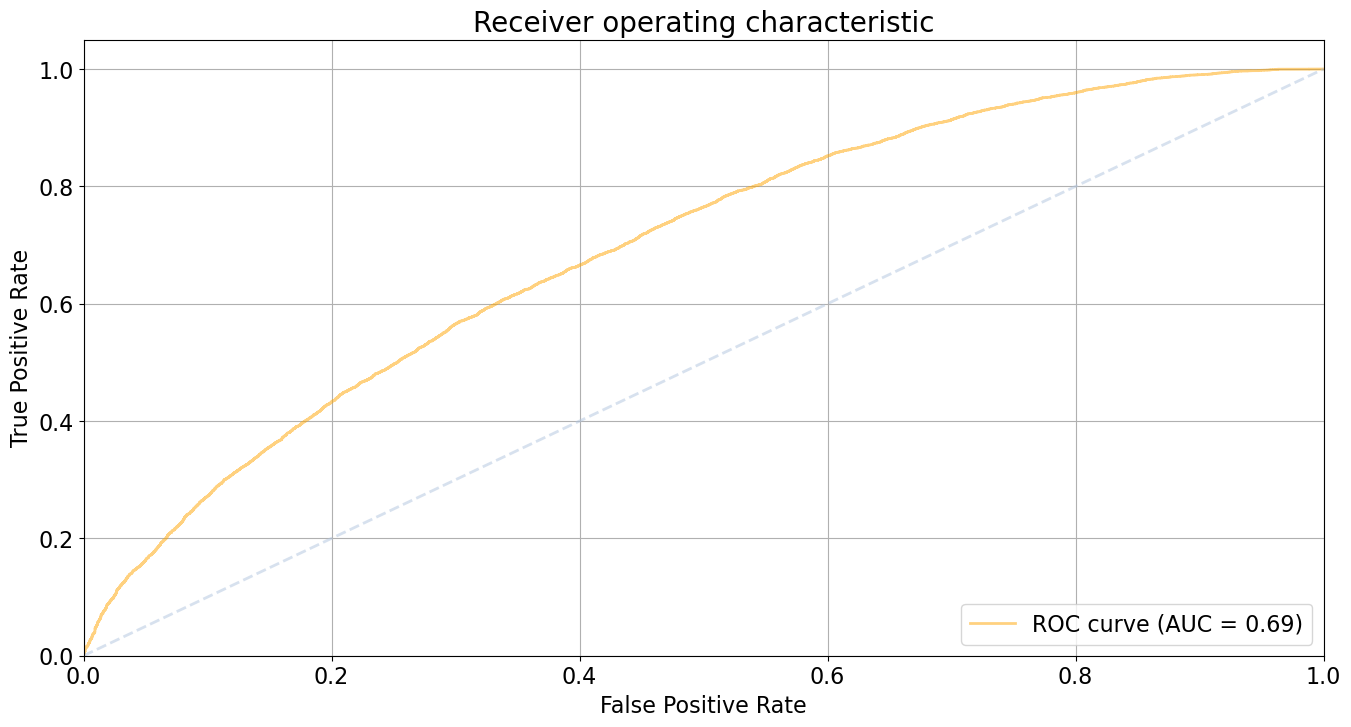

In [210]:
# almost each feature represents or geo_city either utm_source or utm_adcontent. It is different compared to
# previous models
# let us plot roc_auc curve
y_pred_prob_lr = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, color='orange',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='lightsteelblue', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [211]:
# AUC area is 0.69, which is lower than catboost and random forest results.

### Linear SVC

In [212]:
# the last but not least is LinearSVC.
# initialize Linear SVC
svc_v1 = LinearSVC(random_state=42, verbose=True)

In [213]:
svc_v1.fit(X_train, y_train)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69633.983011
nSV = 78940


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42, verbose=True)

In [214]:
# predict on train
svc_v1_pred_train = svc_v1.predict(X_train)
roc_auc_svc_v1_train = roc_auc_score(y_train, svc_v1_pred_train)

In [215]:
roc_auc_svc_v1_train

0.6441711861477792

In [216]:
# good start, predict on test
svc_v1_pred_test = svc_v1.predict(X_test)
roc_auc_svc_v1_test = roc_auc_score(y_test, svc_v1_pred_test)

In [217]:
roc_auc_svc_v1_test

0.6311146695186596

In [218]:
# default settings work well, but results are close to SGD, it's a bit disappointing, but we can use GridSearch to 
# make it better
svc_v1_cvs = cross_val_score(svc_v1, X, y, 
                            cv=5, scoring='roc_auc', 
                            verbose=False, n_jobs=-1)

............................................................................................................................................................................................................................................................................................................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69447.341044
nSV = 78907
.
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69498.918997
nSV = 78916
........

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.........
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69446.700027
nSV = 78928
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69550.888386
nSV = 78936


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -69683.020830
nSV = 79023


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [219]:
print(f'Cross validation score for model svc_v1: {svc_v1_cvs}\nMean: {svc_v1_cvs.mean()}\nStandard deviation: {svc_v1_cvs.std()}')

Cross validation score for model svc_v1: [0.68386107 0.68719785 0.68214529 0.69038668 0.69490066]
Mean: 0.6876983118181778
Standard deviation: 0.004580657406168657


In [220]:
confusion_matrix(y_test, svc_v1_pred_test)

array([[5868, 4233],
       [3195, 6830]])

In [221]:
# model doesn't show overfitting, std and mean are ok, check params
print(f"Model svc_v1 params: {pd.DataFrame.from_dict(svc_v1.get_params(), orient='index')}")

Model svc_v1 params:                                0
C                            1.0
class_weight                None
dual                        True
fit_intercept               True
intercept_scaling              1
loss               squared_hinge
max_iter                    1000
multi_class                  ovr
penalty                       l2
random_state                  42
tol                       0.0001
verbose                     True


In [222]:
# moving further with tuning params with the help of GridSearch
svc = LinearSVC(random_state=42, verbose=True)
svc_grid_param = {
    'C': [0.3, 0.7, 1.0],
    'max_iter': [1000, 2000, 3000],
    'penalty': ['l1', 'l2']
}
svc_grid = GridSearchCV(svc, svc_grid_param, scoring='roc_auc',
                        cv=3, verbose=1, n_jobs=-1)

In [223]:
svc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
...........................................................................................................................................................................................................*..*
optimization finished, #iter = 781
Objective value = -13937.226876
nSV = 52812
........................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -13943.331730
nSV = 52775
.
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -13932.728457
nSV = 52750


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.....................................................................................................................................................................................................*.*
optimization finished, #iter = 781
Objective value = -13937.226876
nSV = 52812
...........................................................................................................................................................................................................................................................................................................................................*.*
optimization finished, #iter = 781
Objective value = -13937.226876
nSV = 52812
..................................................................................
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -13932.730172
nSV = 52750


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


................................................................................................
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -13943.333675
nSV = 52775
..

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -32384.778302
nSV = 52593
...
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -32394.762327
nSV = 52675


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -13932.730188
nSV = 52750


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.............................................................................................................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -13943.333692
nSV = 52775
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...............................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -32402.650037
nSV = 52629
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*.*...*.
optimization finished, #iter = 1814
Objective value = -32394.762401
nSV = 52675
..................................................................................................................................................................
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -32384.831945
nSV = 52593
...
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -32402.710663
nSV = 52628
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..............

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..............................................................................................................................................................................................**...*
optimization finished, #iter = 1814
Objective value = -32394.762401
nSV = 52675
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -46218.178543
nSV = 52620
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..............................................................................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -46204.280798
nSV = 52546
..

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


........................................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -32384.839102
nSV = 52593


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.............................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -32402.718746
nSV = 52628
.

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -46226.509444
nSV = 52565


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -46226.649389
nSV = 52564
...

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.................................................................................................................................................................................
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -46218.181699
nSV = 52620
..

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..
optimization finished, #iter = 2000

Using -s 2 may be faster (also see FAQ)

Objective value = -46204.411508
nSV = 52546
.....................................................................................................................................................................................................................................*..............................................................................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -46218.185111
nSV = 52619


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


...............................................................................................................................................................................................................................................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -46204.442820
nSV = 52546


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


..........................................................................
optimization finished, #iter = 3000

Using -s 2 may be faster (also see FAQ)

Objective value = -46226.683235
nSV = 52565


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 274, in fit


[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -20971.371563
nSV = 79154


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=42, verbose=True),
             n_jobs=-1,
             param_grid={'C': [0.3, 0.7, 1.0], 'max_iter': [1000, 2000, 3000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [224]:
svc_grid.best_params_

{'C': 0.3, 'max_iter': 1000, 'penalty': 'l2'}

In [225]:
# C param became lower: from 1.0 to 0.3. Fit best params
svc = LinearSVC(C=0.3, max_iter=1000, penalty='l2', random_state=42, verbose=True)
svc.fit(X_train, y_train)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -20971.371563
nSV = 79154


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.3, random_state=42, verbose=True)

In [226]:
# predict on train
svc_pred_train = svc.predict(X_train)
roc_auc_svc_train = roc_auc_score(y_train, svc_pred_train)

In [227]:
roc_auc_svc_train

0.643538517048236

In [228]:
# predict on test
svc_pred_test = svc.predict(X_test)
roc_auc_svc_test = roc_auc_score(y_test, svc_pred_test)

In [229]:
roc_auc_svc_test

0.6307636660255114

In [230]:
# it became even worse. Check cvs
svc_cvs = cross_val_score(svc, X, y, 
                          cv=5, scoring='roc_auc', 
                          verbose=False, n_jobs=-1)

..................................................................................................................................................................................................................................*
optimization finished, #iter = 776
Objective value = -20945.715843
nSV = 79191
.....................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -20915.042468
nSV = 79156


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


.......................................*............*........................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

.Objective value = -20932.245755
nSV = 79161


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


........
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -20918.896832
nSV = 79165


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


....................................*..............................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -20989.055547
nSV = 79249


/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [231]:
print(f'Cross validation score for model svc: {svc_cvs}\nMean: {svc_cvs.mean()}\nStandard deviation: {svc_cvs.std()}')

Cross validation score for model svc: [0.68532877 0.68841005 0.68283533 0.69101621 0.69588102]
Mean: 0.6886942765335409
Standard deviation: 0.0045337702160418835


In [232]:
confusion_matrix(y_test, svc_pred_test)

array([[5873, 4228],
       [3207, 6818]])

In [233]:
# This time cvs shows slightly better mean value, std is almost the same. Unfortunately, grid search hasn't enhanced
# our model significantly.

In [234]:
svc_feat_imp = svc.coef_[0]
svc_imp_dict = {col: imp for col, imp in zip(X_train.columns, svc_feat_imp)}

svc_imp_dict = dict(sorted(svc_imp_dict.items(), key=lambda x: x[1], reverse=True))
svc_imp_dict

{'utm_adcontent_xhoenQgDQsgfEPYNPwKO': 0.8745381162446144,
 'utm_adcontent_PkybGvWbaqORmxjNunqZ': 0.8697903701057252,
 'utm_campaign_qpUkxmFZPYAfFrViyYab': 0.8349105548831671,
 'utm_source_ySpKPVDYCgmkHVSeLjnJ': 0.8337695931987403,
 'utm_campaign_kwdmElMUPDZaLQdgjcsI': 0.7716717932678107,
 'geo_city_hurghada': 0.7621860718718068,
 'geo_city_bataysk': 0.7567576652761678,
 'utm_adcontent_ESUnXCsdWADovskBLvBO': 0.7566220243472304,
 'geo_city_kalininets': 0.7563038946292537,
 'geo_city_zagreb': 0.7514666287446171,
 'utm_campaign_tVtbIKrPSOvrXLCznVVe': 0.7502675835361132,
 'geo_city_kaspiysk': 0.744107794778672,
 'geo_city_incheon': 0.7374009085579797,
 'geo_city_beloretsk': 0.7153098940260961,
 'geo_city_kizlyar': 0.7136665257447626,
 'device_brand_condor': 0.7095054940857672,
 'utm_campaign_jqlUOdZBNZYfInQVcZlS': 0.6944668223399965,
 'utm_adcontent_VcJKoPReESIKBdsXSmEi': 0.6918092935309745,
 'geo_city_7668': 0.6905949837225648,
 'utm_campaign_TIRYvHSoLonAvRZefPmz': 0.690028500129624,
 'ge

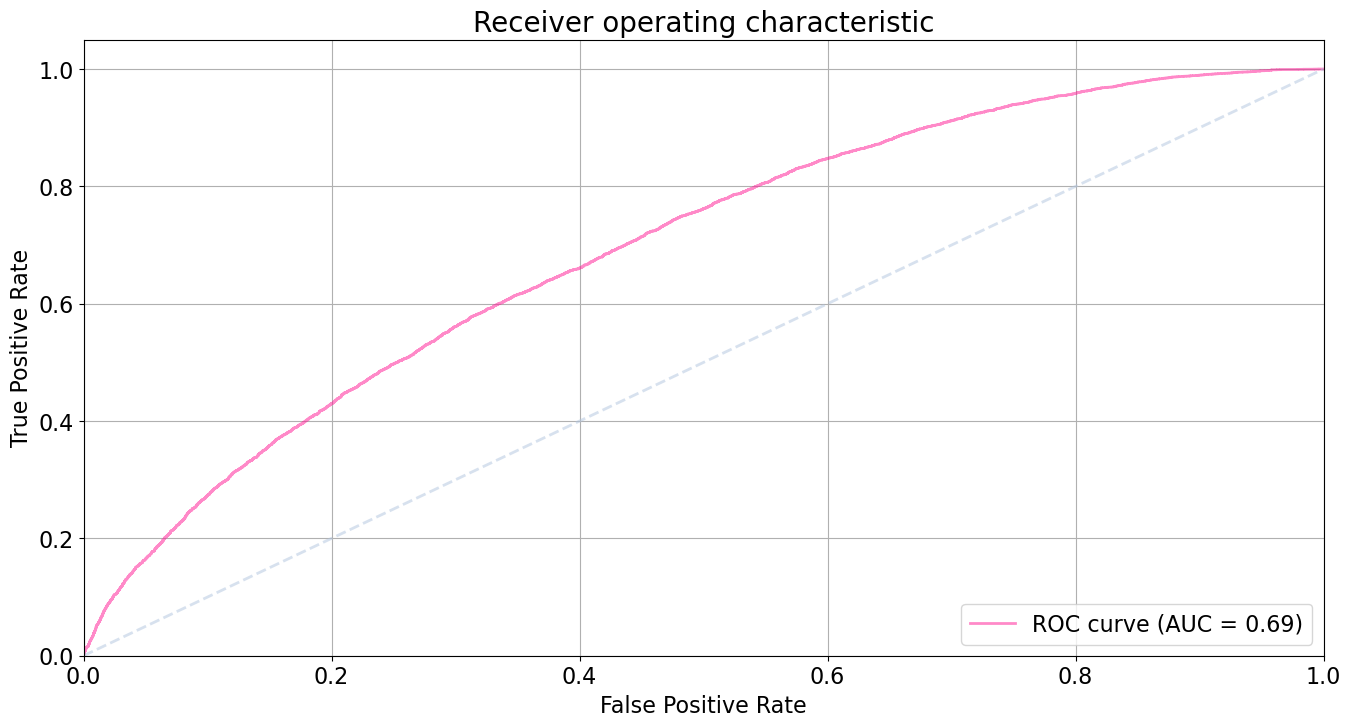

In [235]:
# as well we have many important features like utm_* and geo_*
# we plot roc_auc curve
decision_scores = svc.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, color='deeppink',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='lightsteelblue', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [236]:
# AUC = 0.69 like previous SGD model.

## CV visualization

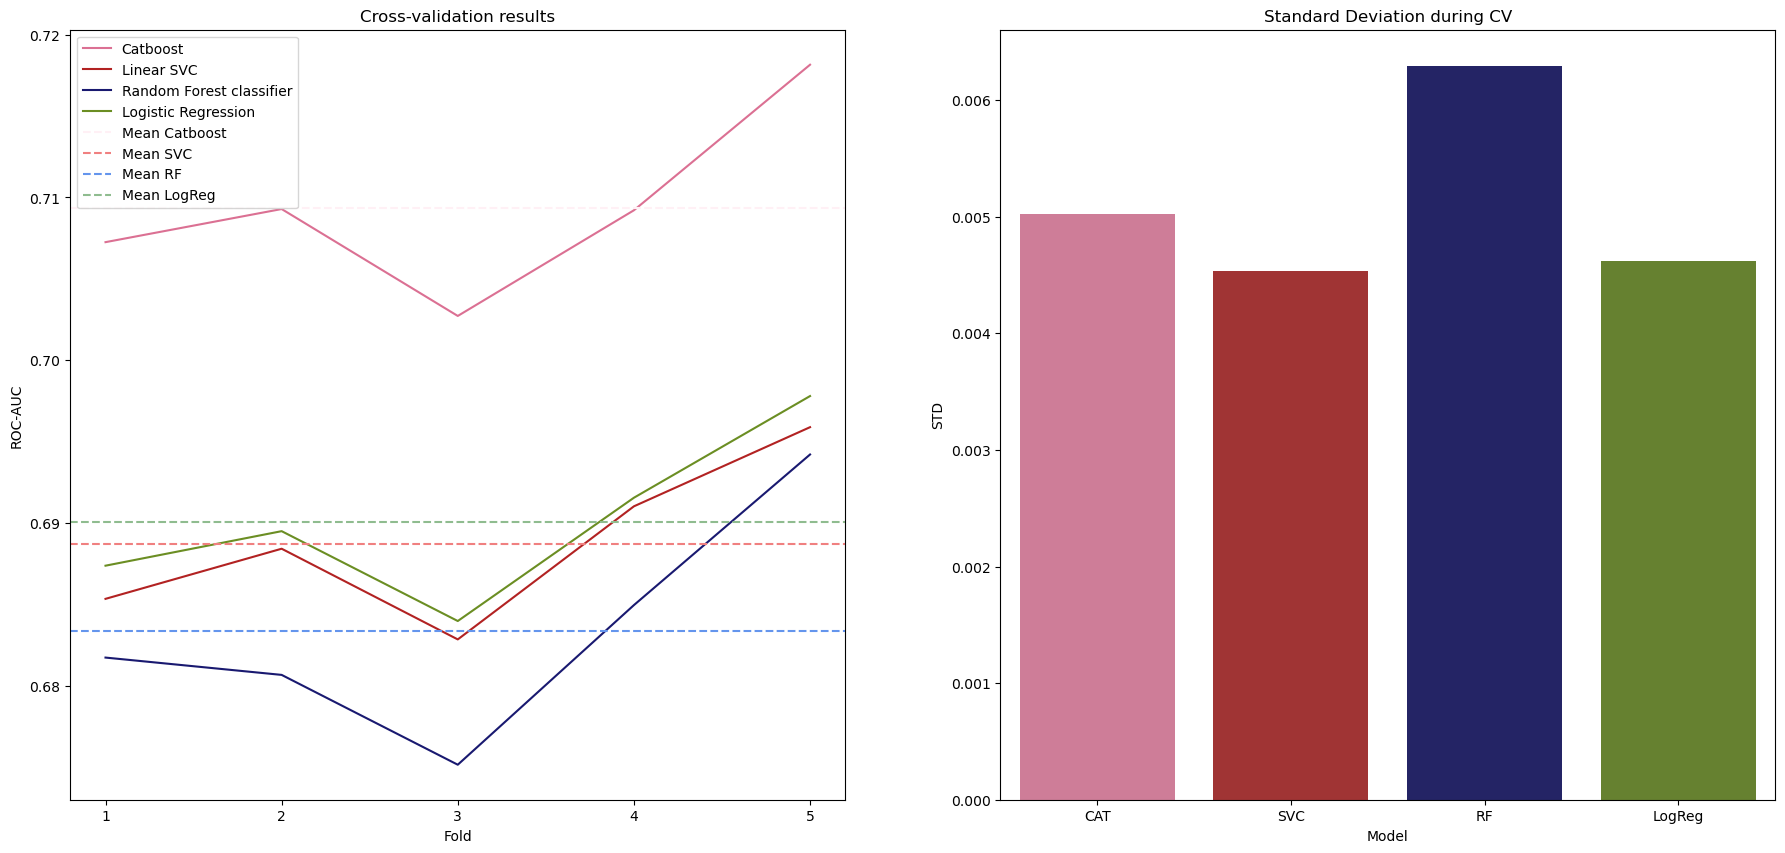

In [237]:
# cross validation results visualization
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
x = range(1, 6)

# plot the lines
sns.lineplot(y=cat_cvs, x=x, ax=ax1, color='palevioletred', label='Catboost')
sns.lineplot(y=svc_cvs, x=x, ax=ax1, color='firebrick', label='Linear SVC')
sns.lineplot(y=rf_cvs, x=x, ax=ax1, color='midnightblue', label='Random Forest classifier')
sns.lineplot(y=logreg_cvs, x=x, ax=ax1, color='olivedrab', label='Logistic Regression')

# calculate means
cat_mean = cat_cvs.mean()
svc_mean = svc_cvs.mean()
rf_mean = rf_cvs.mean()
logreg_mean = logreg_cvs.mean()

# add horizontal lines at the mean values
ax1.axhline(y=cat_mean, color='lavenderblush', linestyle='--', label='Mean Catboost')
ax1.axhline(y=svc_mean, color='lightcoral', linestyle='--', label='Mean SVC')
ax1.axhline(y=rf_mean, color='cornflowerblue', linestyle='--', label='Mean RF')
ax1.axhline(y=logreg_mean, color='darkseagreen', linestyle='--', label='Mean LogReg')

ax1.set_xlabel('Fold')
ax1.set_ylabel('ROC-AUC')
ax1.set_title('Cross-validation results')
ax1.legend()
ax1.set_xticks(x)

# stds data preparation
cat_std = cat_cvs.std()
svc_std = svc_cvs.std()
rf_std = rf_cvs.std()
logreg_std = logreg_cvs.std()

# plot the standard deviation values
sns.barplot(x=['CAT', 'SVC', 'RF', 'LogReg'], y=[cat_std, svc_std, rf_std, logreg_std], 
            ax=ax2, palette=['palevioletred', 'firebrick', 'midnightblue', 'olivedrab'])
ax2.set_xlabel('Model')
ax2.set_ylabel('STD')
ax2.set_title('Standard Deviation during CV')

plt.show()

Catboost shows great results, std is a bit higher than SVC's and logreg's, but AUC is the best

## Results

To summarize:
1. The main goal of the whole task was to preprocess data and train model with ROC-AUC baseline near 0.65.
We observe outstanding quality in gradient boosting on decision trees (CatBoost) predictions (about 0.70), as indicated by the ROC-AUC metric. We also note nearly equal results from other methods such as bagging, stochastic gradient descent, and LinearSVC. CatBoost will be trained on the entire dataset and utilized for further production purposes.
2. Feature engineering points.
We created several new features. From the date column, we engineered month, weekday, and day features. The daytime feature was derived from the visit_time column. We improved the representation of device_brand, utm_medium, and geo_* features. Additionally, we transformed the browser feature into a shorter version and divided the device_screen_resolution into height and width features. Subsequently, we applied one-hot encoding (OHE) and Standard Scaler. Surprisingly, some resulting features showed slight correlation, notably visit_time and resolution features. While all features are interpretable, 'daytime' might be less clear as it partitions the day into segments like morning, evening, e.t.c. These new features significantly improved the performance of most models, particularly in CatBoosting, as they consistently appeared in feature importance lists.

In [238]:
# fit the model
cat = CatBoostClassifier(depth=10, learning_rate=0.03, iterations=1000, 
                         random_state=42, eval_metric='AUC', verbose=False, early_stopping_rounds=20)
cat.fit(X, y, plot=True, verbose=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 186ms	remaining: 3m 5s
20:	total: 1.2s	remaining: 55.7s
40:	total: 2.15s	remaining: 50.2s
60:	total: 3.07s	remaining: 47.2s
80:	total: 3.99s	remaining: 45.3s
100:	total: 4.99s	remaining: 44.5s
120:	total: 5.95s	remaining: 43.2s
140:	total: 6.82s	remaining: 41.6s
160:	total: 7.74s	remaining: 40.3s
180:	total: 8.62s	remaining: 39s
200:	total: 9.51s	remaining: 37.8s
220:	total: 10.4s	remaining: 36.6s
240:	total: 11.3s	remaining: 35.5s
260:	total: 12.3s	remaining: 34.9s
280:	total: 13.2s	remaining: 33.9s
300:	total: 14.2s	remaining: 32.9s
320:	total: 15s	remaining: 31.7s
340:	total: 15.9s	remaining: 30.7s
360:	total: 16.8s	remaining: 29.7s
380:	total: 17.7s	remaining: 28.7s
400:	total: 18.6s	remaining: 27.7s
420:	total: 19.4s	remaining: 26.7s
440:	total: 20.3s	remaining: 25.7s
460:	total: 21.2s	remaining: 24.8s
480:	total: 22.1s	remaining: 23.8s
500:	total: 22.9s	remaining: 22.8s
520:	total: 23.8s	remaining: 21.9s
540:	total: 24.8s	remaining: 21.1s
560:	total: 25.8s	remaining: 20

In [239]:
pred_cat_final = cat.predict(X)
roc_auc_score(y, pred_cat_final)

0.7048038319354454

In [240]:
confusion_matrix(y, pred_cat_final)

array([[33978, 16336],
       [13369, 36945]])

In [241]:
# prediction on train set is 70,48%. We are saving model in pickle file.
filename = "sberauto_model.pickle"

with open(filename, 'wb') as file:
    pickle.dump(cat, file)